In [1]:
import matplotlib
matplotlib.use('Agg')
import datetime
import os
import sys
import json
import glob
import yaml
import math
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
# params = {
#  'axes.labelsize': 14,
#  'font.size': 14,
#  'font.family': 'Roboto',
#  'legend.fontsize': 30,
#  'xtick.labelsize': 20,
#  'ytick.labelsize': 20,
#  'axes.labelsize': 30,
#  'axes.titlesize': 35,
#  'text.usetex': False,
#  'figure.figsize': [12, 12]
# }
# matplotlib.rcParams.update(params)
import seaborn as sns
import pandas as pd
import ase
import pickle
import matplotlib.ticker as ticker

from ase.io.trajectory import Trajectory
from collections import defaultdict
from tqdm import tqdm

from psiturk_dataset.utils.utils import prep_plt

In [2]:
def read_json(path):
    f = open(path)
    return json.loads(f.read())

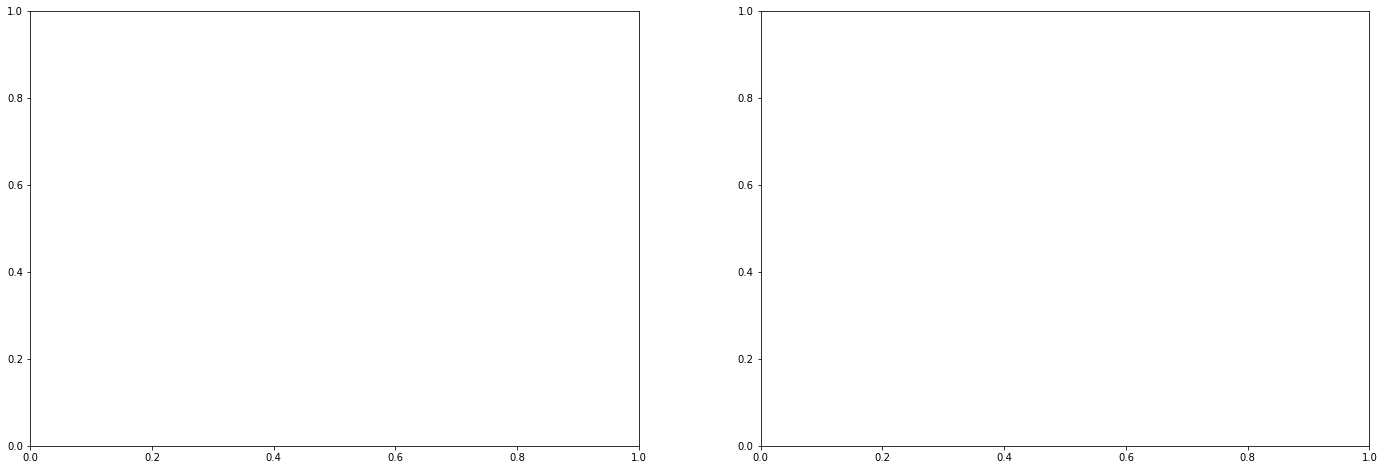

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

fig_dims = (12, 12)

In [4]:
def plot_histogram(dataset, key, path, legend, y_label, x_label, ax,color, edge_color, xlim, interval, title):
    
    g = sns.distplot(dataset[key], bins=50, kde=False, hist=True, ax=ax, kde_kws={"bw_adjust": 1, "linewidth":4}, hist_kws={"alpha": 0.6}, label=legend)
    ax.set_xlim(0, xlim)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(interval))
    ax.grid(alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.spines['bottom'].set_color('0.1')
    ax.spines['top'].set_color('0.1')
    ax.spines['right'].set_color('0.1')
    ax.spines['left'].set_color('0.1')
    ax.legend()

In [5]:
def plot_barplot(X, Y, title="", x_label="", y_label="", ax=None, x_rotation=0, y_rotation=0, color_palette=[], order=[], y_lim=1.0):
    if len(order) == 0 or len(color_palette) == 0:
        plot = sns.barplot(x=X, y=Y, ax=ax)
    else:
        plot = sns.barplot(x=X, y=Y, ax=ax, palette=color_palette, order=order)

    ax.set_ylim(0, y_lim)

    for item in plot.get_xticklabels():
        item.set_rotation(x_rotation)
    # plot.set_xticks([])

    for item in plot.get_yticklabels():
        item.set_rotation(y_rotation)

    ax.spines['bottom'].set_color('0.1')
    ax.spines['top'].set_color('0.1')
    ax.spines['right'].set_color('0.1')
    ax.spines['left'].set_color('0.1')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    
    sns.despine(ax=ax)
    plot.set_title(title, fontsize=46)
    plot.set_xlabel(x_label, labelpad=20) #, fontsize=45)
    labelpad = 40
    plot.set_ylabel(y_label, labelpad=20) #, fontsize=45, labelpad = labelpad)


In [6]:
def plot_mbarplot(data, X, Y, hue, title="", x_label="", y_label="", ax=None, x_rotation=0, y_rotation=0, color_palette=[], order=[], y_lim=1.0):
#     if len(order) == 0:
#         plot = sns.barplot(x=X, y=Y, data=data, hue=hue, ax=ax, palette=color_palette)
#     else:
    plot = sns.barplot(x=X, y=Y, data=data, hue=hue, ax=ax, order=order) #, palette=color_palette) #, order=order)
    prep_plt(ax=plot)

    ax.set_ylim(0, y_lim)

    for item in plot.get_xticklabels():
        print(item)
        item.set_rotation(x_rotation)
    #plot.set_xticks([])

    for item in plot.get_yticklabels():
        item.set_rotation(y_rotation)

    ax.spines['bottom'].set_color('0.1')
    ax.spines['top'].set_color('0.1')
    ax.spines['right'].set_color('0.1')
    ax.spines['left'].set_color('0.1')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    
    sns.despine(ax=ax)
    
    plot.set_title(title)
    plot.set_xlabel(x_label, labelpad=10) #, fontsize=45)
    labelpad = 40
    plot.set_ylabel(y_label, labelpad=10) #, fontsize=45, labelpad = labelpad)
    plot.legend(markerfirst=False, ncol=1, frameon=False, labelspacing=0.4)


In [7]:
variants = {
    "RL_300": "../data/stats/objectnav/evaluation_meta/objectnav_aux_300_v2.json",
    "IL_300": "../data/stats/objectnav/evaluation_meta/objectnav_semseg_35k_300.json",
    "human_val_300": "../data/stats/objectnav/evaluation_meta/human_val_300.json",
    "IL_s_path_300": "../data/stats/objectnav/evaluation_meta/objectnav_semseg_s_path_300.json"
}

variants_full = {
    "RL": "../data/stats/objectnav/evaluation_meta/objectnav_aux_nomap.json",
    "IL": "../data/stats/objectnav/evaluation_meta/objectnav_semseg_24k_posthoc.json",
    "Human": "../data/stats/objectnav/evaluation_meta/human_val_full_meta_posthoc.json",
}


variants_final = {
    "IL_s_path_300": "../data/stats/objectnav/evaluation_meta/objectnav_semseg_s_path_300.json",
    "RL": "../data/stats/objectnav/evaluation_meta_v2/evaluation_meta_300_ckpt31.json",
    "IL": "../data/stats/objectnav/evaluation_meta_v2/evaluation_meta_35k.json",
    "Human": "../data/stats/objectnav/evaluation_meta_v2/human_val_300_meta.json",
}

variant_output_path = {
    #"RL_full": "figures/objectnav/objectnav_aux_full",
    "RL": "figures/objectnav/objectnav_rl_test_v2",
    #"RL_300": "figures/objectnav/objectnav_aux_300",
    #"IL_full": "figures/objectnav/objectnav_il_full",
    "IL": "figures/objectnav/objectnav_il_test_v2",
    #"IL_300": "figures/objectnav/objectnav_il_300",
    "Human": "figures/objectnav/objectnav_human_test_v2",
    #"human_val_full": "figures/objectnav/objectnav_human_full",
    #"human_val_300": "figures/objectnav/objectnav_human_300",
}

In [8]:
dataset = read_json("../data/stats/objectnav/evaluation_meta/human_val_full_meta.json")
success_samples = [ep["metrics"]["success"]*100 for ep in dataset]
spl_samples = [ep["metrics"]["spl"]*100 for ep in dataset]
print(get_standard_error(success_samples))
print(get_standard_error(spl_samples))

NameError: name 'get_standard_error' is not defined

### Color palette

In [9]:
def get_all_rooms(paths):
    all_rooms = []
    all_scenes = []
    for path in paths:
        print(path)
        dataset = read_json(path)
        for ep in dataset:
            all_rooms.extend(list(ep["metrics"]["room_visitation_map"]["room_visitation_map"].keys()))
            all_scenes.append(ep["scene_id"].split("/")[-1].split(".")[0])
    all_rooms = list(set(all_rooms))
    all_scenes = list(set(all_scenes))
    return all_rooms, all_scenes


all_rooms, all_scenes = get_all_rooms(list(variants_full.values()))
print("Total unique rooms: {} - {}".format(len(all_rooms), len(all_scenes)))

../data/stats/objectnav/evaluation_meta/objectnav_aux_nomap.json
../data/stats/objectnav/evaluation_meta/objectnav_semseg_24k_posthoc.json
../data/stats/objectnav/evaluation_meta/human_val_full_meta_posthoc.json
Total unique rooms: 25 - 11


In [10]:
palette = sns.color_palette(palette='hls', n_colors=len(all_rooms), desat=0.9)
palette_dict = {}
for i, mode in enumerate(all_rooms):
    palette_dict[mode] = palette[i]

In [11]:
sns.color_palette("hls", 24)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5012, 0.33999999999999997),
 (0.86, 0.6312, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.6988, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.43879999999999986, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.86, 0.6312),
 (0.33999999999999997, 0.86, 0.7612000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6988, 0.86),
 (0.33999999999999997, 0.5688000000000001, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.5011999999999995, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7612000000000001, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999),
 (0.86, 0.33999999999999997, 0.6987999999999996),
 (0.86, 0.33999999999999997, 0.5688000000000001),
 (0.86, 0.33999999999999997, 0.43879999999999986)]

In [12]:
palette_dict.keys()

dict_keys(['dining room', 'familyroom/lounge', 'lounge', 'bathroom', 'balcony', 'entryway/foyer/lobby', 'other room', 'bar', 'stairs', 'utilityroom/toolroom', 'rec/game', 'office', 'laundryroom/mudroom', 'junk', 'toilet', 'porch/terrace/deck', 'closet', 'garage', 'kitchen', 'outdoor', 'hallway', 'workout/gym/exercise', 'bedroom', 'spa/sauna', 'living room'])

In [13]:
scene_palette = sns.color_palette(palette='hls', n_colors=len(all_scenes), desat=0.9)
scene_palette_dict = {}
for i, mode in enumerate(all_scenes):
    scene_palette_dict[mode] = scene_palette[i]

### Error bars

In [14]:
def get_standard_error(values):
    return np.std(values)/ np.sqrt(len(values))

def get_success_samples(sr, n):
    samples = n * sr
    
    x = np.zeros(n)
    x[:samples] = 100
    return x

## Quantitative analysis

In [15]:
def pre_process_dataset(dset):
    failed_episodes = []
    avg_success_per_scene = defaultdict(int)
    avg_success_per_goal_object = defaultdict(int)
    ep_per_scene = defaultdict(int)
    ep_per_goal_object = defaultdict(int)
    avg_time_spent_per_room_per_object = {}
    eps_per_object = defaultdict(int)
    
    ocs = []
    scs = []

    for ep in dset:
        if not ep["metrics"]["success"]: # and "pLe4wQe7qrG" not in ep['scene_id']:
            failed_episodes.append(ep)
        scene_id = ep["scene_id"].split("/")[-1].split(".")[0]
        goal_object = ep["object_category"]
        avg_success_per_scene[scene_id] += ep["metrics"]["success"]
        ep_per_scene[scene_id] += 1
        
        avg_success_per_goal_object[goal_object] += ep["metrics"]["success"]
        ep_per_goal_object[goal_object] += 1
        
        object_category = ep["object_category"]
        room_visitation_map = ep["metrics"]["room_visitation_map"]["room_visitation_map"]
        eps_per_object[object_category] += 1
        
        if len(room_visitation_map.keys()) == 0:
            continue

        steps_per_episode = sum(room_visitation_map.values())

        if object_category not in avg_time_spent_per_room_per_object.keys():
            avg_time_spent_per_room_per_object[object_category] = defaultdict(int)

        for room, steps in room_visitation_map.items():
            avg_time_spent_per_room_per_object[object_category][room] += steps / steps_per_episode
#         ocs.append(ep["metrics"]["exploration_metrics"]["coverage"]*100)
#         scs.append(ep["metrics"]["exploration_metrics"]["sight_coverage"]*100)

    
    avg_time_spent_goal_room = 0
    steps_per_episode = defaultdict(int)
    avg_time_spent_goal_room_per_scene = defaultdict(int)
    
    print(len(failed_episodes))
    #print(avg_time_spent_per_room_per_object)
    grts = []

    for ep in failed_episodes:
        room_visitation_map = ep["metrics"]["room_visitation_map"]["room_visitation_map"]
        scene_id = ep["scene_id"].split("/")[-1].split(".")[0]
        if len(room_visitation_map.keys()) == 0:
            continue
        steps_per_episode = sum(room_visitation_map.values())
        avg_time_spent_goal_room += ep["metrics"]["room_visitation_map"]["time_spent_goal_room"] / steps_per_episode
        
        avg_time_spent_goal_room_per_scene[scene_id] += ep["metrics"]["room_visitation_map"]["time_spent_goal_room"] / steps_per_episode
        
        grts.append(ep["metrics"]["room_visitation_map"]["time_spent_goal_room"] / steps_per_episode * 100)


    avg_time_spent_goal_room /= len(failed_episodes)

    for object_category, room_map in avg_time_spent_per_room_per_object.items():
        for room, value in room_map.items():
            avg_time_spent_per_room_per_object[object_category][room] = value / eps_per_object[object_category]
        avg_time_spent_per_room_per_object[object_category] = {k: v for k, v in sorted(avg_time_spent_per_room_per_object[object_category].items(), key=lambda item: item[1], reverse=True)}
        
    
    for scene, value in avg_success_per_scene.items():
        avg_success_per_scene[scene] = value / ep_per_scene[scene]
        avg_time_spent_goal_room_per_scene[scene] = avg_time_spent_goal_room_per_scene[scene] / ep_per_scene[scene]
    
    for goal_object, value in avg_success_per_goal_object.items():
        avg_success_per_goal_object[goal_object] = avg_success_per_goal_object[goal_object] / ep_per_goal_object[goal_object]
    
    avg_success_per_scene = {k: v for k, v in sorted(avg_success_per_scene.items(), key=lambda item: item[1], reverse=True)}
    avg_success_per_goal_object = {k: v for k, v in sorted(avg_success_per_goal_object.items(), key=lambda item: ep_per_goal_object[item[0]], reverse=True)}

    #print("OC: {}".format(1.96 * np.std(ocs) / np.sqrt(len(ocs))))
    #print("SC: {}".format(1.96 * np.std(scs) / np.sqrt(len(scs))))
    #print("GRTS: {}".format(1.96 * np.std(grts) / np.sqrt(len(grts))))
    return avg_success_per_scene, avg_success_per_goal_object, avg_time_spent_goal_room_per_scene, avg_time_spent_per_room_per_object    

In [16]:
def exploration_metrics(dataset):
    avg_stats = defaultdict(int)
    pt_ep_ids = []
    peek_ep_ids = []
    pt_eps = []
    peek_eps = []
    bee_eps = []
    es_eps = []
    
    std_err_peeks = 0
    std_err_pt = 0
    std_err_bee = 0
    std_err_es = 0
    for ep in dataset:
        s_cov = ep["metrics"]["exploration_metrics"]["sight_coverage"]
        o_cov = ep["metrics"]["exploration_metrics"]["coverage"]

        revis_map = ep["metrics"].get("exploration_metrics")
        revisits = len(revis_map["room_revisitation_map_strict"].keys())
        avg_stats["peeks"] += int(revisits > 0) / len(dataset)
        avg_stats["panoramic_turns"] += int(ep["metrics"]["exploration_metrics"]["panoramic_turns_strict"] >= 1) / len(dataset)

        if ep["metrics"]["success"]:
            avg_stats["beeline"] += int(ep["metrics"]["exploration_metrics"]["beeline"])
        avg_stats["exhaustive_search"] += int(ep["metrics"]["exploration_metrics"]["sight_coverage"] > 0.75) / len(dataset)
        
        avg_stats["sight_coverage"] += s_cov / len(dataset)
        avg_stats["occupancy_coverage"] += o_cov / len(dataset)
        
        if revisits > 0:
            peek_ep_ids.append(ep['episode_id'])
            
        if ep["metrics"]["exploration_metrics"]["panoramic_turns_strict"] >= 1:
            pt_ep_ids.append(ep['episode_id'])
        
        peek_eps.append(int(revisits > 0)*100)
        pt_eps.append(int(ep["metrics"]["exploration_metrics"]["panoramic_turns_strict"] >= 1)*100)
        bee_eps.append(int(ep["metrics"]["exploration_metrics"]["beeline"])*100)
        es_eps.append(int(ep["metrics"]["exploration_metrics"]["sight_coverage"] > 0.75)*100)

    avg_stats["beeline"] = avg_stats["beeline"] / len(dataset)
    
    print("Peeks : {}".format(1.96 * np.std(peek_eps) / np.sqrt(len(peek_eps))))
    print("PTs : {}".format(1.96 * np.std(pt_eps) / np.sqrt(len(pt_eps))))
    print("Bees : {}".format(1.96 * np.std(bee_eps) / np.sqrt(len(pt_eps))))
    print("ES : {}".format(1.96 * np.std(es_eps) / np.sqrt(len(pt_eps))))
    
    print()
#     print(pt_ep_ids)
#     print(peek_ep_ids)
    
    return avg_stats

In [17]:
for key, value in variants_final.items():
    if key != "IL":
        continue
    dataset = read_json(value)
    avg_success_per_scene, avg_success_per_goal, avg_time_spent_goal_room, avg_time_per_room = pre_process_dataset(dataset)
    avg_exploration_stats = exploration_metrics(dataset)
    print(key)
    print(avg_exploration_stats)
    print("-------end---------")
    

202
Peeks : 4.439302647939201
PTs : 2.30402301943233
Bees : 5.152090176344469
ES : 5.64544523061307

IL
defaultdict(<class 'int'>, {'peeks': 0.18999999999999978, 'panoramic_turns': 0.043333333333333335, 'beeline': 0.10333333333333333, 'exhaustive_search': 0.46666666666666773, 'sight_coverage': 0.6721649225306074, 'occupancy_coverage': 0.17338867105038827})
-------end---------


### Exploration stats

In [18]:
for key, value in variants.items():
    dataset = read_json(value)
    avg_success_per_scene, avg_success_per_goal, avg_time_spent_goal_room, avg_time_per_room = pre_process_dataset(dataset)
    avg_exploration_stats = exploration_metrics(dataset)
    print(key)
    print(avg_exploration_stats)
    

195
Peeks : 3.3439350516464326
PTs : 2.1267647486960795
Bees : 1.8231004929535306
ES : 5.65690091834743

RL_300
defaultdict(<class 'int'>, {'peeks': 0.09666666666666661, 'panoramic_turns': 0.03666666666666667, 'beeline': 0.006666666666666667, 'exhaustive_search': 0.4900000000000012, 'sight_coverage': 0.6627265780003114, 'occupancy_coverage': 0.1444325794271396})
201
Peeks : 4.497888821641976
PTs : 5.572388223959141
Bees : 5.152090176344469
ES : 5.6257526377135285

IL_300
defaultdict(<class 'int'>, {'peeks': 0.19666666666666643, 'panoramic_turns': 0.41333333333333405, 'beeline': 0.10333333333333333, 'exhaustive_search': 0.553333333333334, 'sight_coverage': 0.7218680633032991, 'occupancy_coverage': 0.2102830120565045})
2
Peeks : 3.9353242644680955
PTs : 5.223946022092394
Bees : 4.840851322817415
ES : 5.691451474299935

human_val_300
defaultdict(<class 'int'>, {'peeks': 0.13851351351351338, 'panoramic_turns': 0.3006756756756756, 'beeline': 0.23648648648648649, 'exhaustive_search': 0.52027

1502
1597
7
1502


/home/rramrakhya/research/anaconda3/envs/habitat/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


1597
7


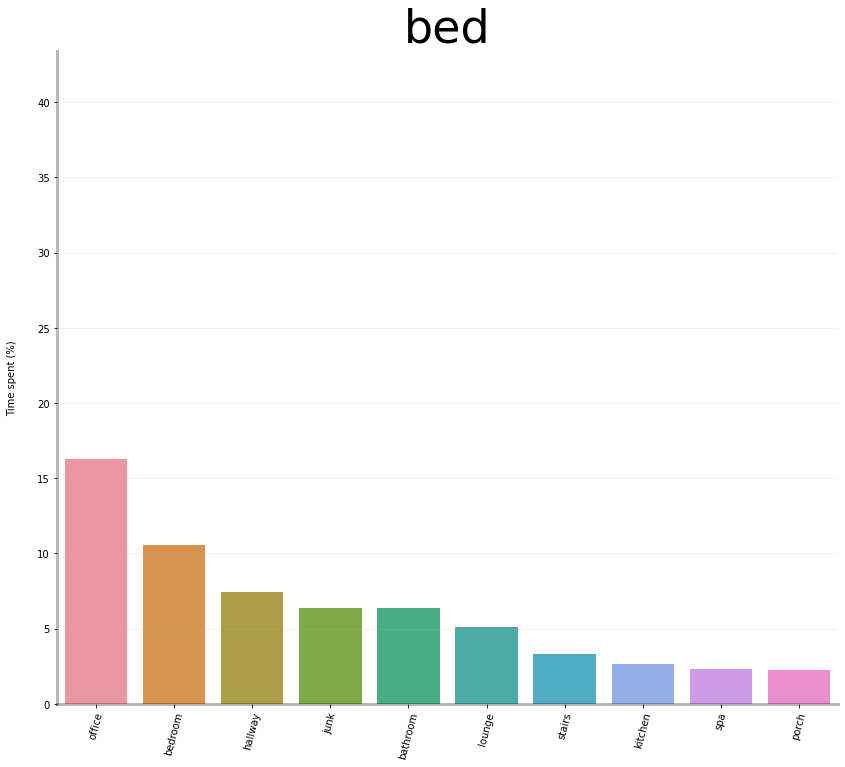

<Figure size 432x288 with 0 Axes>

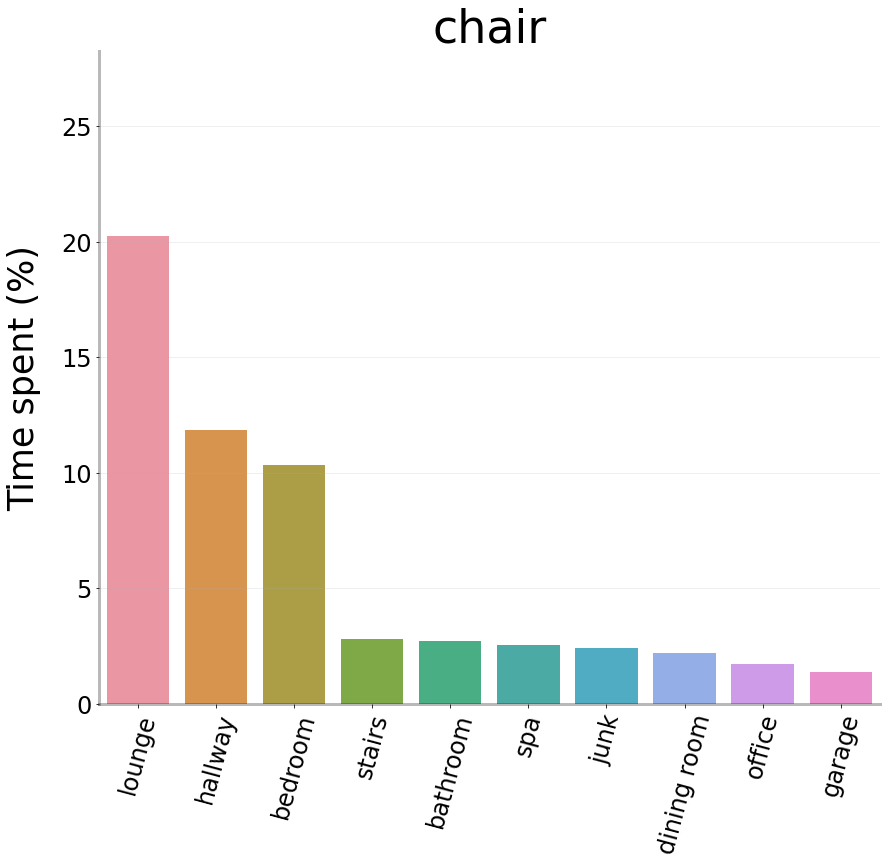

<Figure size 432x288 with 0 Axes>

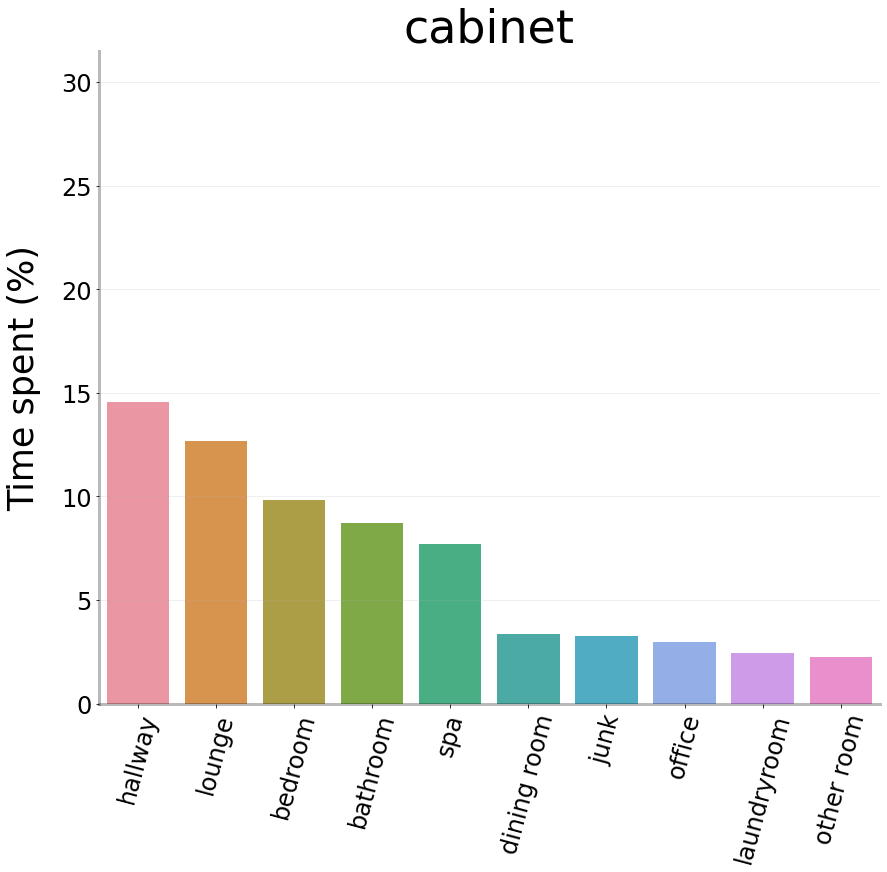

<Figure size 432x288 with 0 Axes>

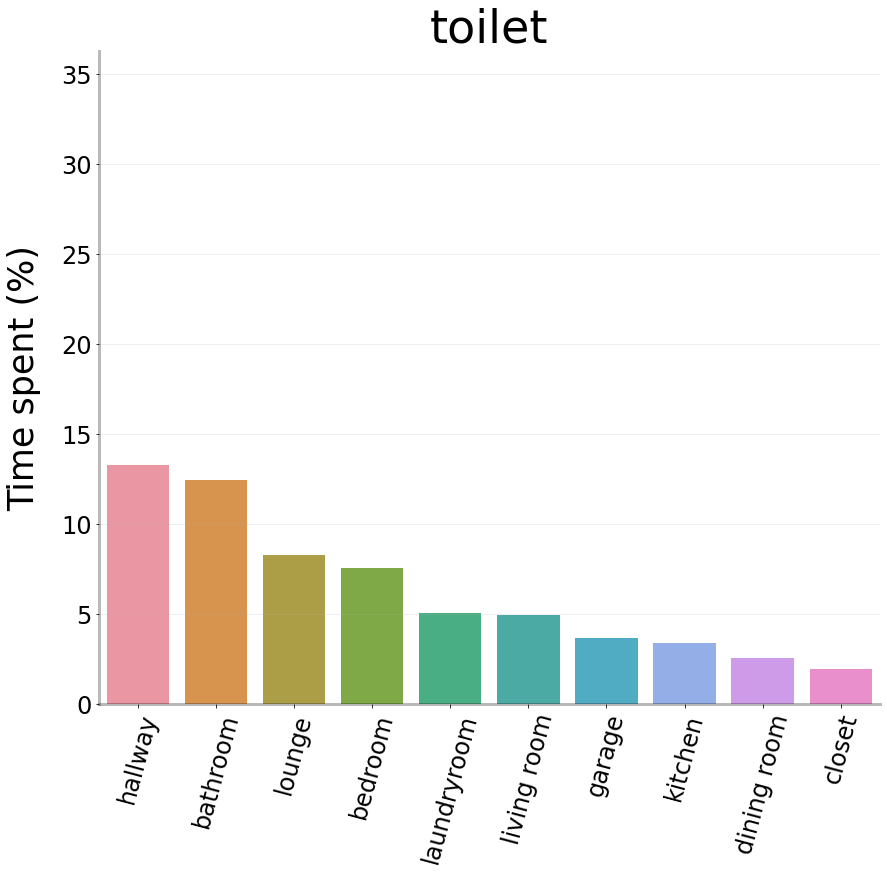

<Figure size 432x288 with 0 Axes>

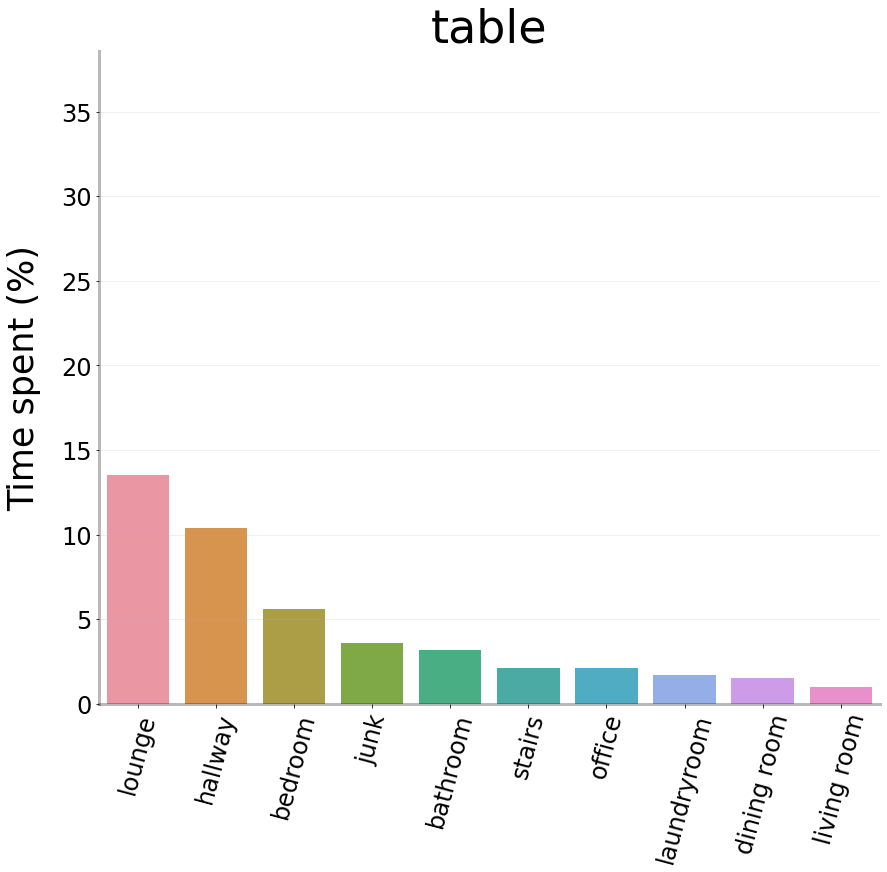

<Figure size 432x288 with 0 Axes>

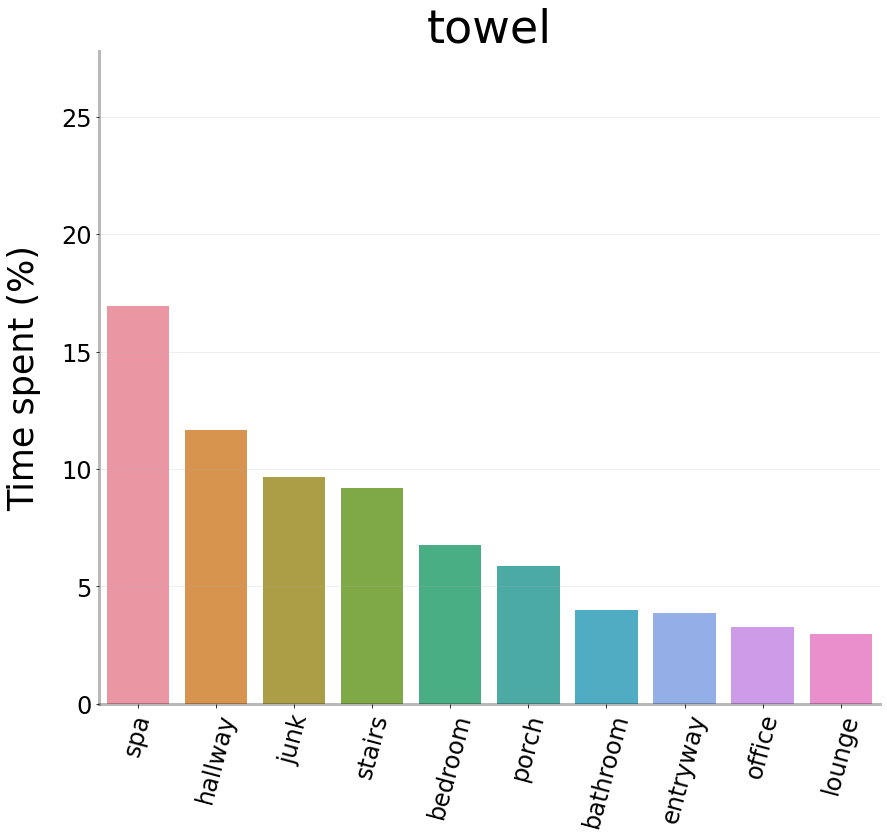

<Figure size 432x288 with 0 Axes>

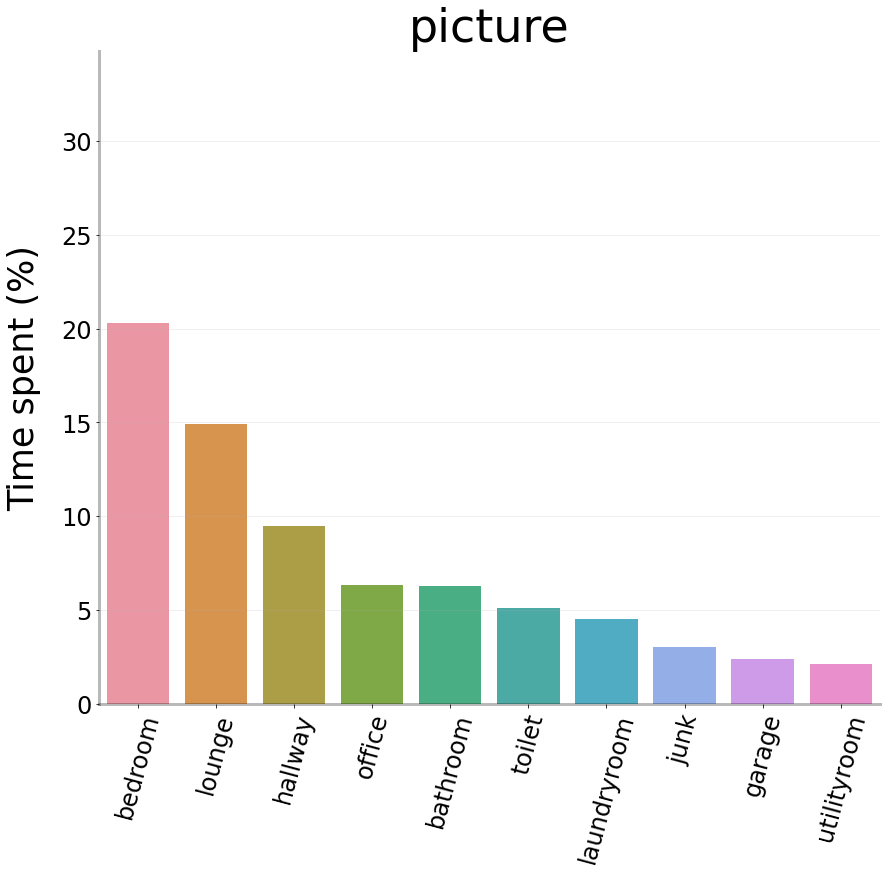

<Figure size 432x288 with 0 Axes>

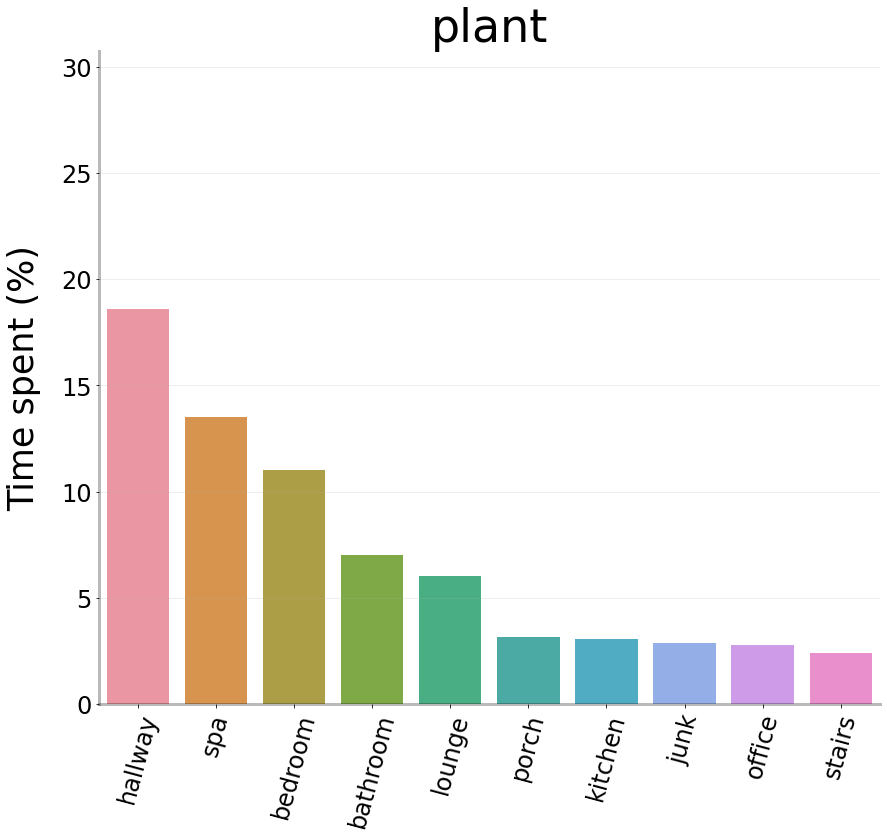

<Figure size 432x288 with 0 Axes>

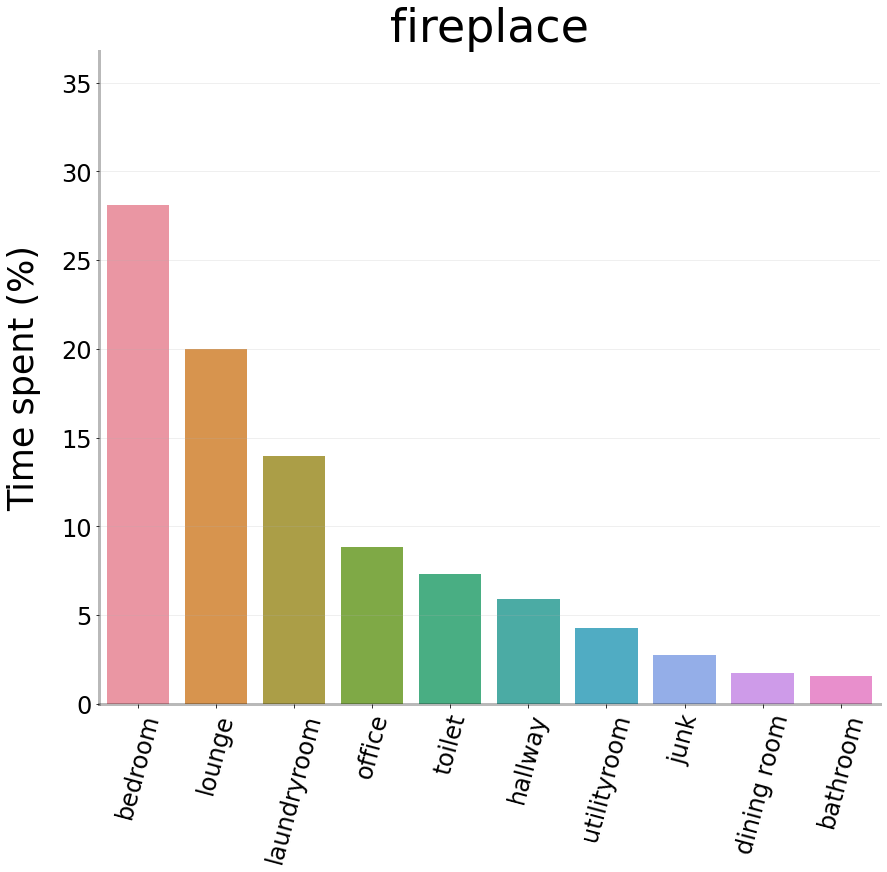

<Figure size 432x288 with 0 Axes>

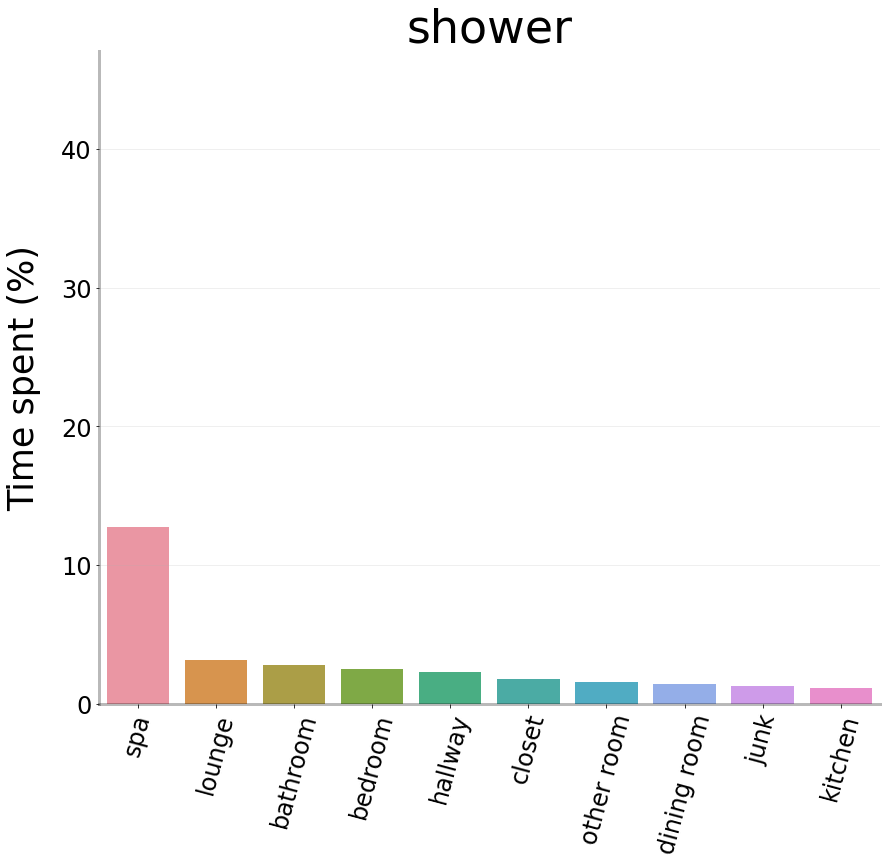

<Figure size 432x288 with 0 Axes>

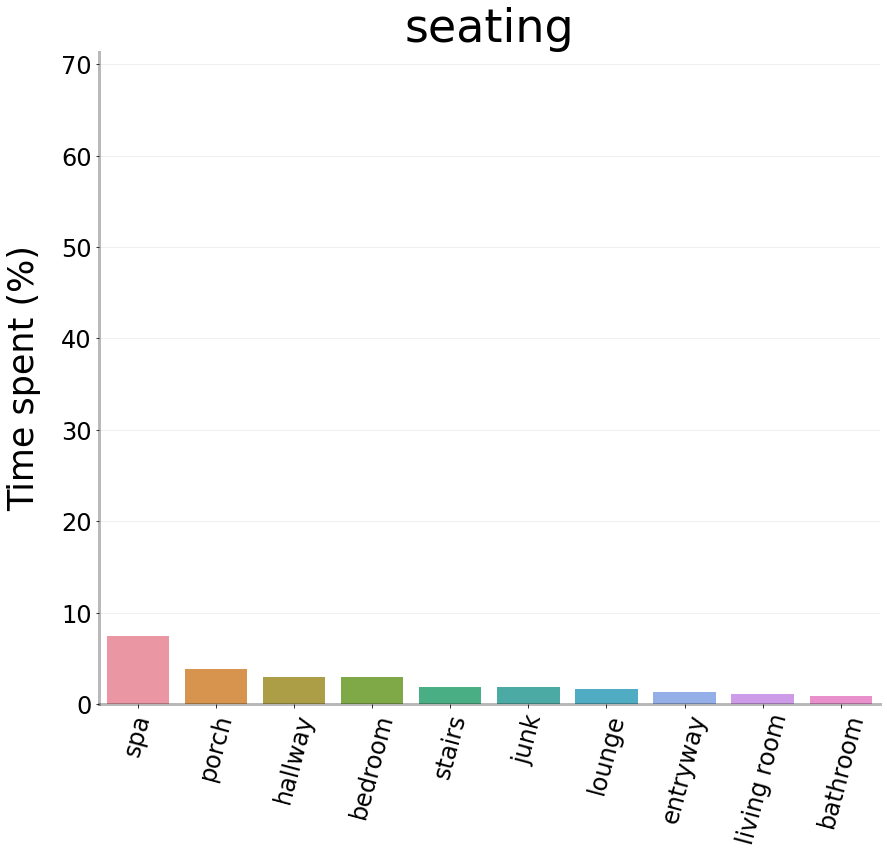

<Figure size 432x288 with 0 Axes>

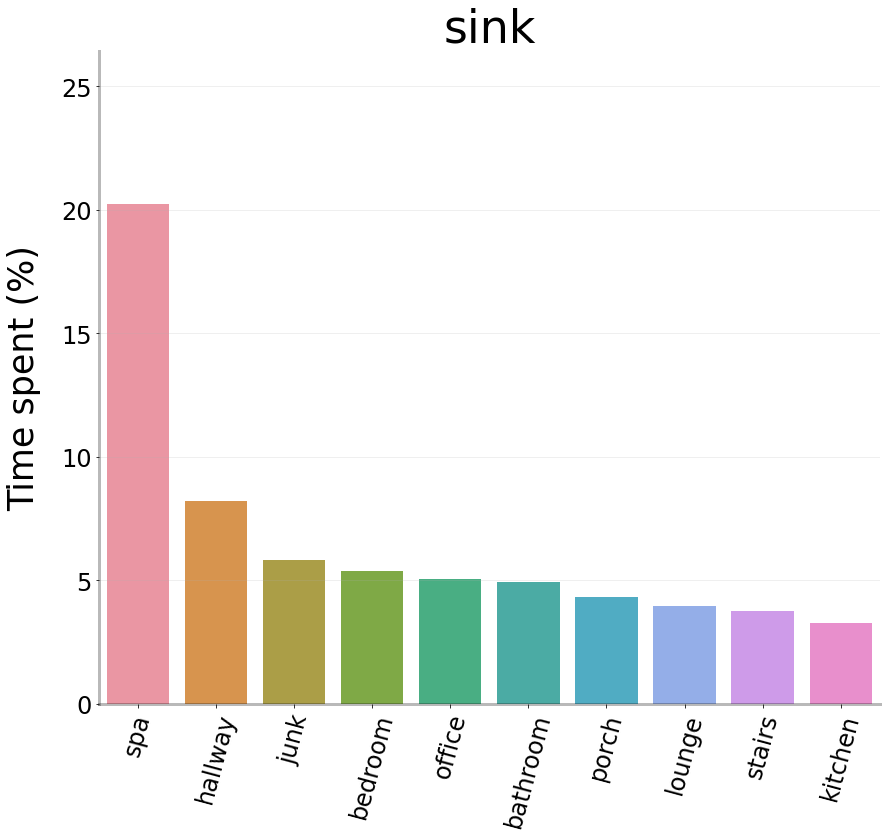

<Figure size 432x288 with 0 Axes>

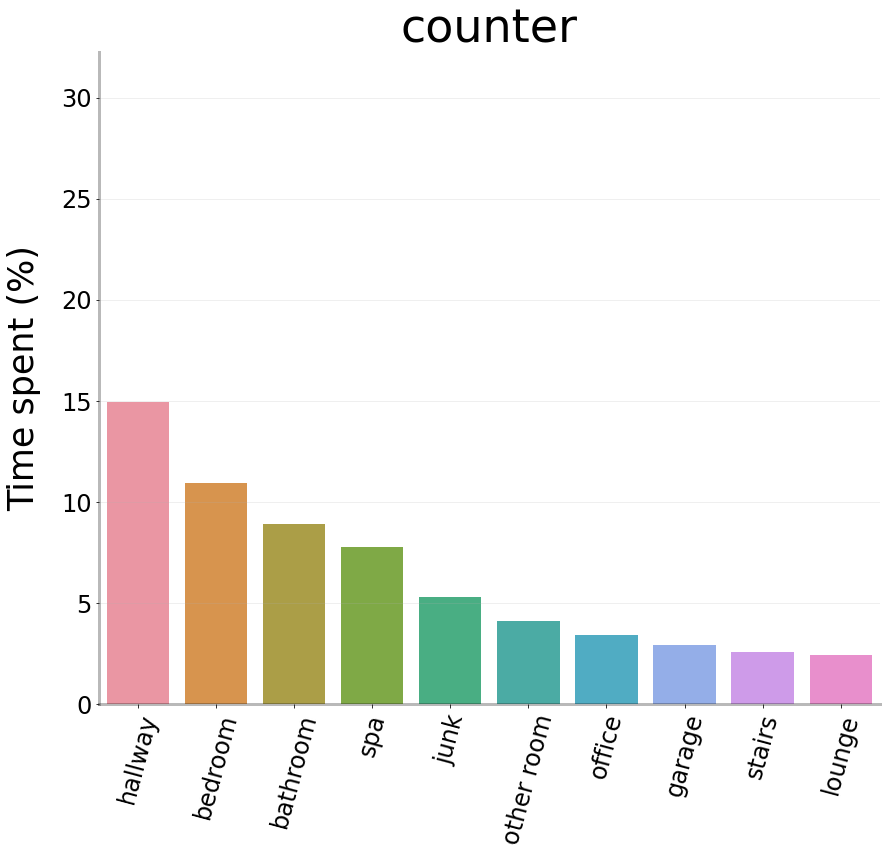

<Figure size 432x288 with 0 Axes>

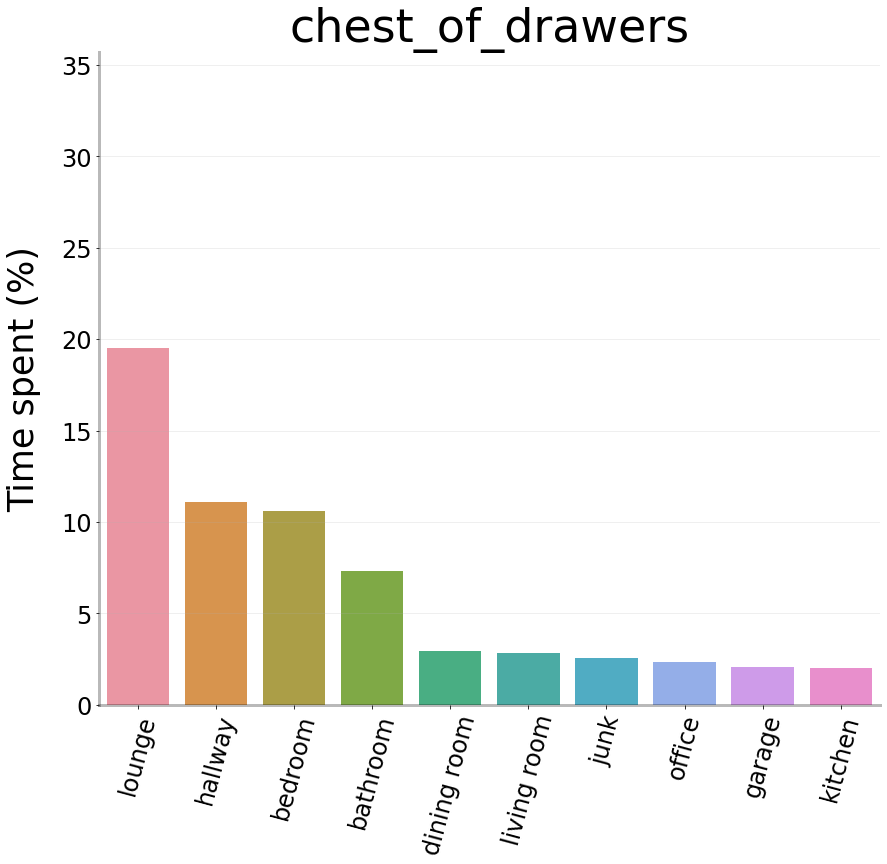

<Figure size 432x288 with 0 Axes>

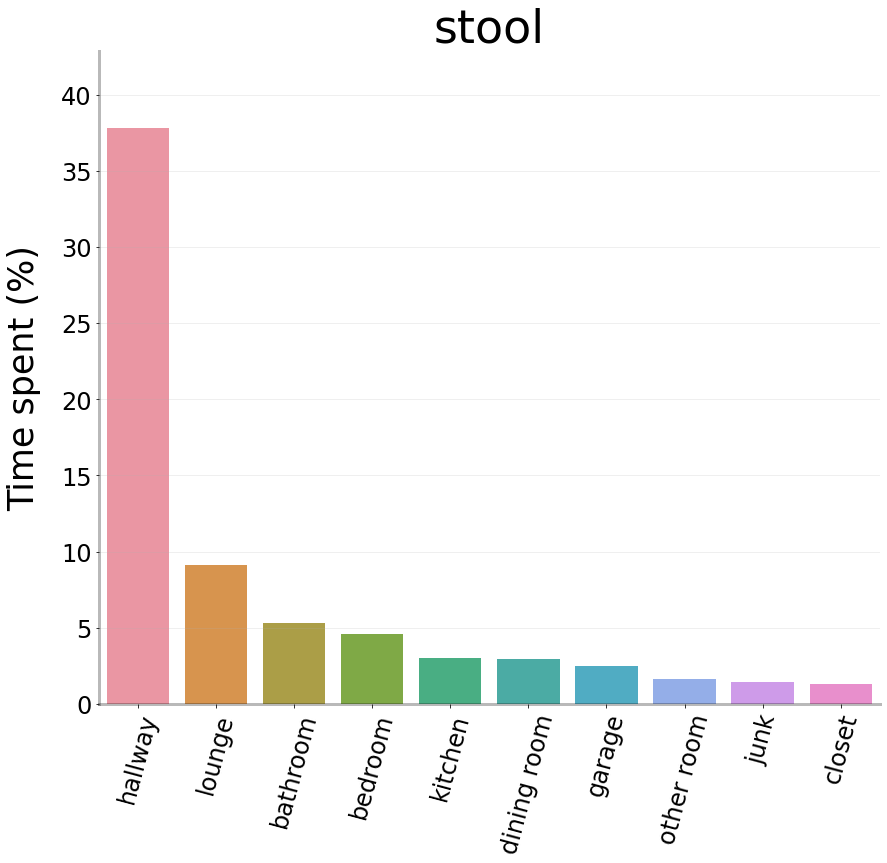

<Figure size 432x288 with 0 Axes>

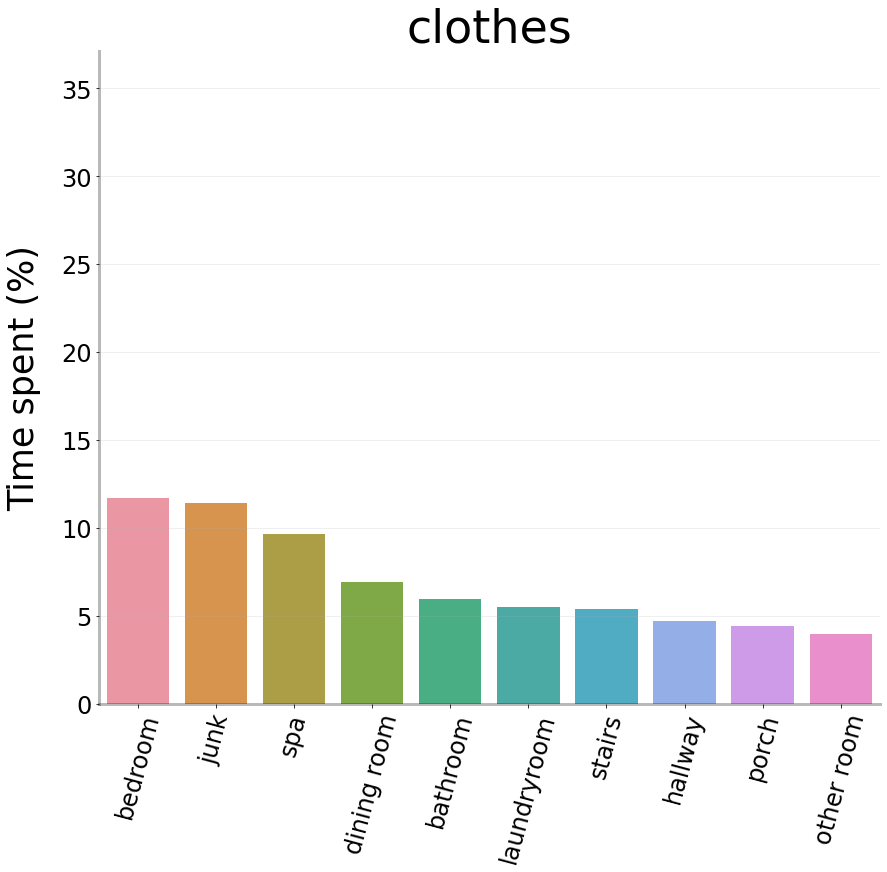

<Figure size 432x288 with 0 Axes>

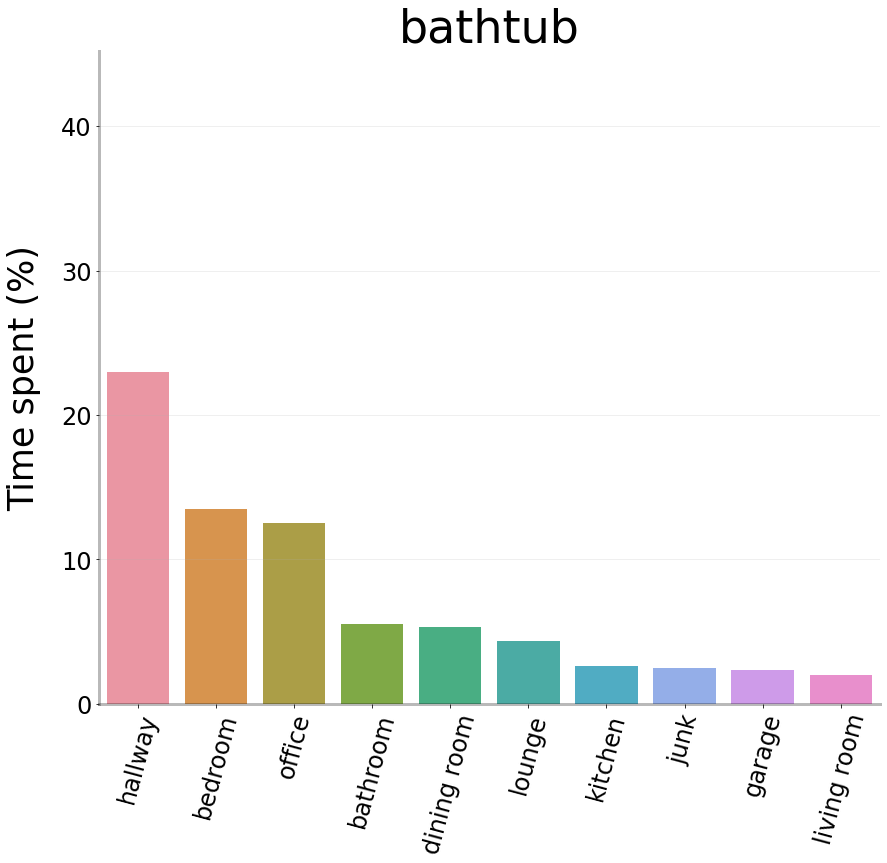

<Figure size 432x288 with 0 Axes>

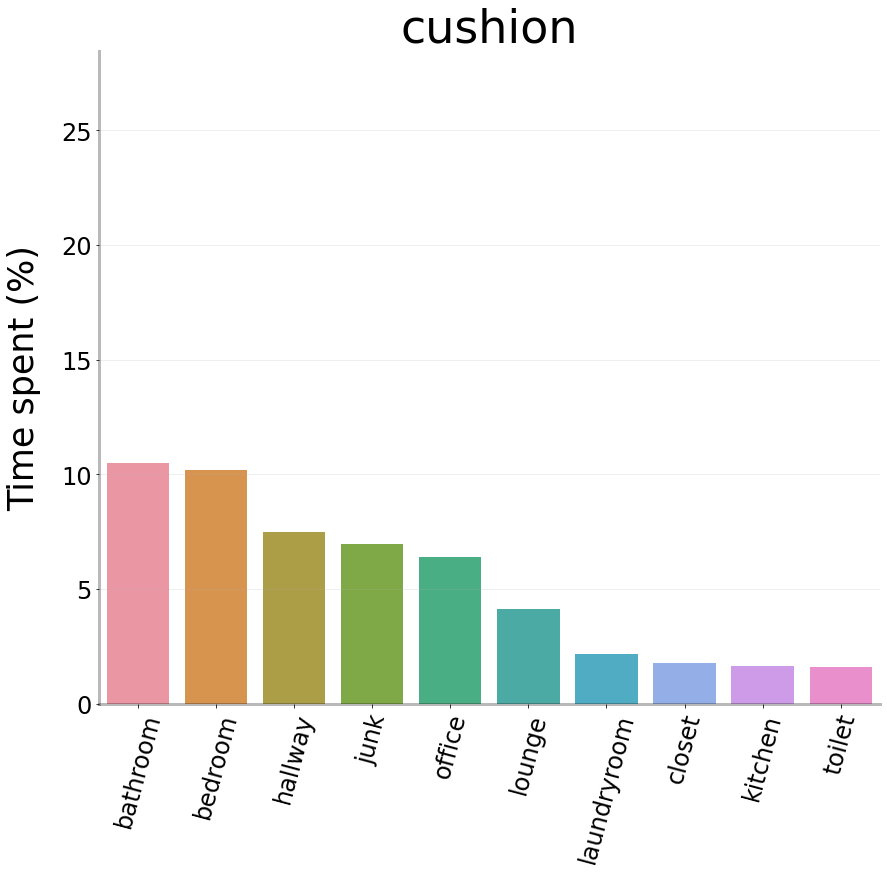

<Figure size 432x288 with 0 Axes>

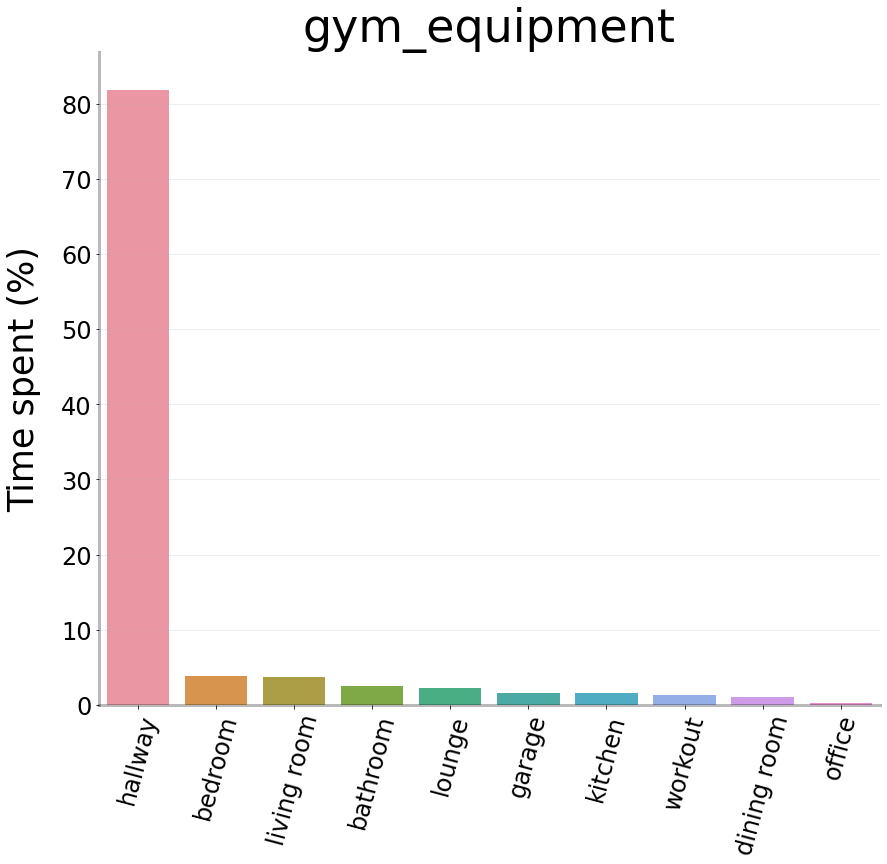

<Figure size 432x288 with 0 Axes>

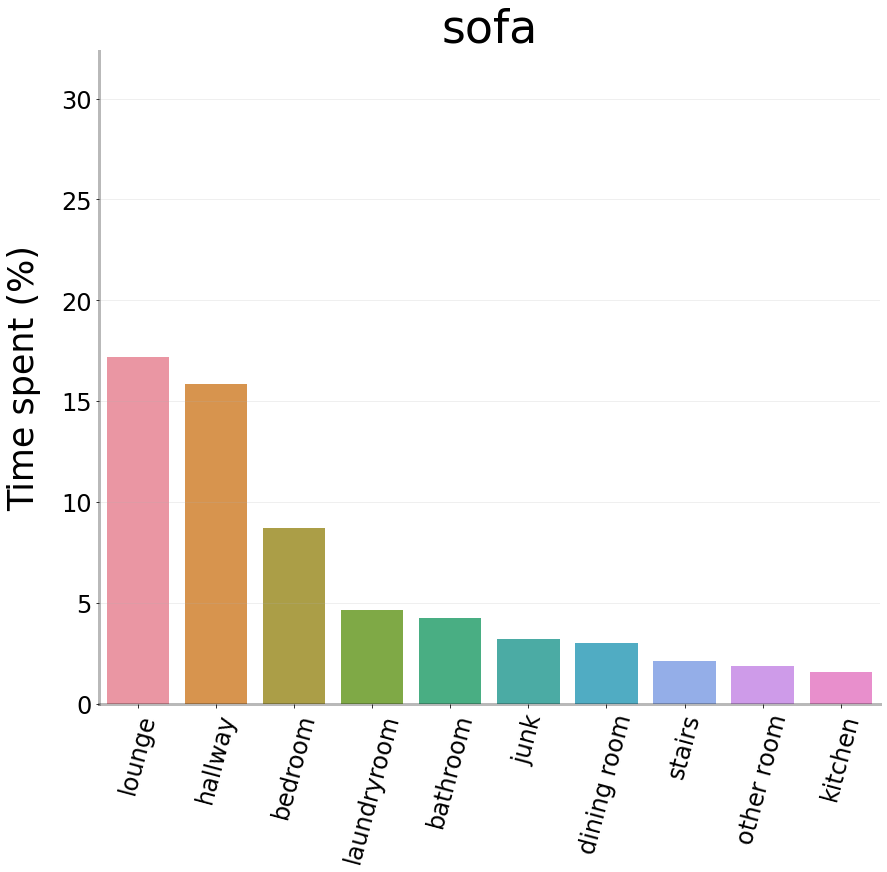

<Figure size 432x288 with 0 Axes>

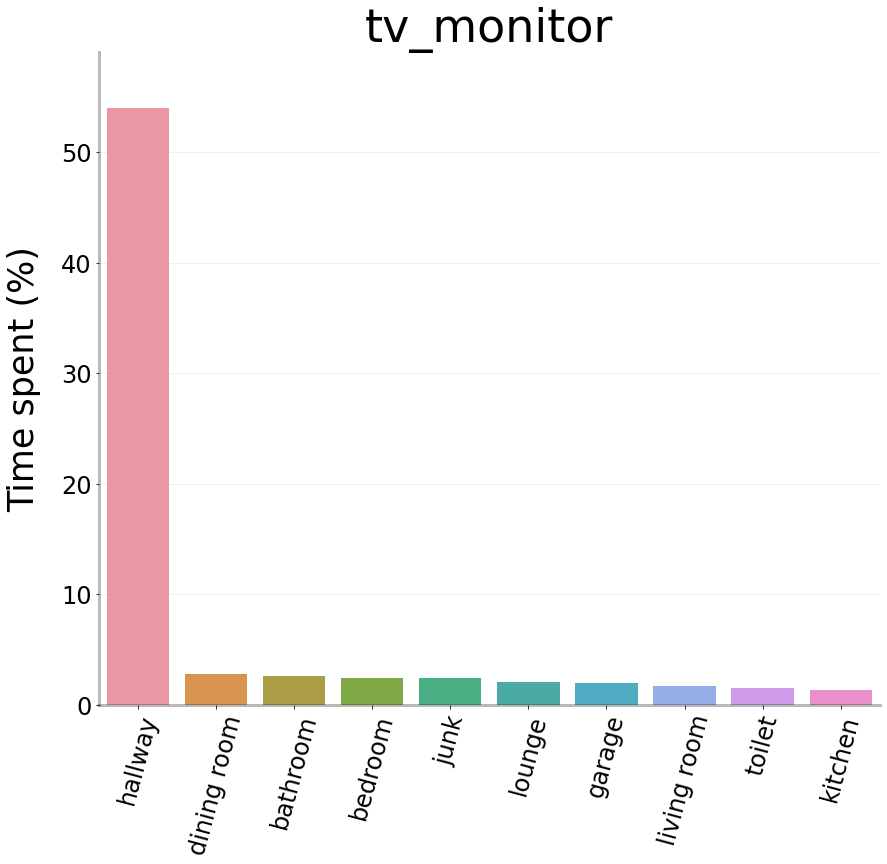

<Figure size 432x288 with 0 Axes>

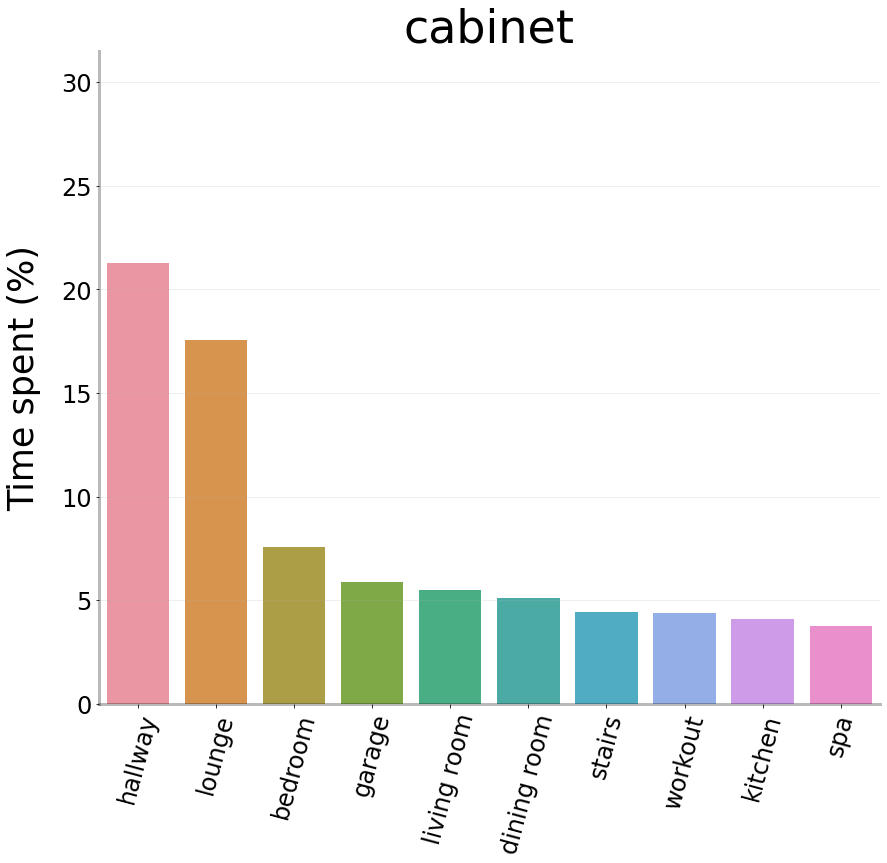

<Figure size 432x288 with 0 Axes>

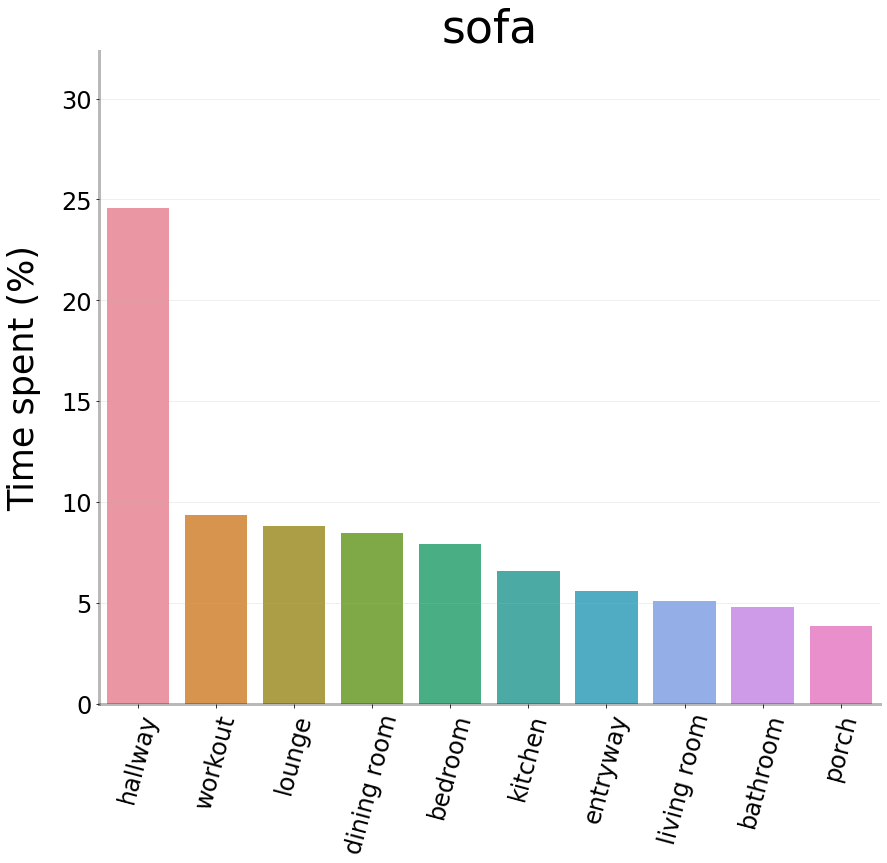

<Figure size 432x288 with 0 Axes>

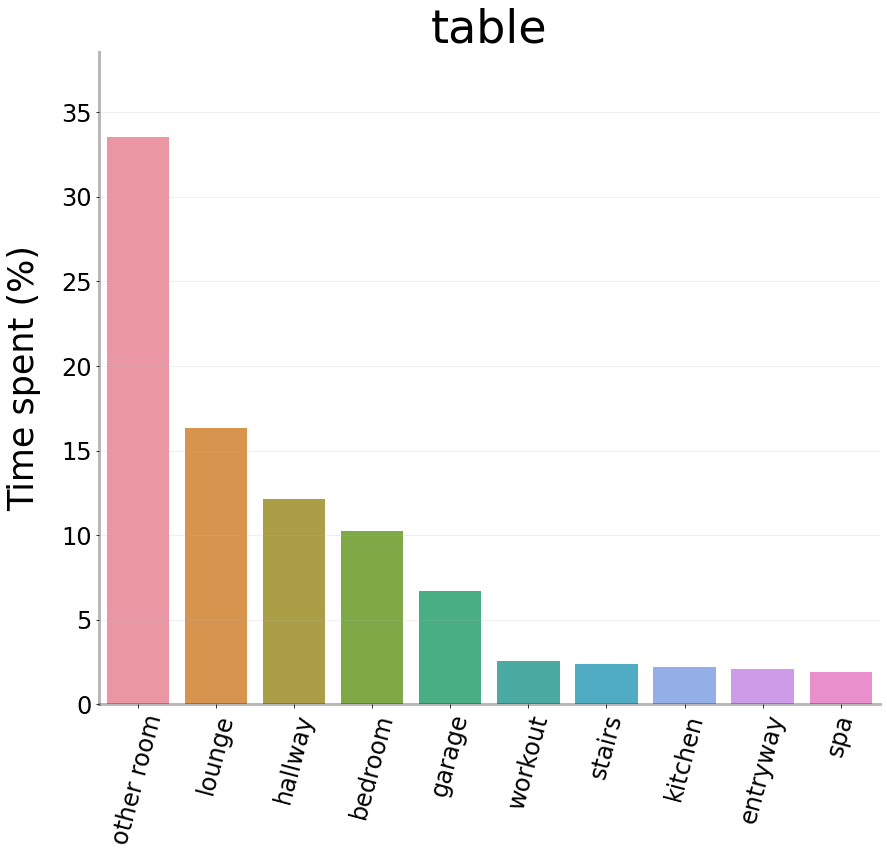

<Figure size 432x288 with 0 Axes>

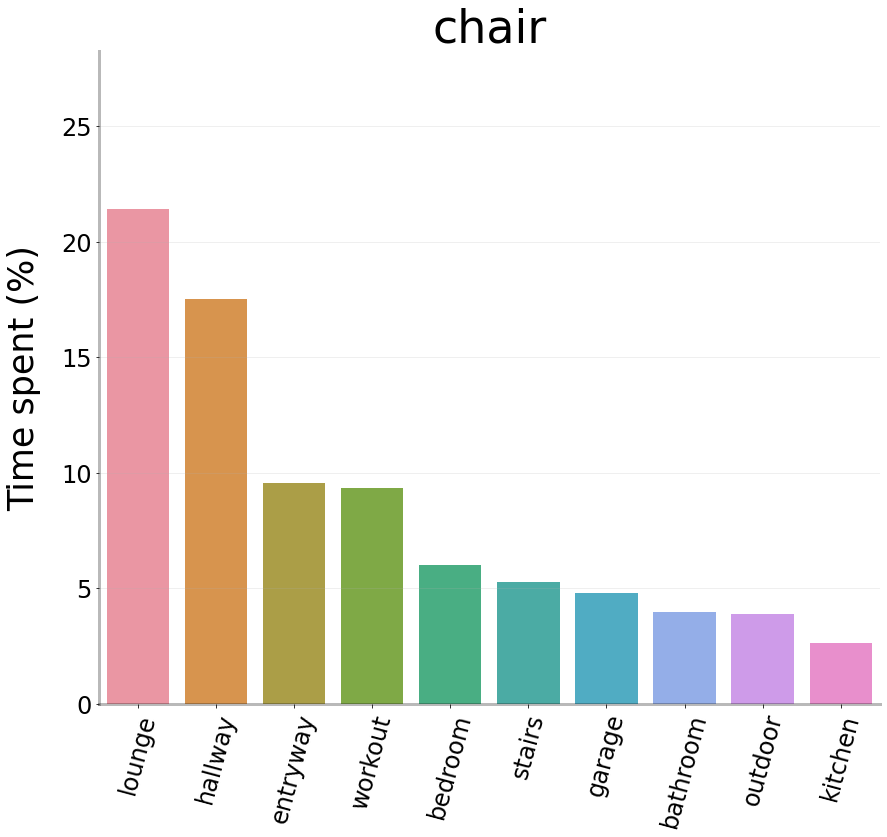

<Figure size 432x288 with 0 Axes>

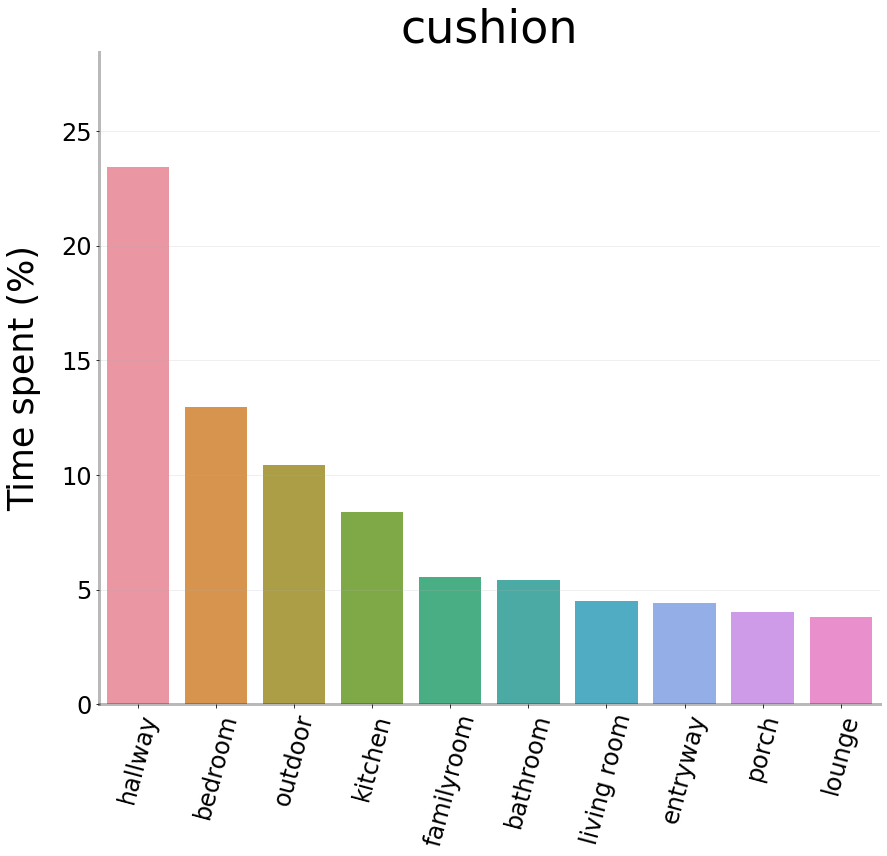

<Figure size 432x288 with 0 Axes>

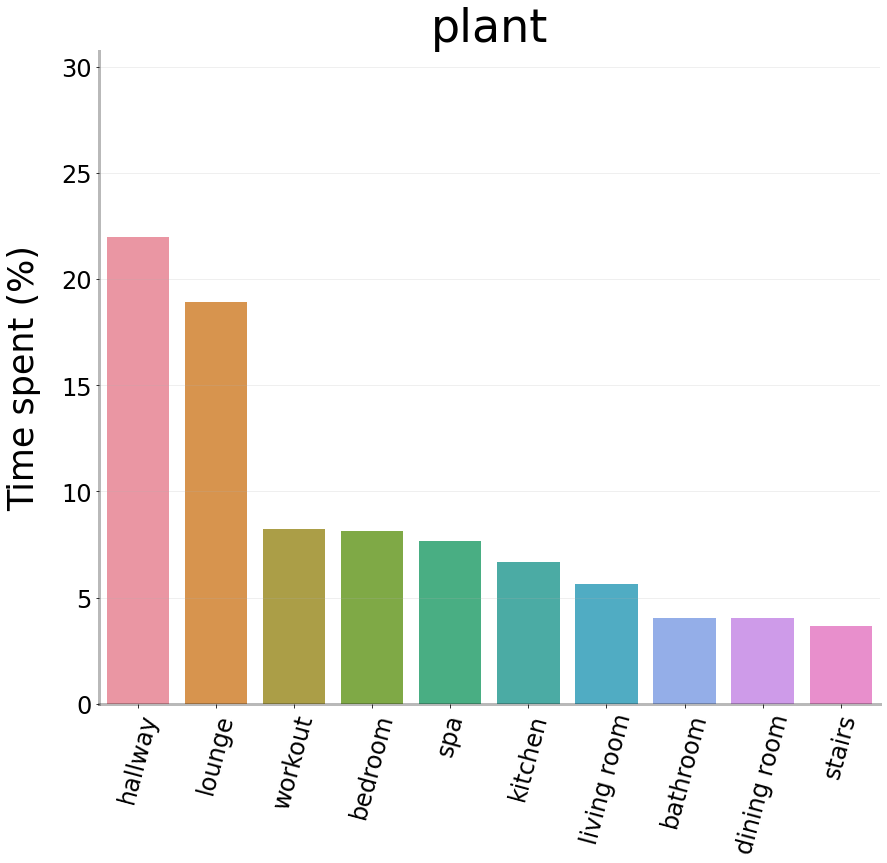

<Figure size 432x288 with 0 Axes>

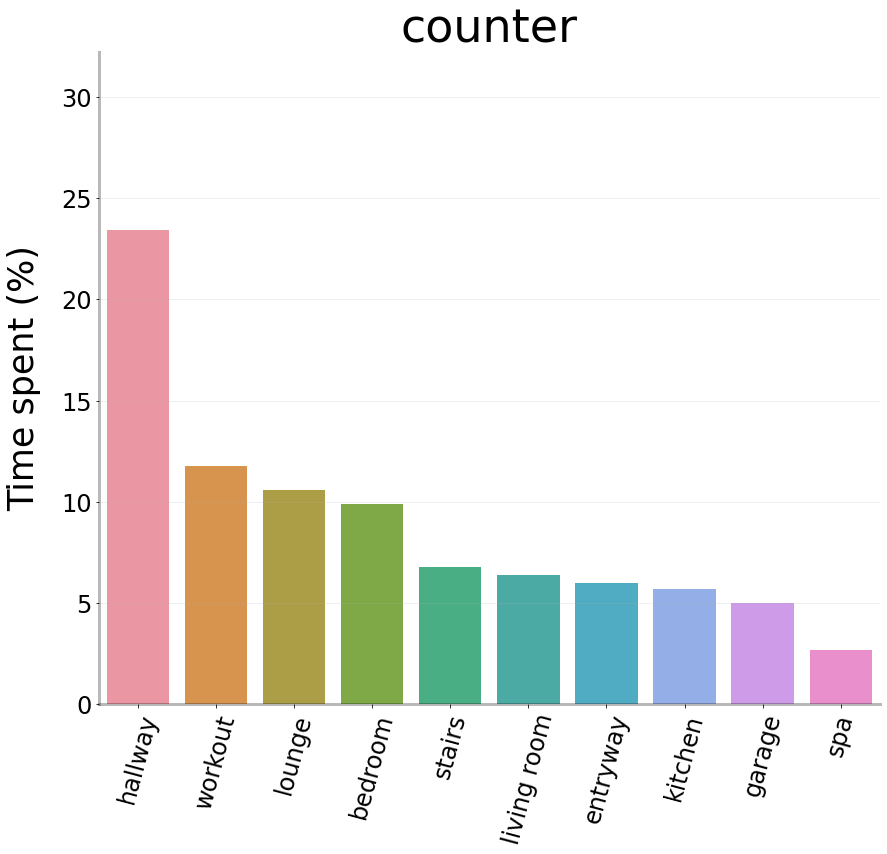

<Figure size 432x288 with 0 Axes>

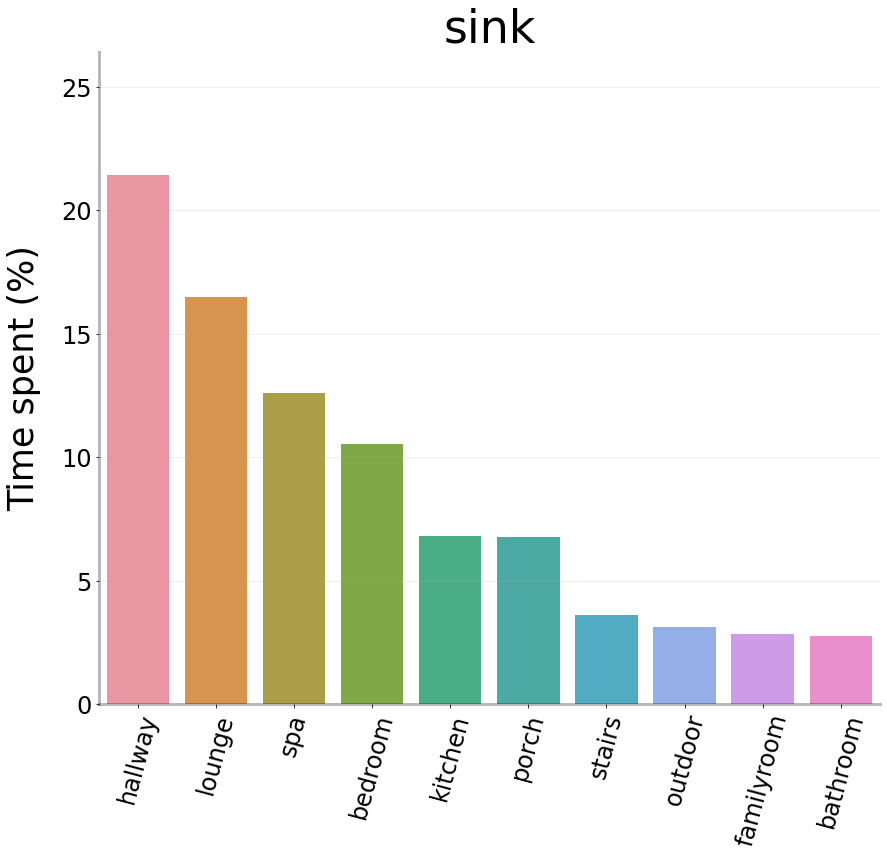

<Figure size 432x288 with 0 Axes>

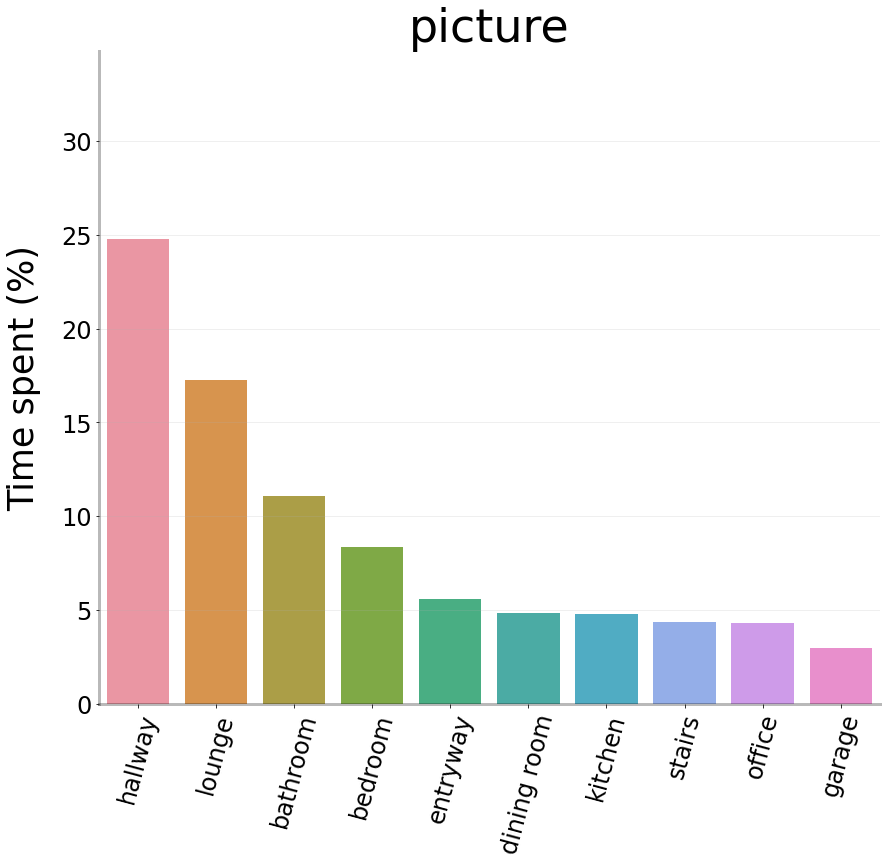

<Figure size 432x288 with 0 Axes>

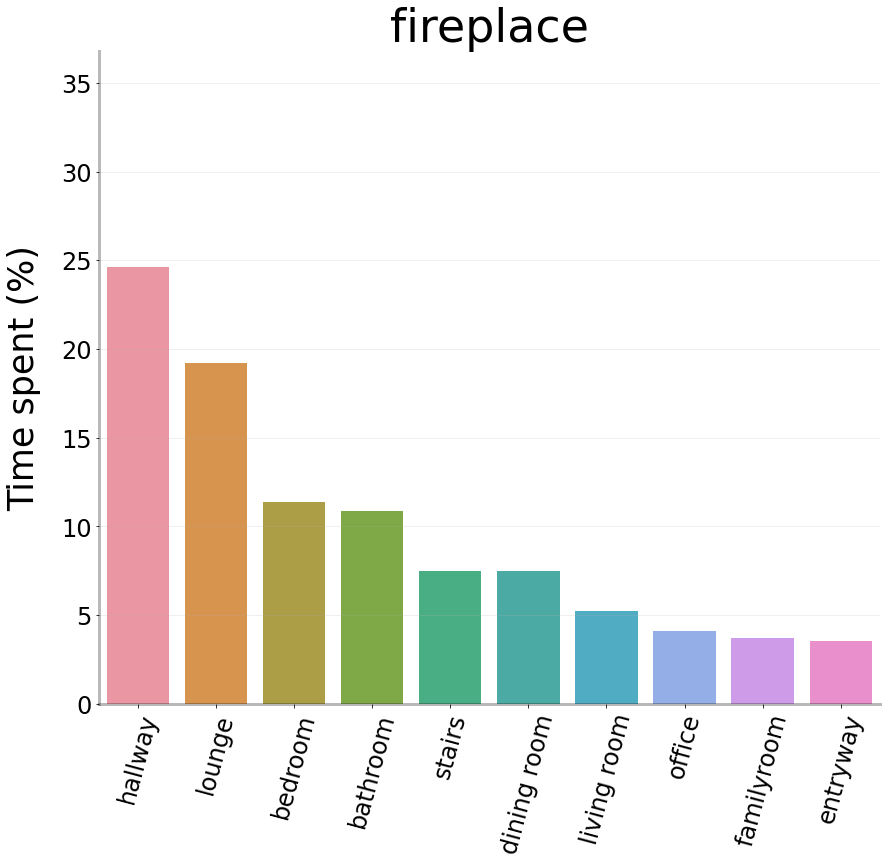

<Figure size 432x288 with 0 Axes>

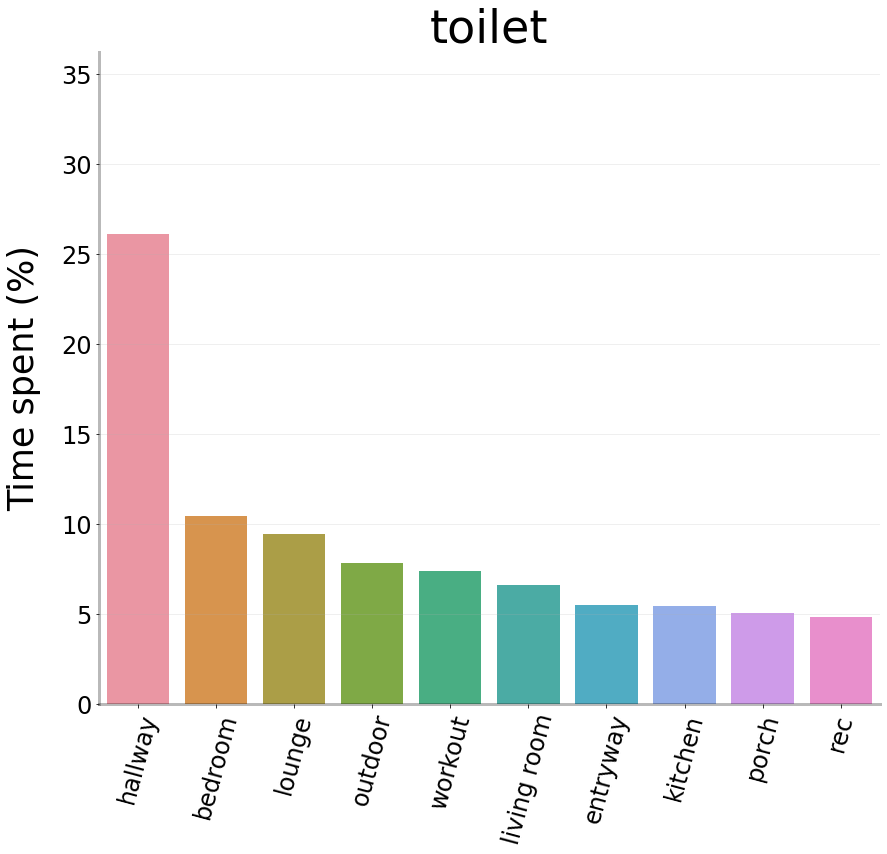

<Figure size 432x288 with 0 Axes>

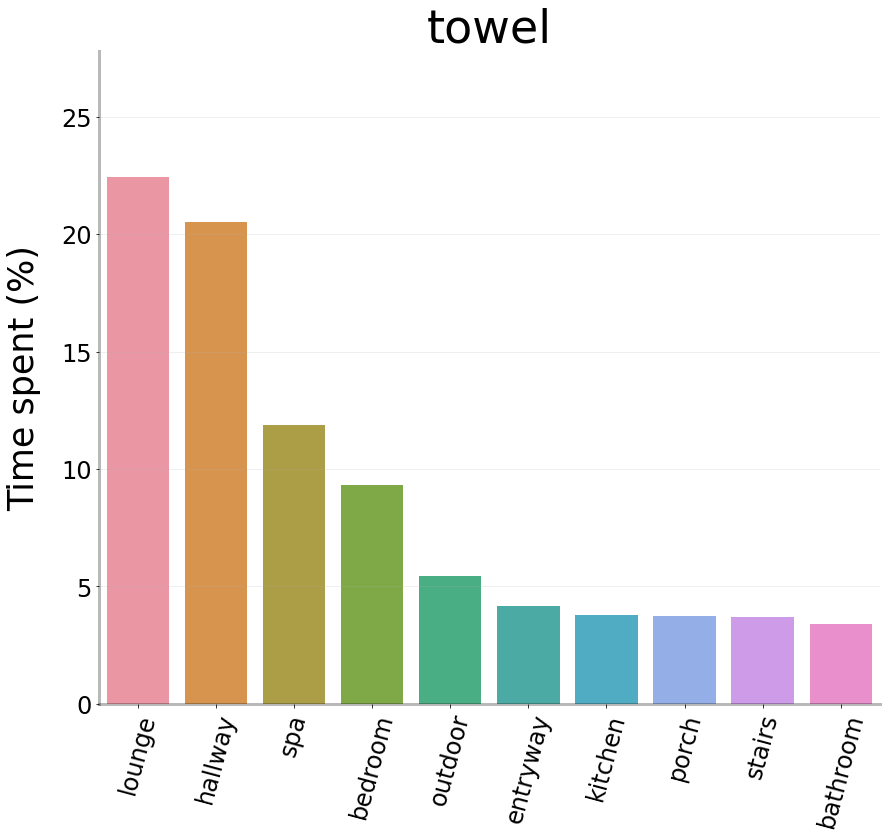

<Figure size 432x288 with 0 Axes>

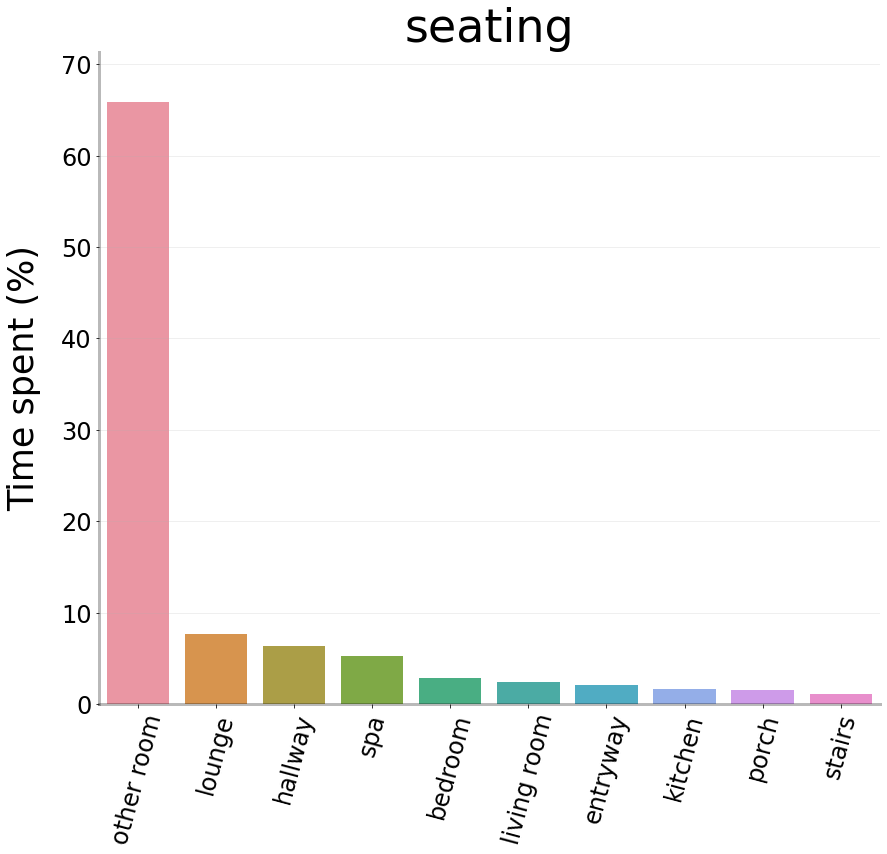

<Figure size 432x288 with 0 Axes>

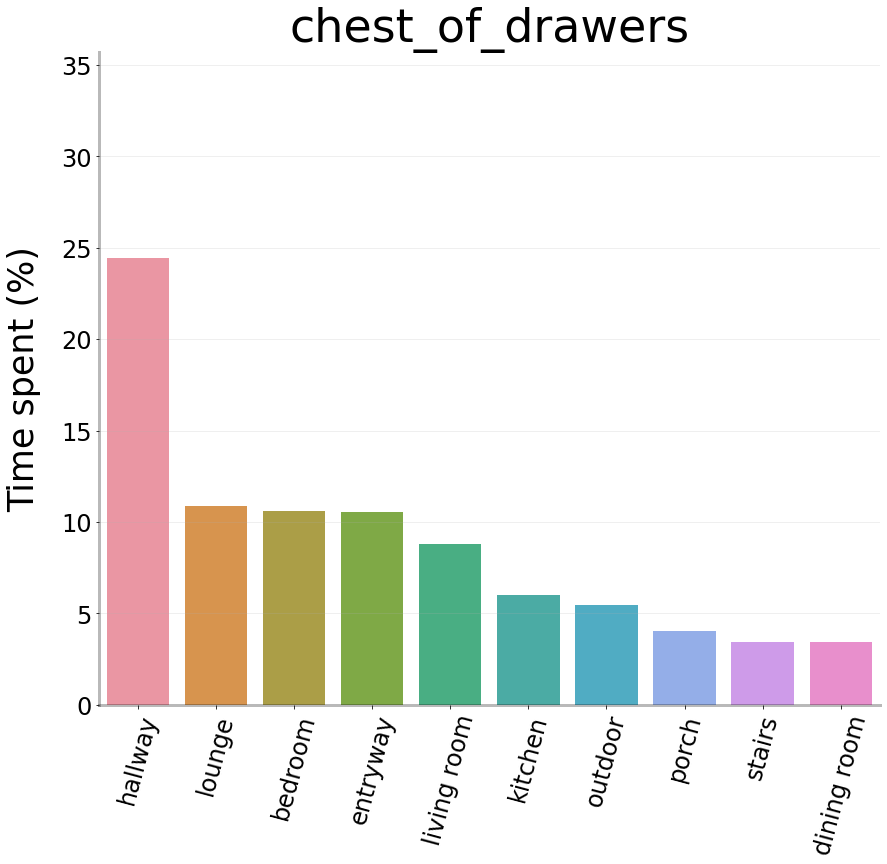

<Figure size 432x288 with 0 Axes>

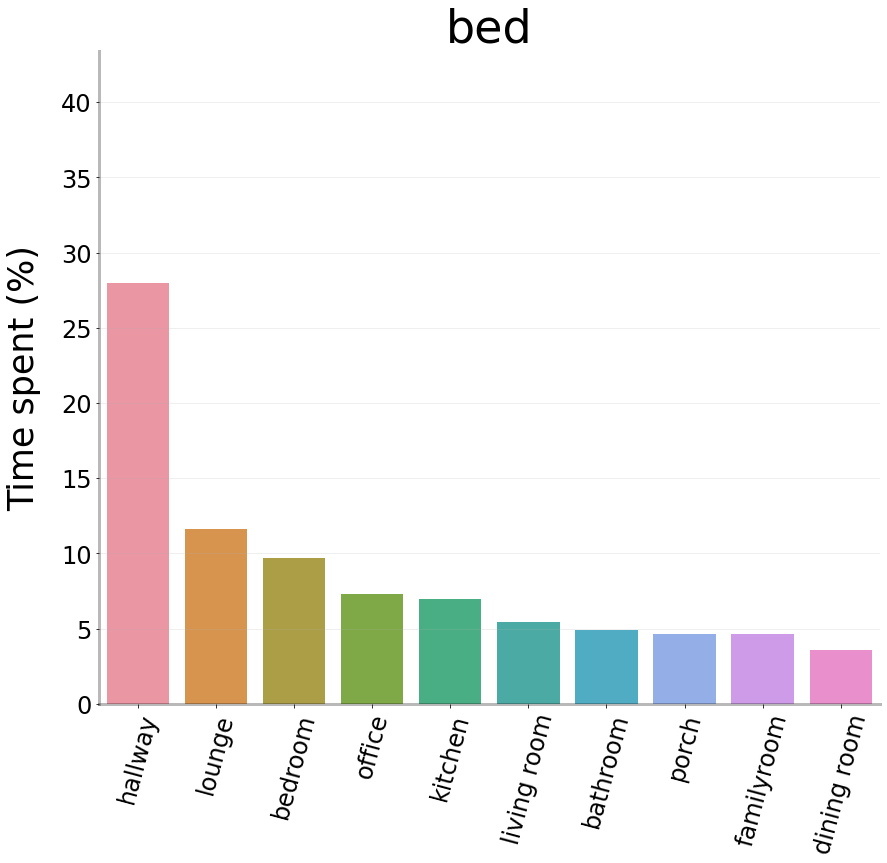

<Figure size 432x288 with 0 Axes>

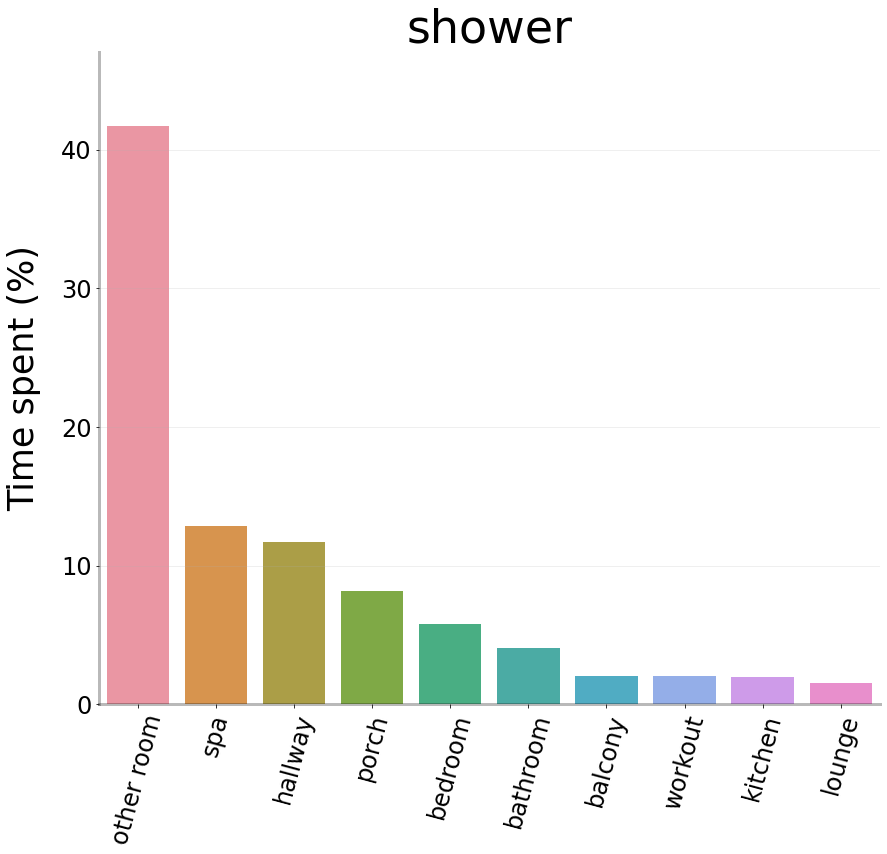

<Figure size 432x288 with 0 Axes>

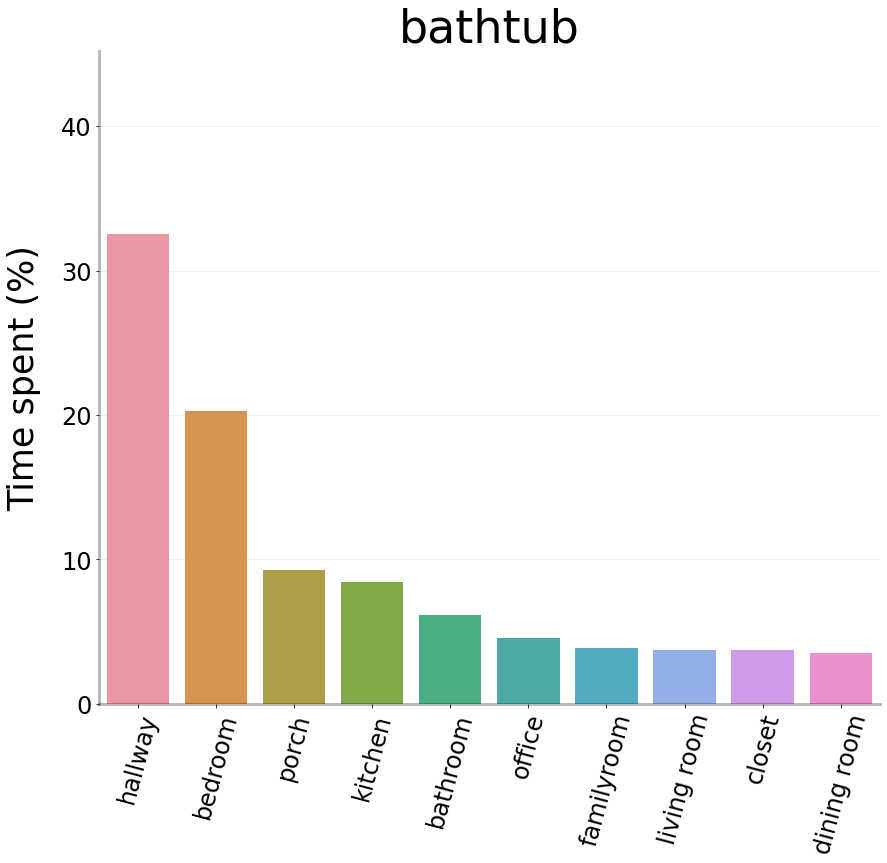

<Figure size 432x288 with 0 Axes>

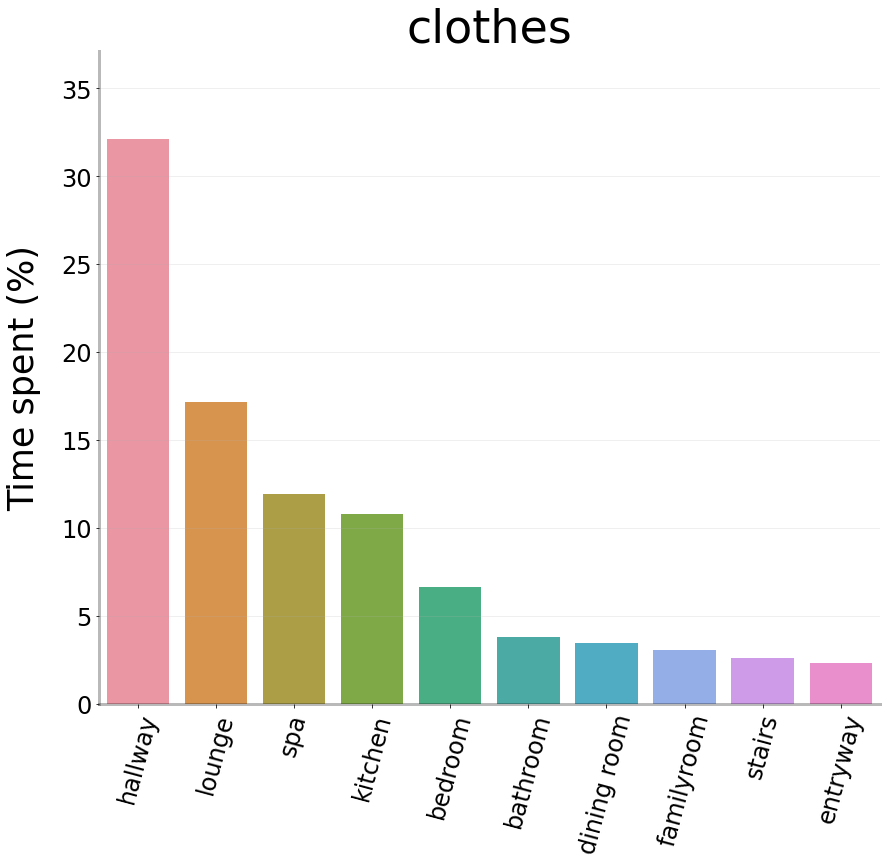

<Figure size 432x288 with 0 Axes>

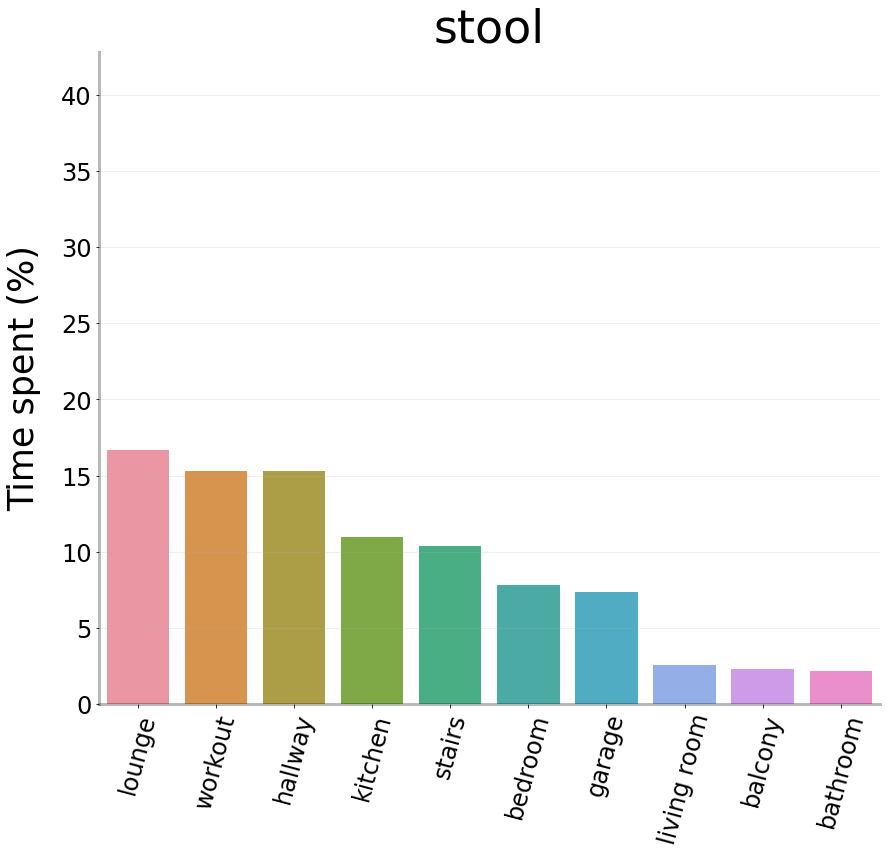

<Figure size 432x288 with 0 Axes>

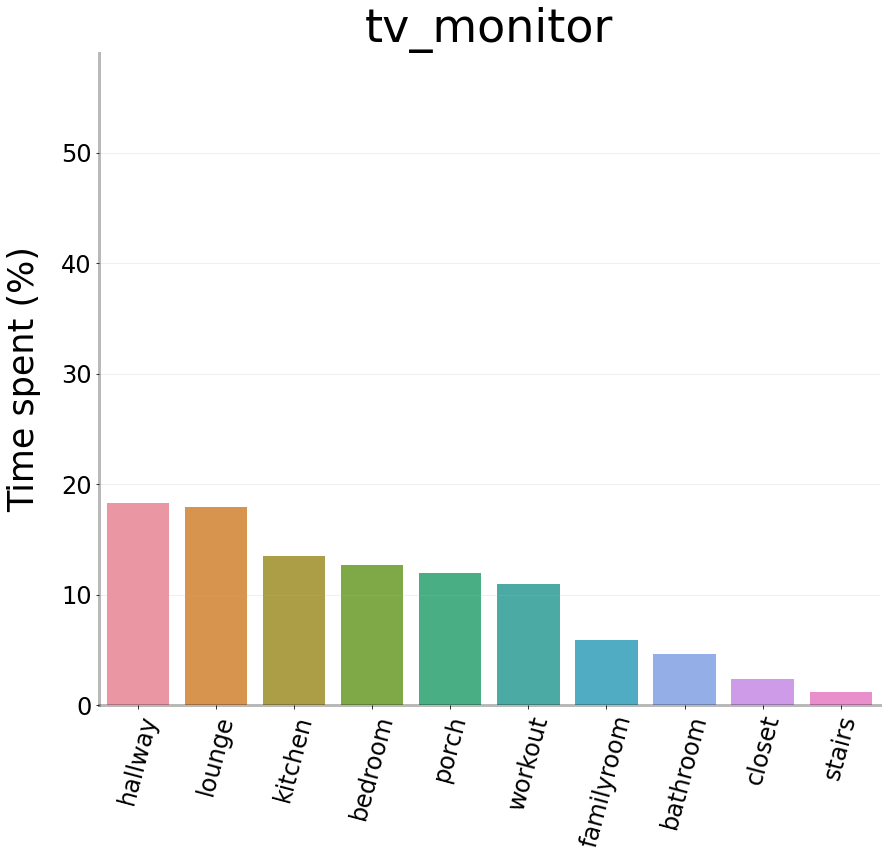

<Figure size 432x288 with 0 Axes>

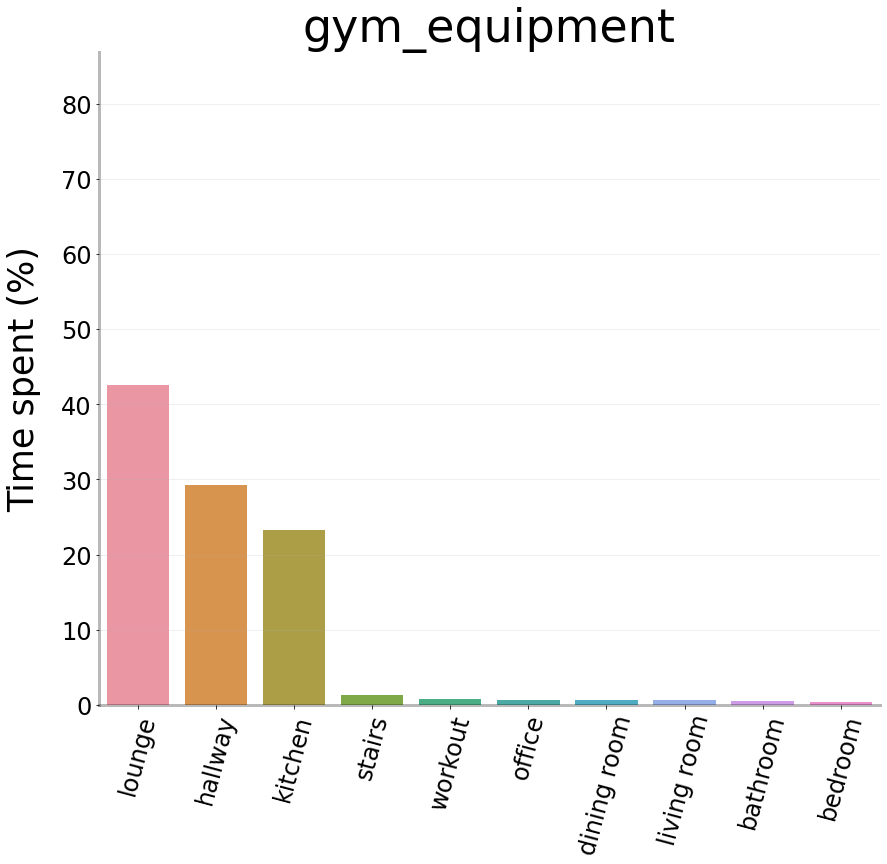

<Figure size 432x288 with 0 Axes>

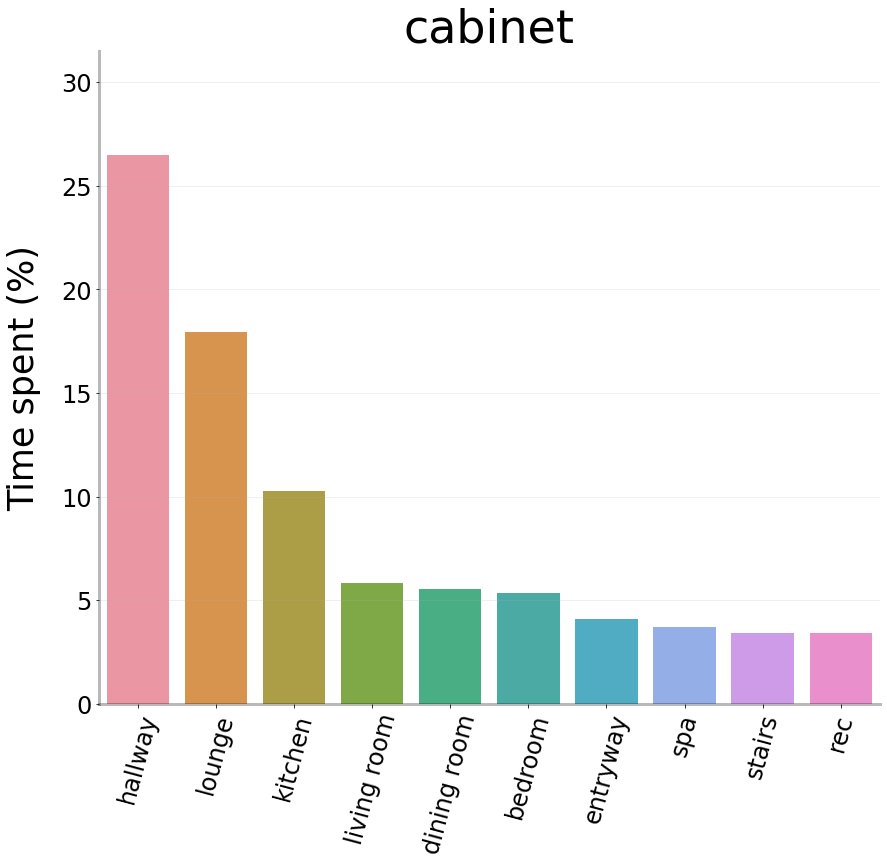

<Figure size 432x288 with 0 Axes>

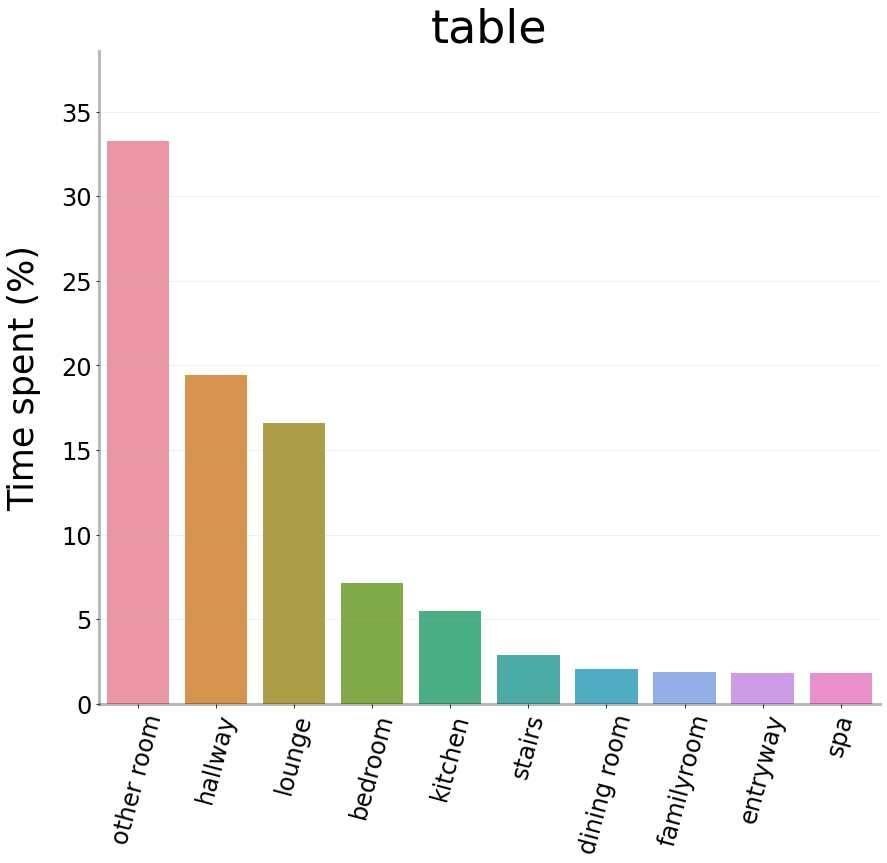

<Figure size 432x288 with 0 Axes>

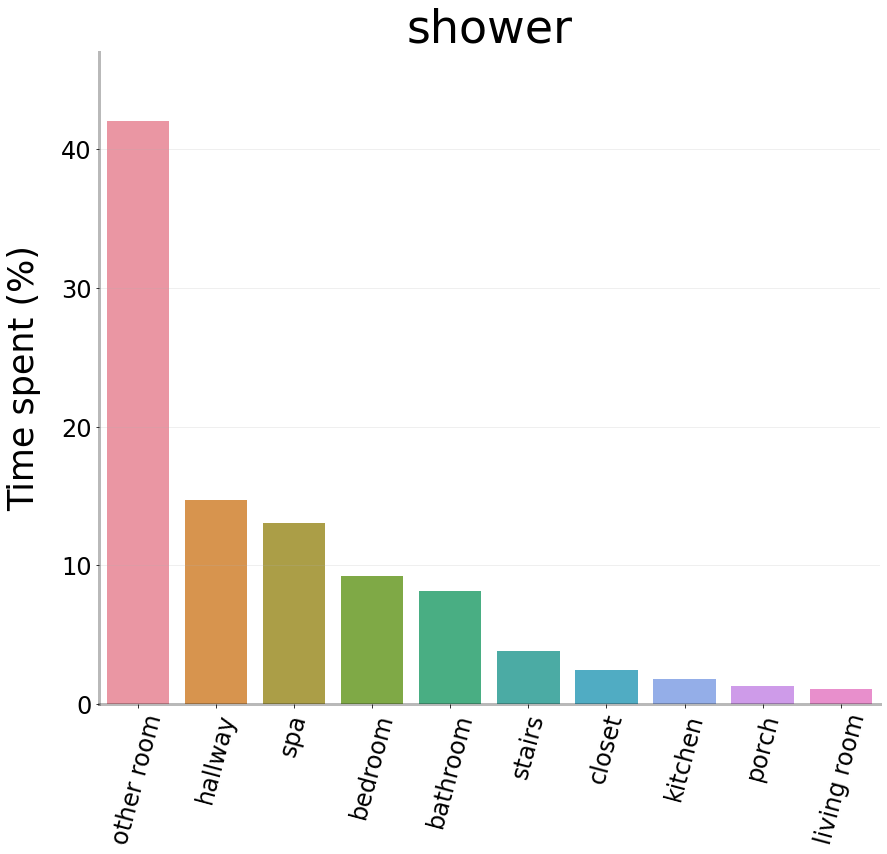

<Figure size 432x288 with 0 Axes>

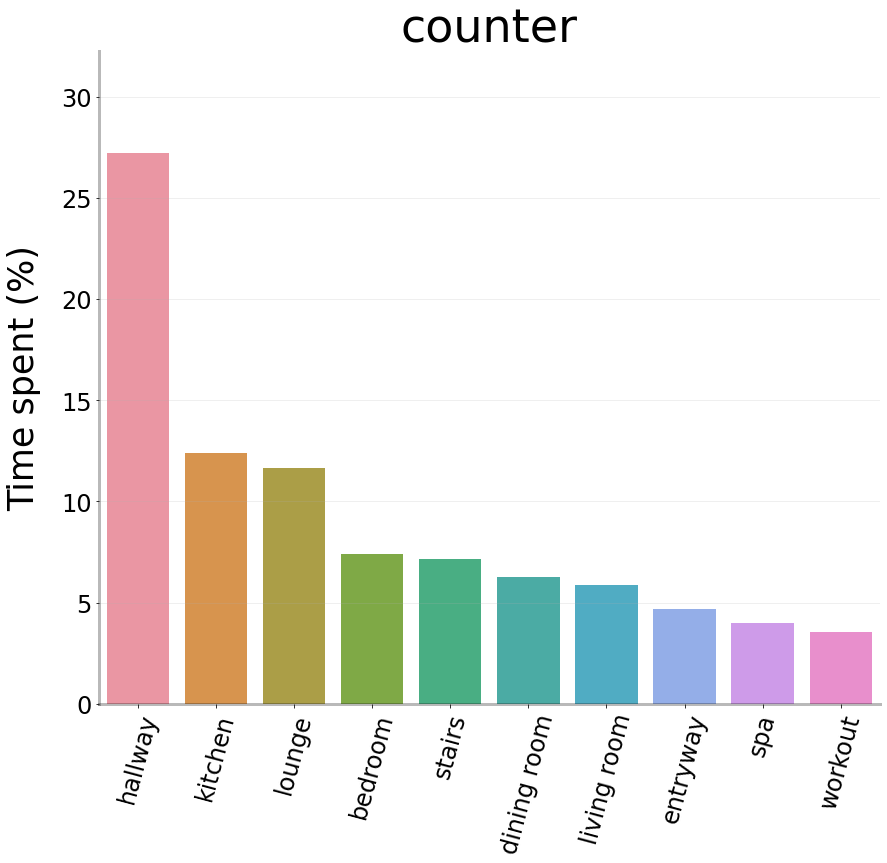

<Figure size 432x288 with 0 Axes>

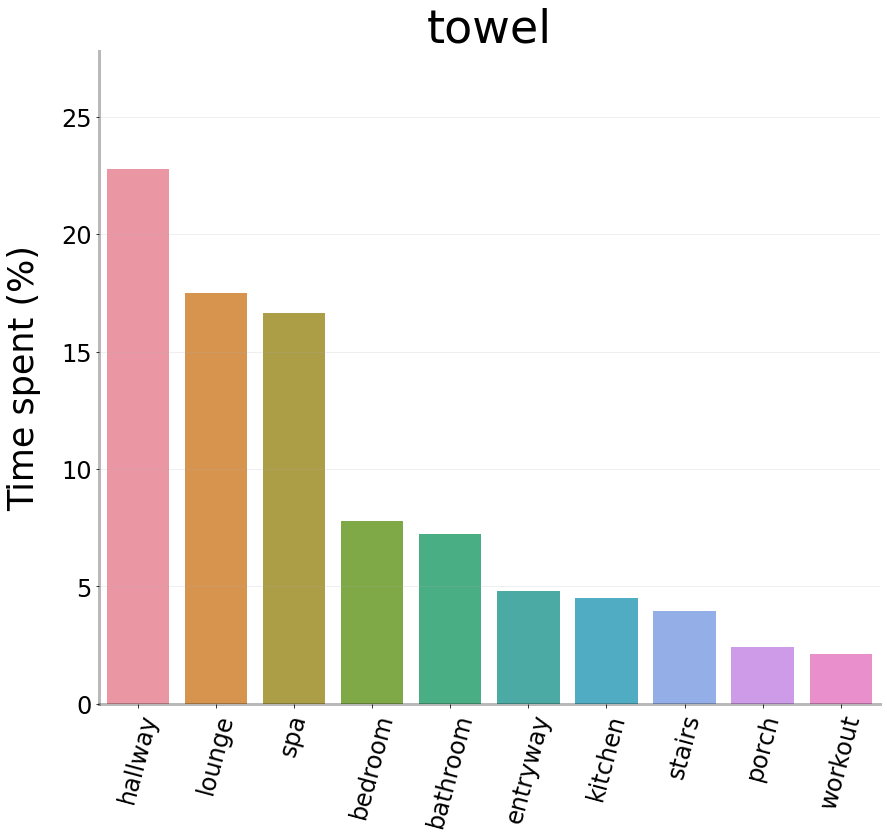

<Figure size 432x288 with 0 Axes>

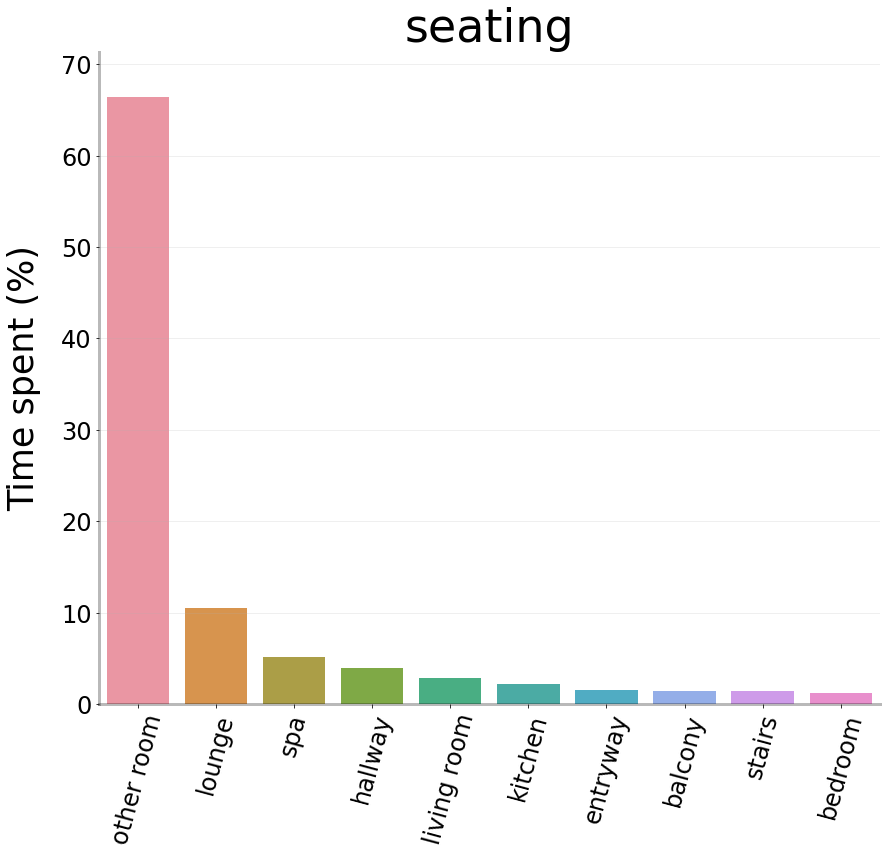

<Figure size 432x288 with 0 Axes>

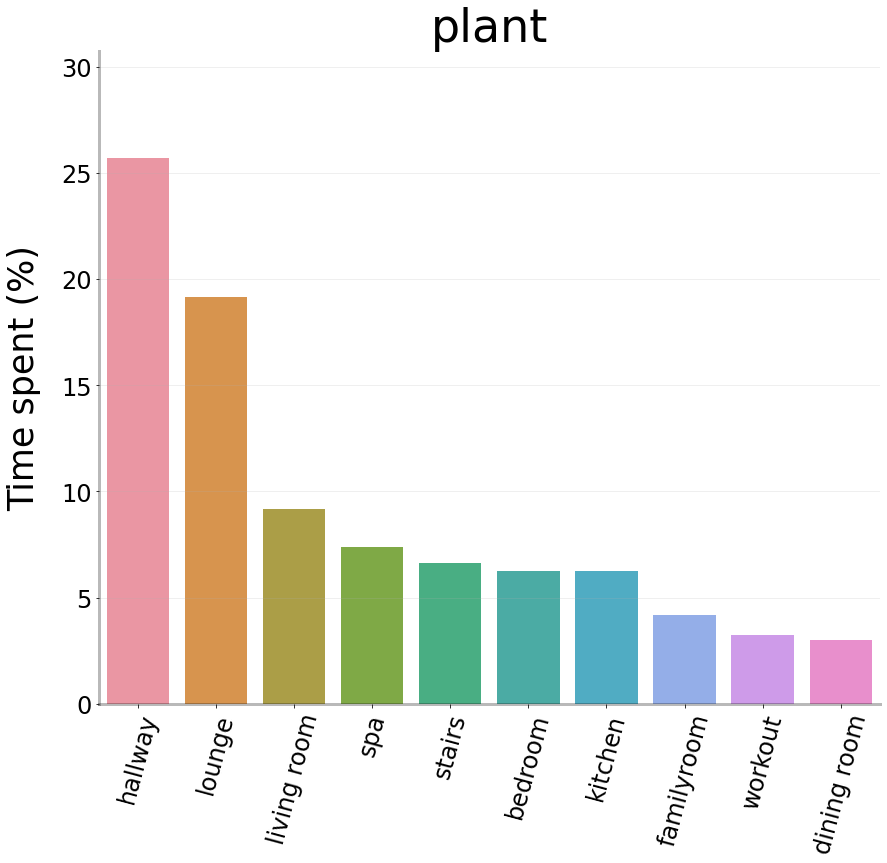

<Figure size 432x288 with 0 Axes>

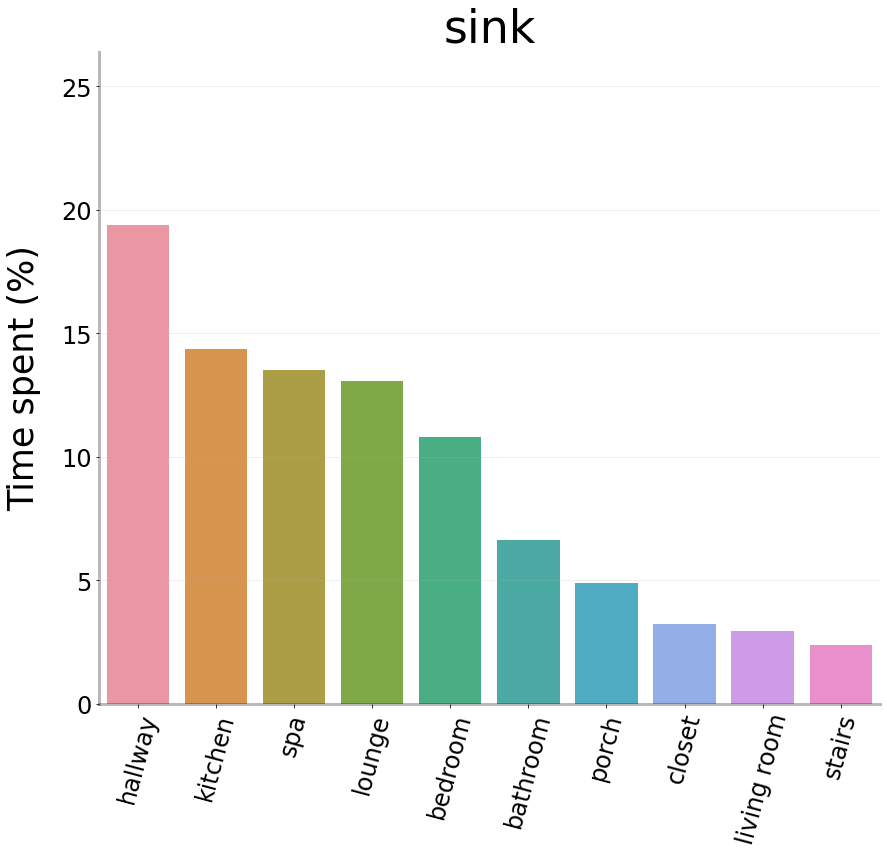

<Figure size 432x288 with 0 Axes>

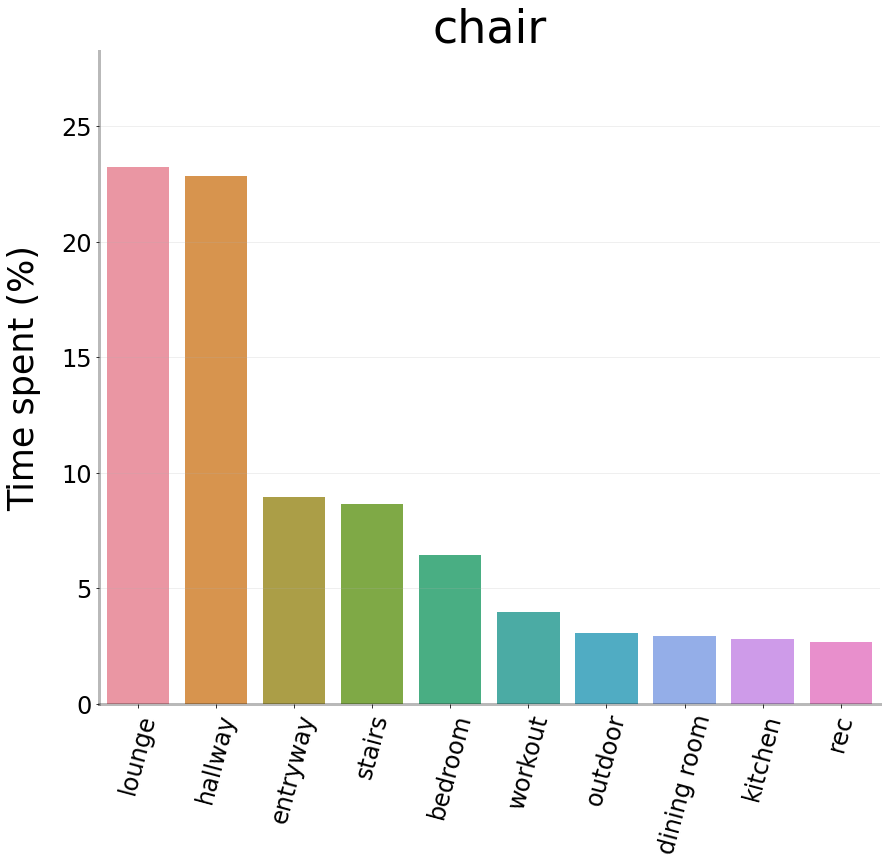

<Figure size 432x288 with 0 Axes>

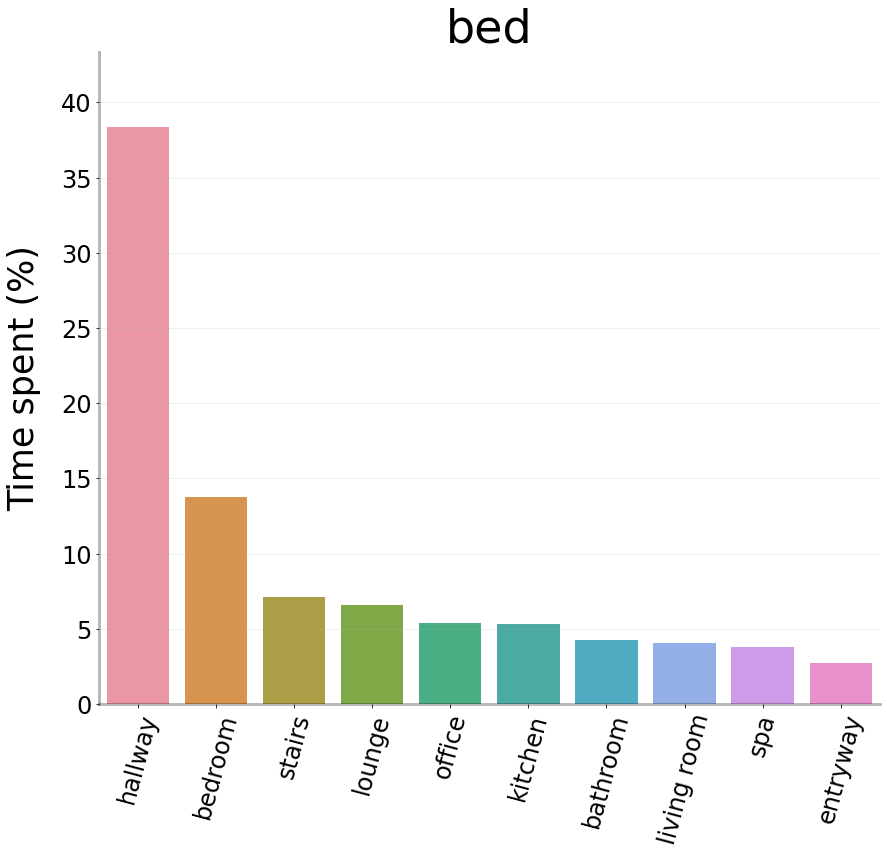

<Figure size 432x288 with 0 Axes>

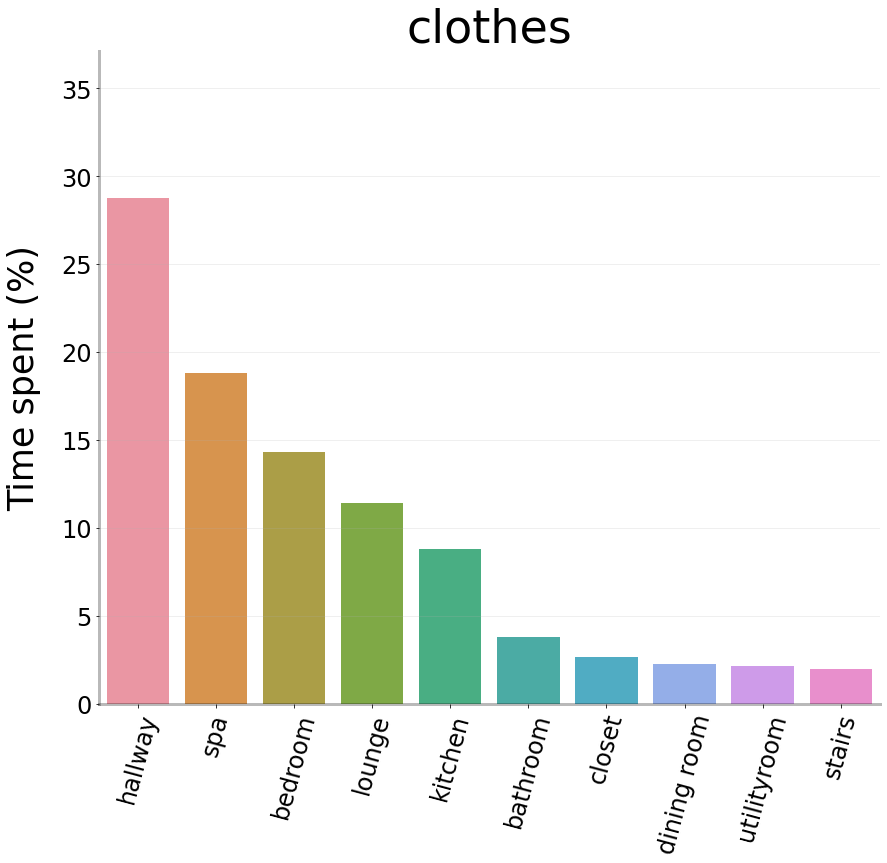

<Figure size 432x288 with 0 Axes>

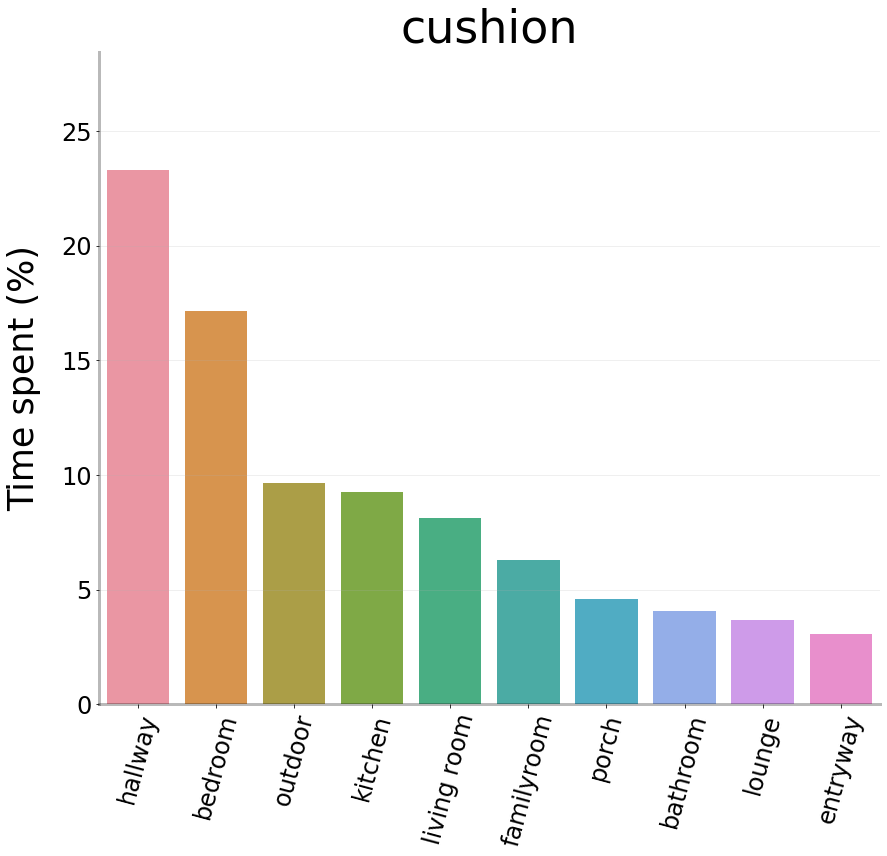

<Figure size 432x288 with 0 Axes>

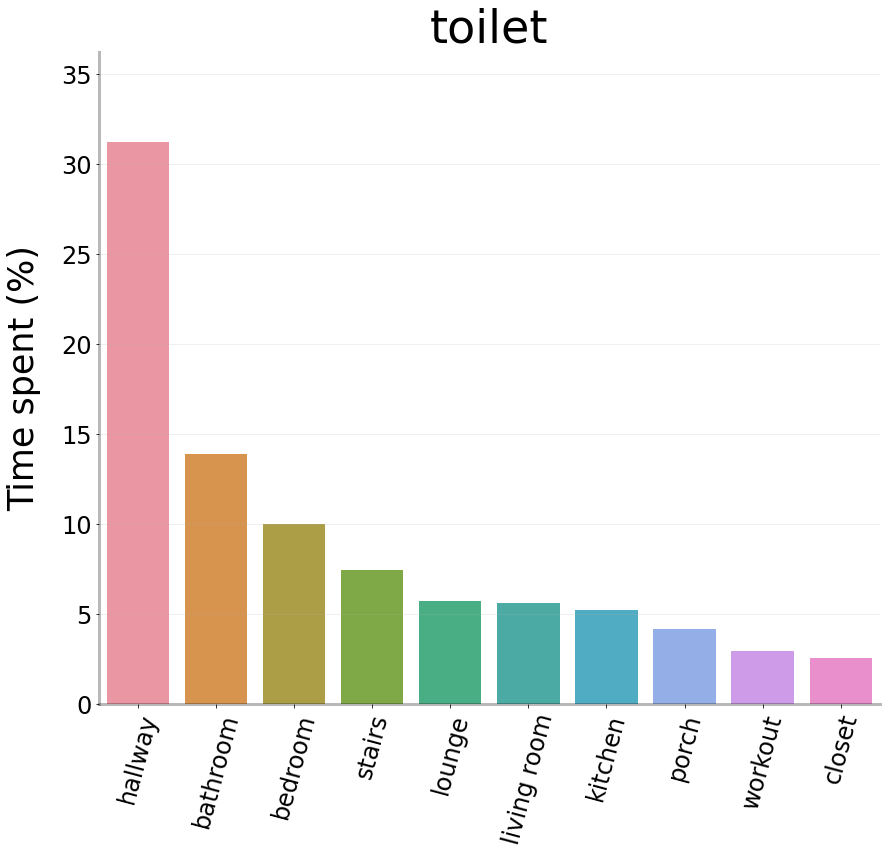

<Figure size 432x288 with 0 Axes>

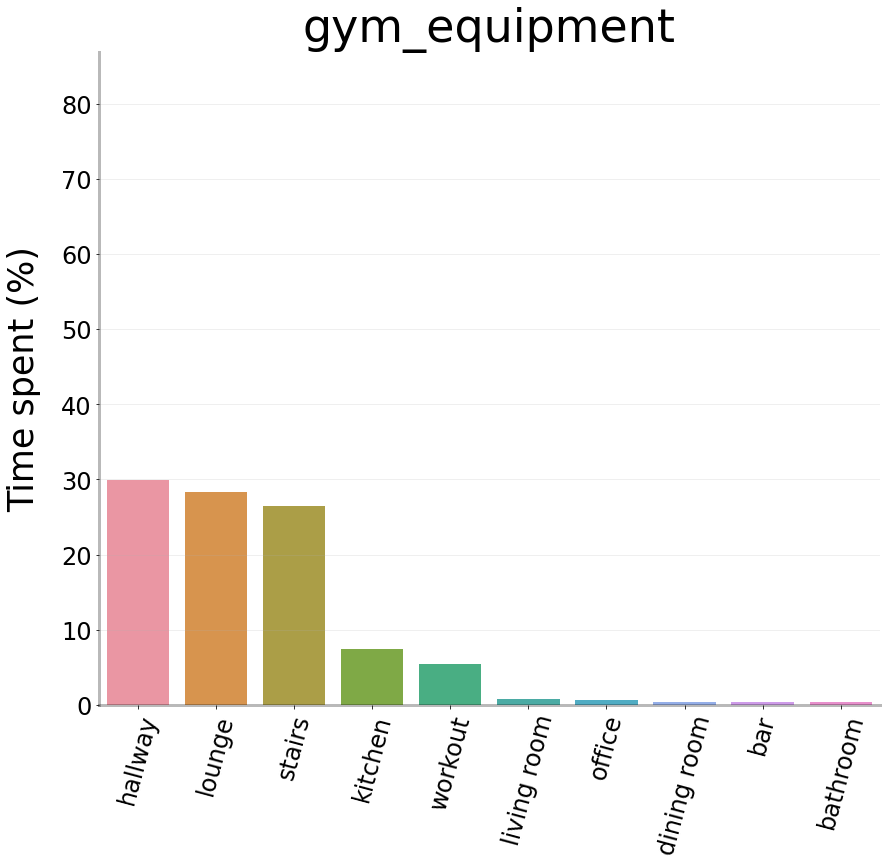

<Figure size 432x288 with 0 Axes>

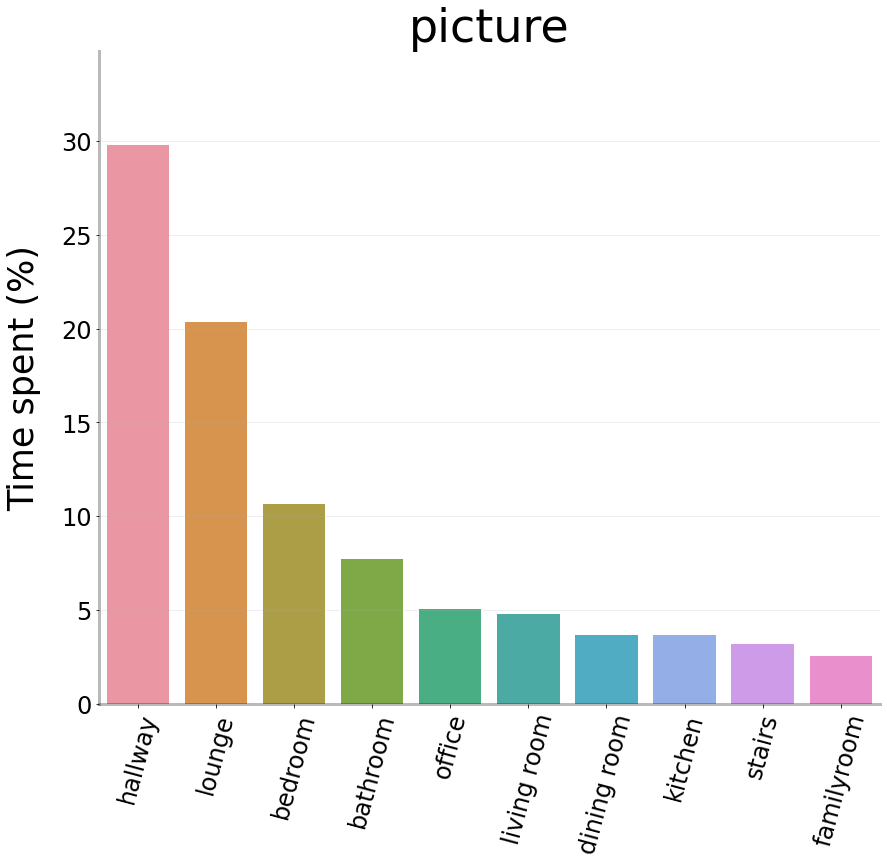

<Figure size 432x288 with 0 Axes>

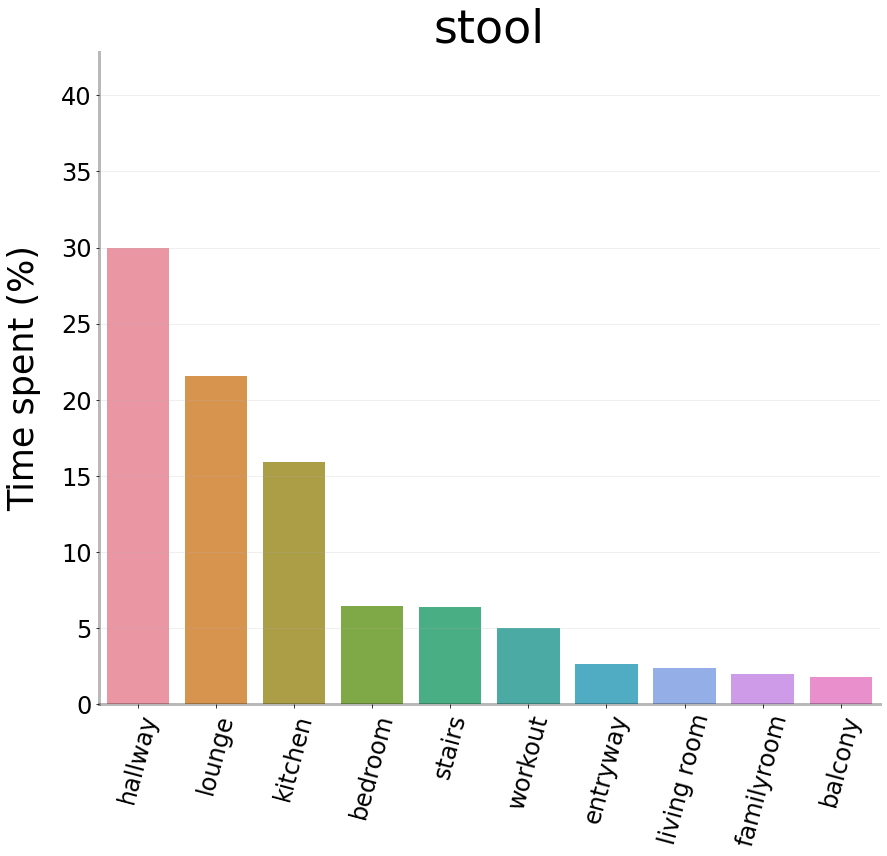

<Figure size 432x288 with 0 Axes>

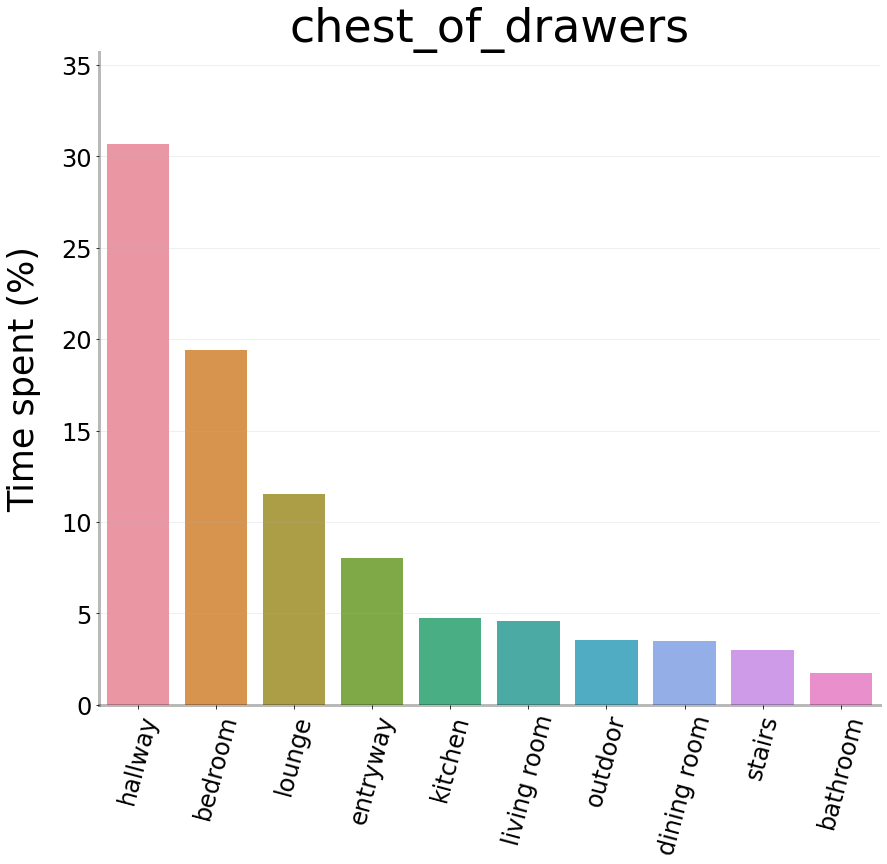

<Figure size 432x288 with 0 Axes>

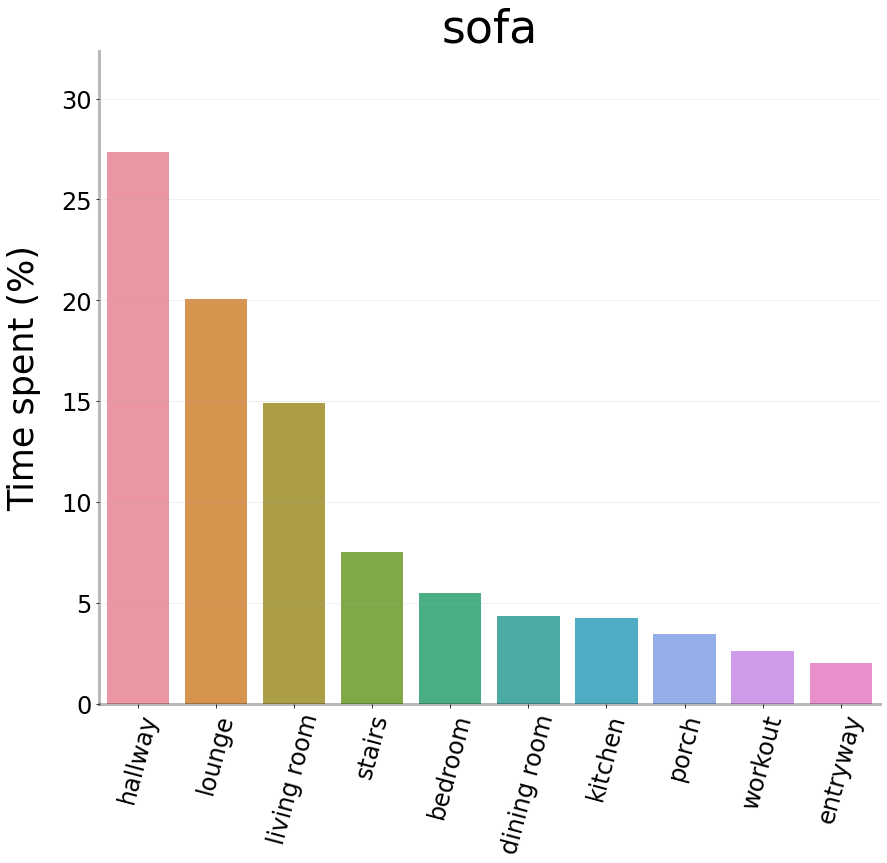

<Figure size 432x288 with 0 Axes>

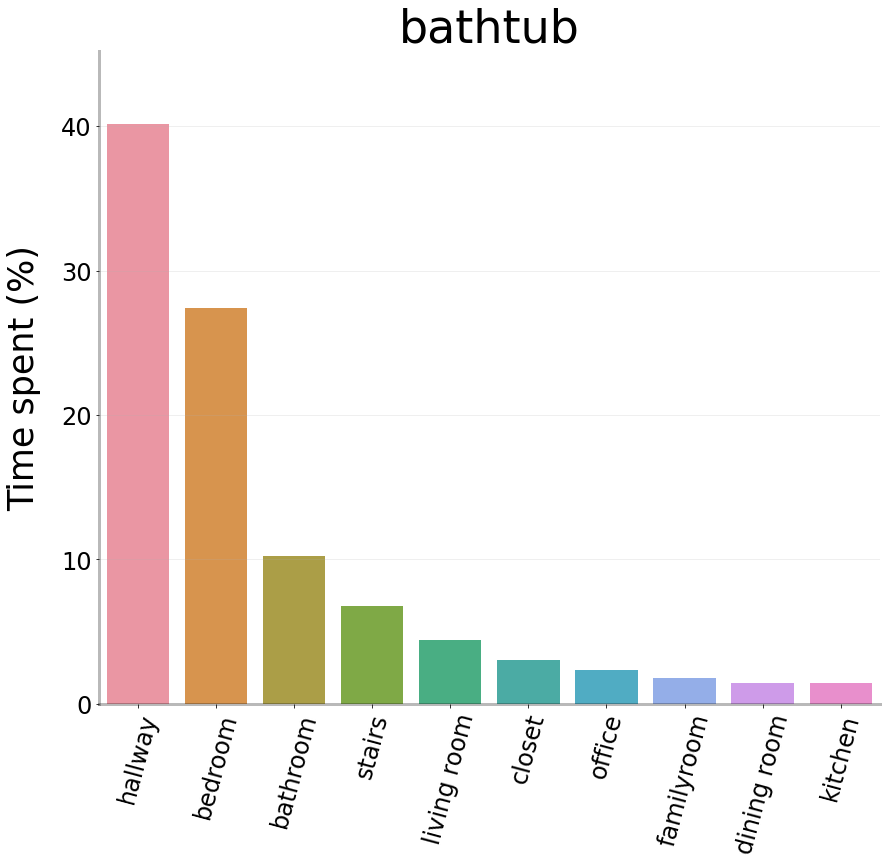

<Figure size 432x288 with 0 Axes>

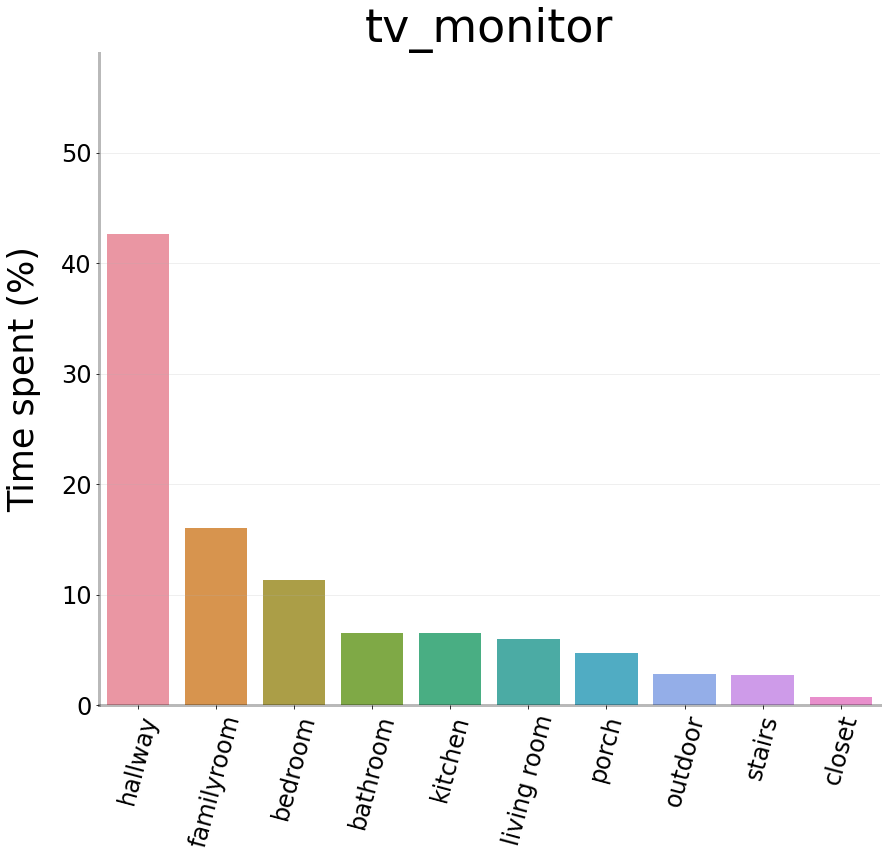

<Figure size 432x288 with 0 Axes>

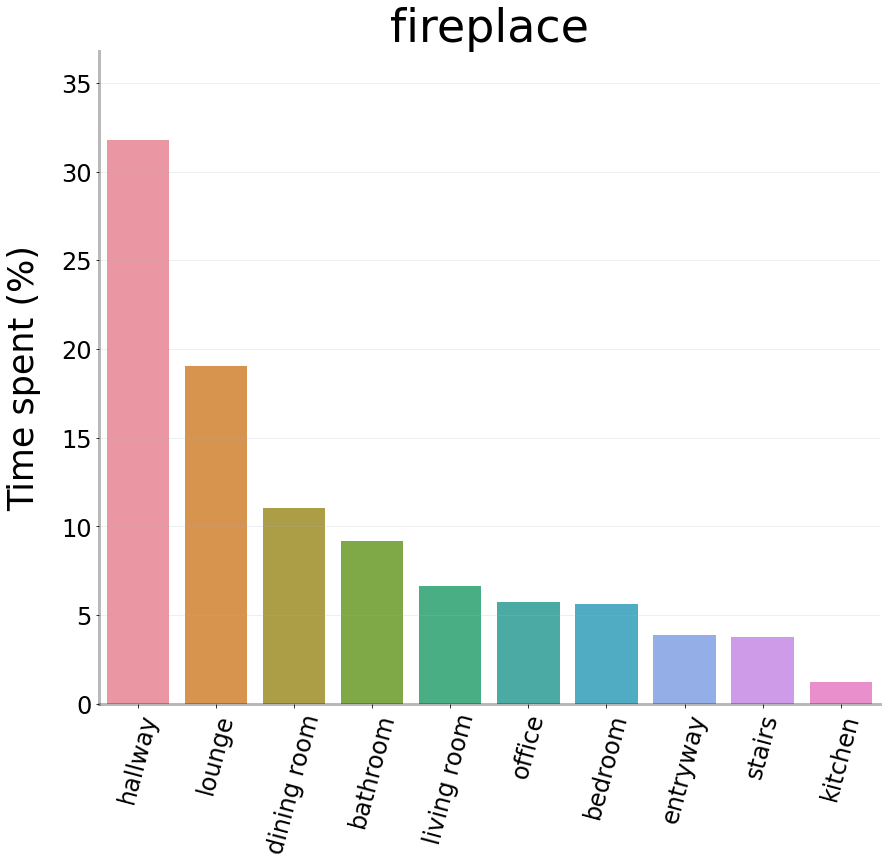

<Figure size 432x288 with 0 Axes>

In [19]:
per_object_ylim = defaultdict(int)
for key, value in variants_full.items():
    dataset = read_json(value)
    avg_success_per_scene, avg_success_per_goal, avg_time_spent_goal_room_per_scene, avg_time_per_room = pre_process_dataset(dataset)
    
    for object_category, time_per_room in avg_time_per_room.items():
        per_object_ylim[object_category] = max(per_object_ylim[object_category], max(time_per_room.values()))

for key, value in variants_full.items():
    dataset = read_json(value)
    avg_success_per_scene, avg_success_per_goal, avg_time_spent_goal_room, avg_time_per_room = pre_process_dataset(dataset)
    
    # plot per goal room time spent
    
    for object_category, time_spent_room_map in avg_time_per_room.items():
        fig, axs = plt.subplots(1, 1, figsize=(14, 12))
#         if len(time_spent_room_map.keys()) > 10:
#             fig, axs = plt.subplots(1, 1, figsize=(12, 12))
        
        if len(time_spent_room_map.keys()) > 10:
            sorted_a = sorted(time_spent_room_map, key=time_spent_room_map.get)
            for i in range(len(time_spent_room_map.keys()) - 10):
                del time_spent_room_map[sorted_a[i]]

        fig_dims = (12, 12)
        prep_plt(ax=axs)
        y_lim = per_object_ylim[object_category] * 100
        
        values = list(time_spent_room_map.values())
        for i in range(len(values)):
            values[i] = values[i] * 100
        rooms = list(time_spent_room_map.keys())
        rooms = [r.split("/")[0] for r in rooms]

        plot_barplot(
            rooms, values,
            x_label="", y_label="Time spent (%)", ax=axs, x_rotation=75, color_palette=palette_dict, y_lim=y_lim + 5, title=object_category
        )
        #plt.show()
        output_path = os.path.join(variant_output_path[key], "{}_{}_RTS.jpg".format(object_category, key))
        fig.savefig(output_path, dpi=40, bbox_inches="tight", pad_inches=0.1, transparent=False)


### Goal room time spent per scene

1502
1597
7
1502
key -- RL
RL 11
1597
key -- IL
IL 11
7
key -- Human
['2azQ1b91cZZ', '8194nk5LbLH', 'EU6Fwq7SyZv', 'QUCTc6BB5sX', 'TbHJrupSAjP', 'X7HyMhZNoso', 'Z6MFQCViBuw', 'oLBMNvg9in8', 'pLe4wQe7qrG', 'x8F5xyUWy9e', 'zsNo4HB9uLZ']
Text(0, 0, '8194nk5LbLH')
Text(1, 0, 'TbHJrupSAjP')
Text(2, 0, 'X7HyMhZNoso')
Text(3, 0, '2azQ1b91cZZ')
Text(4, 0, 'oLBMNvg9in8')
Text(5, 0, 'QUCTc6BB5sX')
Text(6, 0, 'Z6MFQCViBuw')
Text(7, 0, 'EU6Fwq7SyZv')
Text(8, 0, 'pLe4wQe7qrG')
Text(9, 0, 'x8F5xyUWy9e')
Text(10, 0, 'zsNo4HB9uLZ')
figures/objectnav/per_scene_goal_room_time_spent.jpg


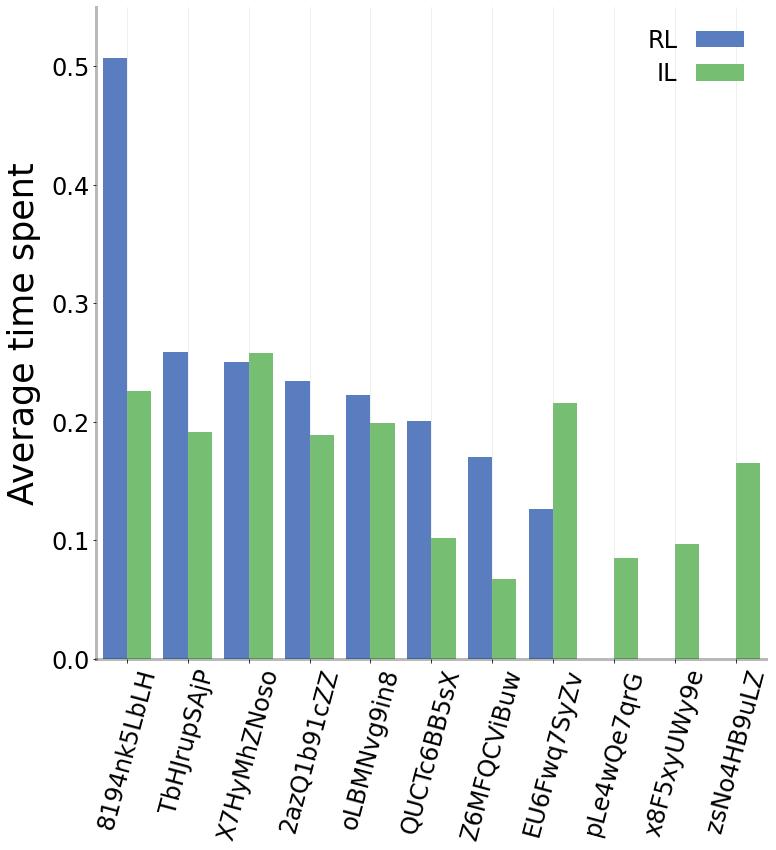

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
per_object_ylim = defaultdict(int)
for key, value in variants_full.items():
    dataset = read_json(value)
    avg_success_per_scene, avg_success_per_goal, avg_time_spent_goal_room_per_scene, avg_time_per_room = pre_process_dataset(dataset)

    for object_category, time_per_room in avg_time_per_room.items():
        per_object_ylim[object_category] = max(per_object_ylim[object_category], max(time_per_room.values()))

        
fig, axs = plt.subplots(1, 1, figsize=(12, 12))

fig_dims = (12, 12)
prep_plt(ax=axs)

dset = {
    "scenes": [],
    "time_spent": [],
    "variant": []
}
for key, value in variants_full.items():
    dataset = read_json(value)
    avg_success_per_scene, avg_success_per_goal, avg_time_spent_goal_room_per_scene, avg_time_per_room = pre_process_dataset(dataset)
    
    keys = sorted(list(avg_time_spent_goal_room_per_scene.keys()))
    print("key -- " + key)
    if key == "Human":
        continue
    if key == "RL":
        key = "RL"
    else:
        key = "IL"
    variants = [key] * len(keys)
    dset["scenes"].extend(keys)
    dset["time_spent"].extend(list(avg_time_spent_goal_room_per_scene.values()))
    dset["variant"].extend([key] * len(keys))
    print(key, len(keys))
    #print(len(keys), len(list(avg_time_spent_goal_room_per_scene.values())), ln)

y_lim = 0.55
#print(avg_time_spent_goal_room_per_scene.keys())
#print(scene_palette_dict)
sorted_keys = sorted(list(avg_time_spent_goal_room_per_scene.keys()))
print(sorted_keys)
# sorted_keys = ["X7HyMhZNoso", "8194nk5LbLH", "EU6Fwq7SyZv", "oLBMNvg9in8", "2azQ1b91cZZ", "zsNo4HB9uLZ",
#                "TbHJrupSAjP", ""]
sorted_keys = ["8194nk5LbLH", "TbHJrupSAjP", "X7HyMhZNoso", "2azQ1b91cZZ", "oLBMNvg9in8", "QUCTc6BB5sX",
               "Z6MFQCViBuw", "EU6Fwq7SyZv", "pLe4wQe7qrG", "x8F5xyUWy9e", "zsNo4HB9uLZ"]
dset = pd.DataFrame.from_dict(dset)


plot_mbarplot(
    dset, "scenes", "time_spent", "variant",
    x_label="", y_label="Average time spent", ax=axs, x_rotation=75, color_palette=scene_palette_dict, y_lim=y_lim, order=sorted_keys
)
#plt.show()


output_path = os.path.join("figures/objectnav/", "per_scene_goal_room_time_spent.jpg")
print(output_path)
fig.savefig(output_path, dpi=100, bbox_inches="tight", pad_inches=0.1, transparent=False)


### Super Human Humans

In [19]:
def plot_histogram(dataset, key, ax, bins): #, path, legend, y_label, x_label, ax, xlim, x_interval, y_interval, title, bins):
    print(len(dataset[key]))
    ax = sns.distplot(dataset[key], bins=bins, kde=False, hist=True, ax=ax, kde_kws={"bw_adjust": 1, "linewidth":4}, hist_kws={"alpha": 0.6}) #, label=legend)
    # g = sns.histplot(dataset[key], binwidth=50, kde=False, ax=ax, alpha= 0.6, label=legend)
#     ax.set_xlim(0, xlim)

    # ax.set_title(title)
    ax.set_xlabel(x_label, labelpad=10, fontsize=22)
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(x_interval))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(y_interval))
    
#     for _,s in ax.spines.items():
#         s.set_color('black')
#         s.set_alpha(0.8)
#         s.set_linewidth(1)

    #sns.despine(ax=ax)

#     ax.spines['bottom'].set_color('0.1')
#     ax.spines['top'].set_color('0.1')
#     ax.spines['right'].set_color('0.1')
#     ax.spines['left'].set_color('0.1')

#     ax.spines['bottom'].set_color('0.0')
#     ax.spines['top'].set_color('0.0')
#     ax.spines['right'].set_color('0.0')
#     ax.spines['left'].set_color('0.0')
#     ax.spines['left'].set_linewidth(3)
#     ax.spines['right'].set_linewidth(3)
#     ax.spines['top'].set_linewidth(3)
#     ax.spines['bottom'].set_linewidth(3)
    
    ax.legend(markerfirst=False, ncol=1, frameon=False, labelspacing=0.4)

In [20]:
dataset = read_json("../data/stats/objectnav/evaluation_meta/human_full_merged.json")

for ep in dataset:
    ep["spl"] = ep["metrics"]["spl"]
    ep["success"] = ep["metrics"]["success"]
    ep["softspl"] = ep["metrics"]["softspl"]
    ep["distance_to_goal"] = ep["metrics"]["distance_to_goal"]
    ep["worker_id"] = ep["episode_id"].split(":")[0]
    del ep["metrics"]


In [21]:
df = pd.DataFrame(dataset)
df.head()

scene_id  \
0  data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkb...   
1  data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkb...   
2  data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkb...   
3  data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkb...   
4  data/scene_datasets/mp3d/p5wJjkQkbXX/p5wJjkQkb...   

                                      episode_id   object_category       spl  \
0  A2OFN0A5CPLH57:3W92K5RLWWKO96TKTFQMGE7GMJ0V5D           seating  0.184578   
1  A2Q6L9LKSNU7EB:3EJJQNKU9T88WSWYLXML4EL47UYHRQ           bathtub  0.229185   
2  A3FSDH6HUZPNQ8:3H7XDTSHKEUZ4SI90LE96DHKXJMWGS           cabinet  0.503670   
3   AZPZDX26SYMFY:3LS2AMNW5HTIC83LCVSBJX8032EOQK             table  0.430717   
4   AEWGY34WUIA32:3J2UYBXQQNF4Z9SIV1C2NRVR2AL60Z  chest_of_drawers  0.166252   

   success   softspl  distance_to_goal       worker_id  
0      1.0  0.183028          0.057689  A2OFN0A5CPLH57  
1      1.0  0.228692          0.046767  A2Q6L9LKSNU7EB  
2      1.0  0.502742          0.019249  A3FSDH6HUZPNQ8  
3      1.0  0.427205          0.064291   AZPZDX26SYMFY  
4      1.0  0.165747          0.069822   AEWGY34WUIA32

In [22]:

group_df = df.groupby("worker_id")[["success", "spl"]].mean()
group_df = group_df.reset_index().sort_values(by="spl", ascending=False)

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


figures/objectnav/spl_per_worker.jpg


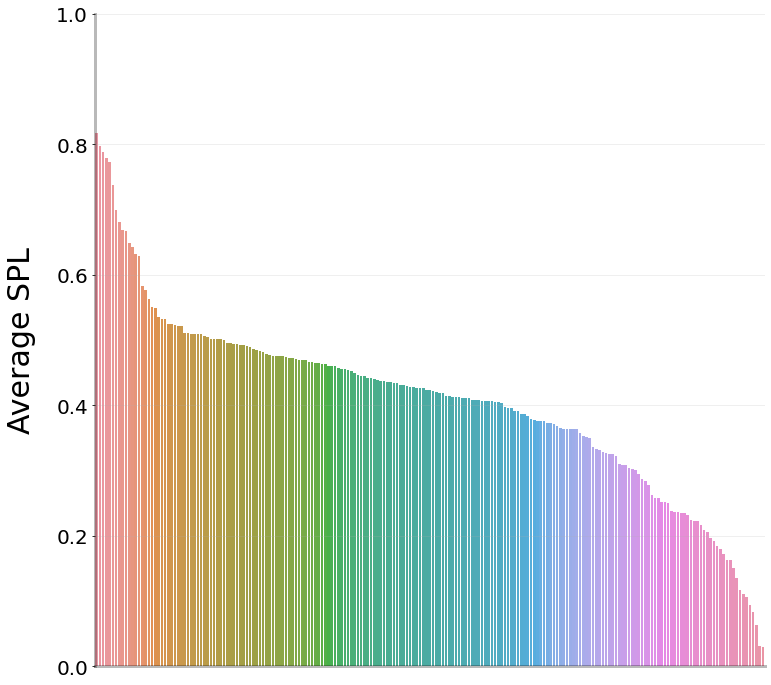

<Figure size 432x288 with 0 Axes>

In [23]:

fig, axs = plt.subplots(1, 1, figsize=(12, 12))

fig_dims = (12, 12)
prep_plt(ax=axs)


plot_barplot(
    group_df["worker_id"].values, group_df["spl"].values,
    x_label="", y_label="Average SPL", ax=axs, x_rotation=75, y_lim=1, title=""
)
#plt.show()


output_path = os.path.join("figures/objectnav/", "spl_per_worker.jpg")
print(output_path)
fig.savefig(output_path, dpi=100, bbox_inches="tight", pad_inches=0.1, transparent=False)


(205, 3)


TypeError: plot_histogram() got an unexpected keyword argument 'title'

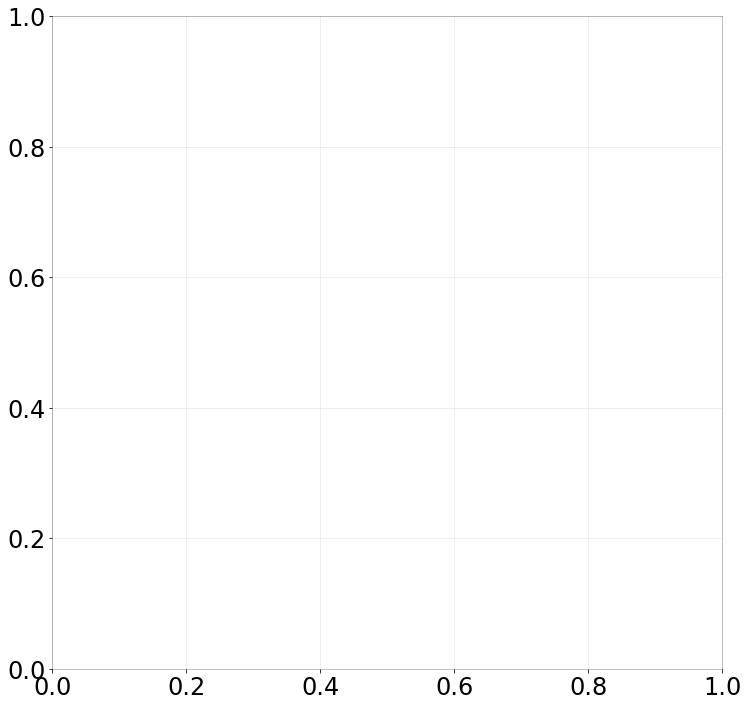

<Figure size 432x288 with 0 Axes>

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))

fig_dims = (12, 12)
prep_plt(ax=axs)

print(group_df.shape)
plot_histogram(
    group_df,
    key="spl",
    title="",
    x
    ax=axs,
    bins=10
)
fig.savefig("figures/spl_hist.png", dpi=100, bbox_inches="tight", transparent=False)


### Per object success

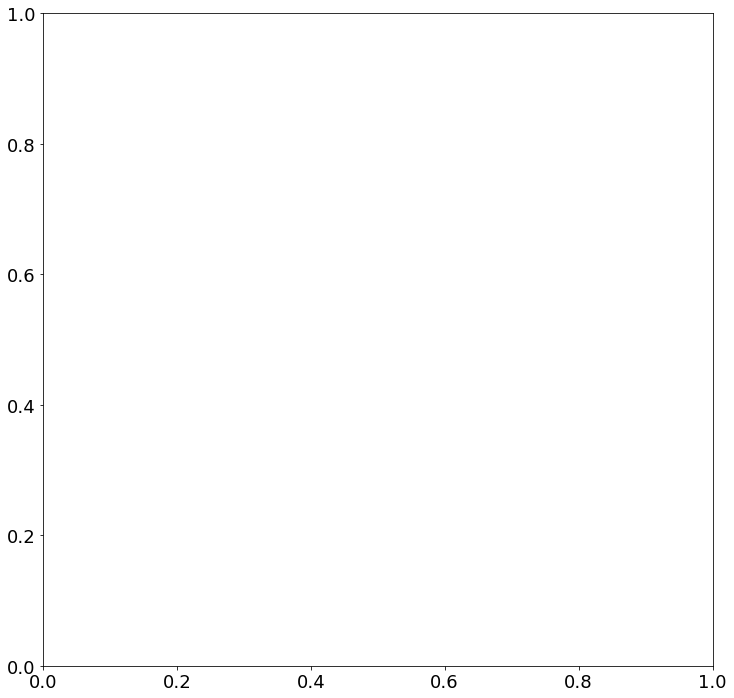

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))

fig_dims = (12, 12)

In [37]:
plot_barplot(
    list(avg_success_per_goal.keys()), list(avg_success_per_goal.values()),
    x_label="Goals", y_label="Average success", ax=axs, x_rotation=75
)

StopIteration: 

In [123]:
plt.show()
fig.savefig("figures/objectnav/objectnav_il/per_goal_success.jpg", dpi=100, bbox_inches="tight", pad_inches=0.1, transparent=False)

### Per scene success

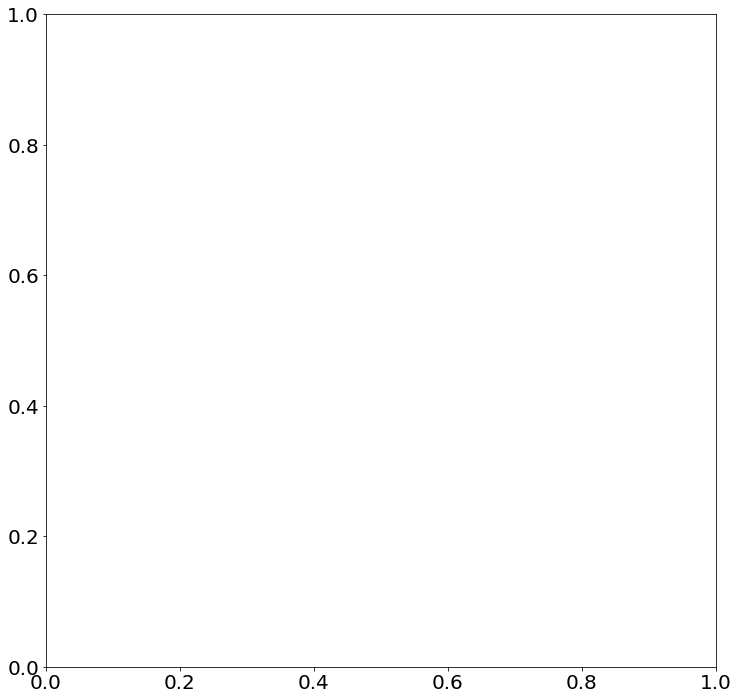

In [124]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))

fig_dims = (12, 12)

In [125]:
plot_barplot(
    list(avg_success_per_scene.keys()), list(avg_success_per_scene.values()),
    x_label="Scene", y_label="Average success", ax=axs, x_rotation=75
)

In [126]:
plt.show()
fig.savefig("figures/objectnav/objectnav_il/per_scene_success.jpg", dpi=100, bbox_inches="tight", pad_inches=0.1, transparent=False)

### Time spent per room per object category

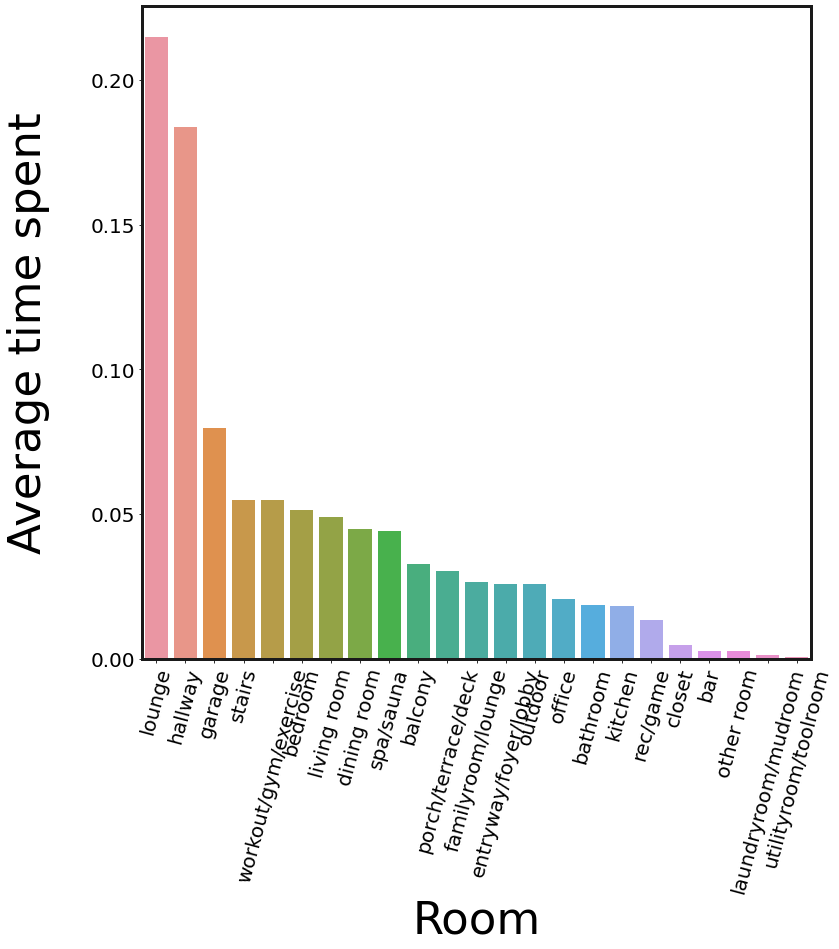

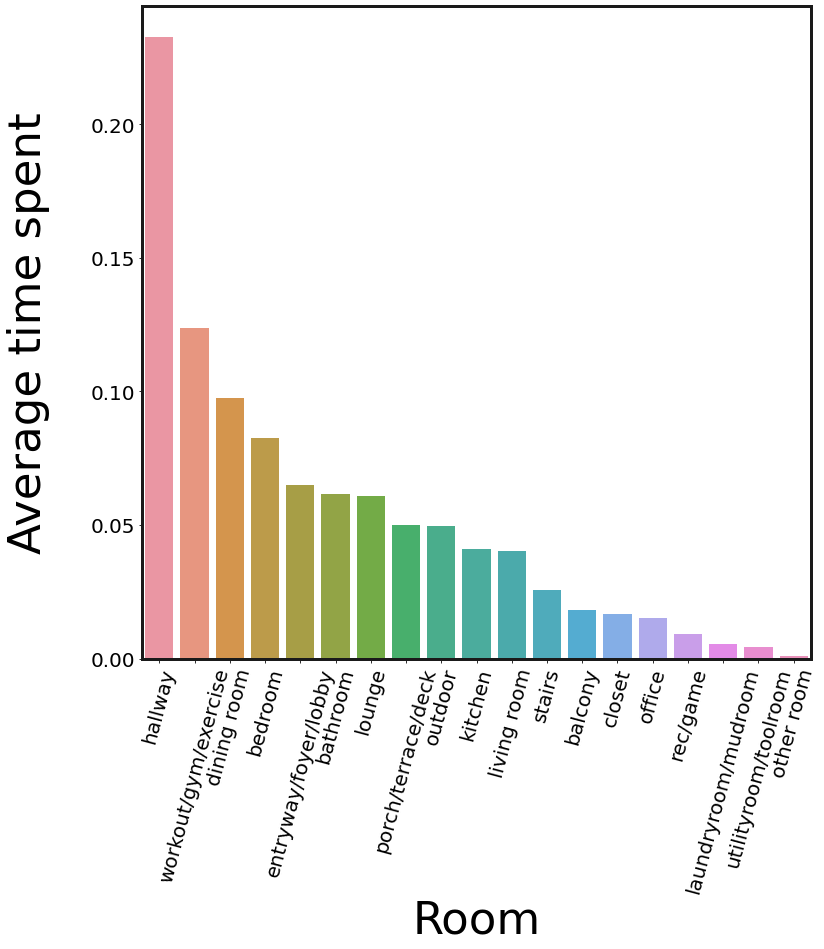

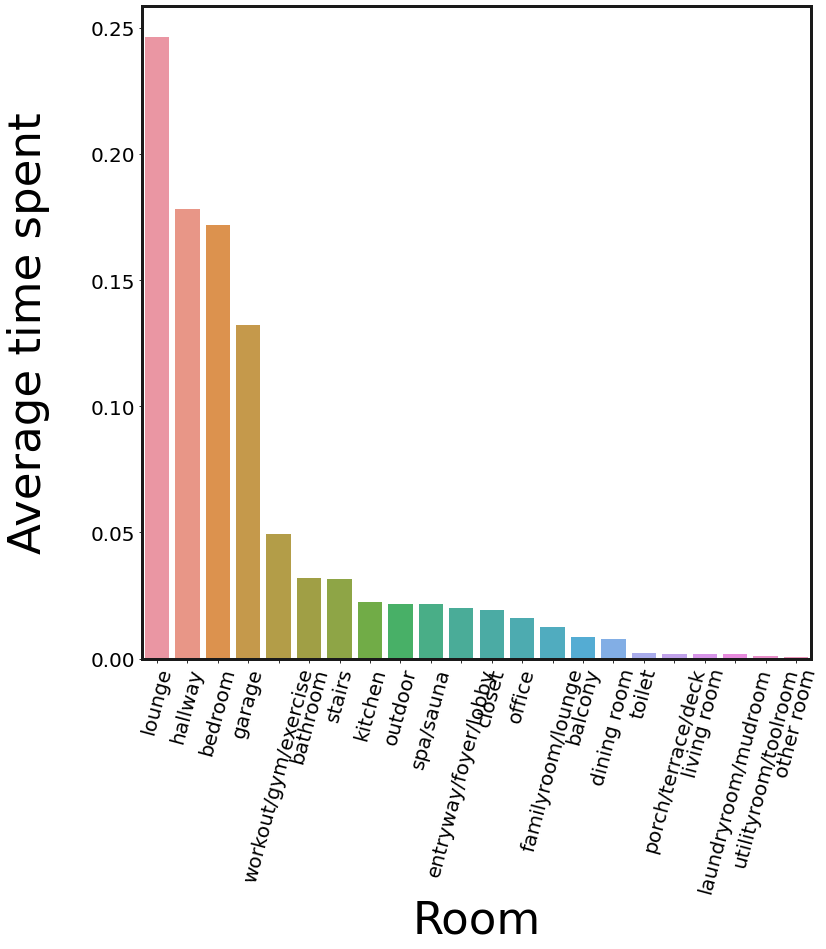

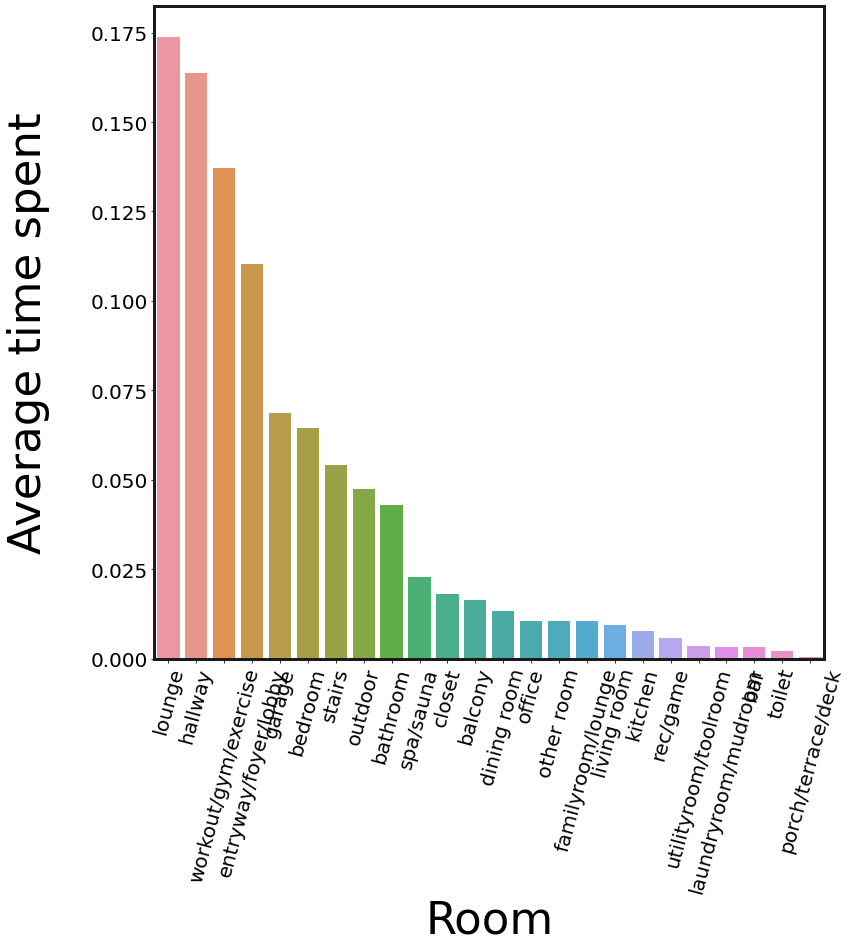

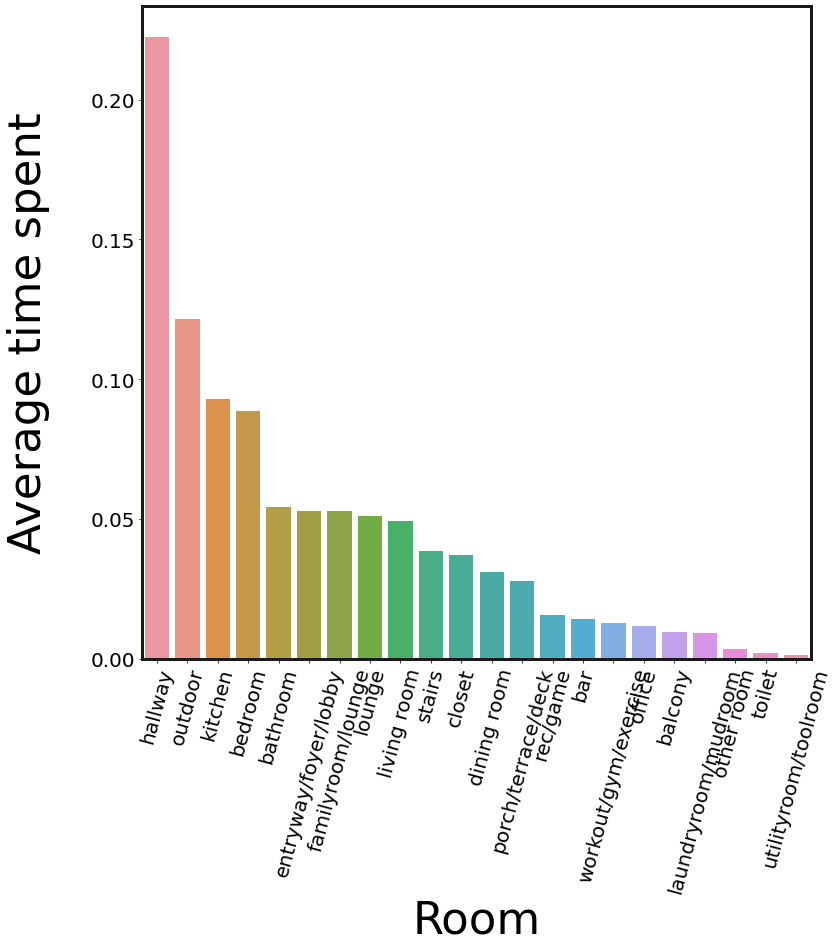

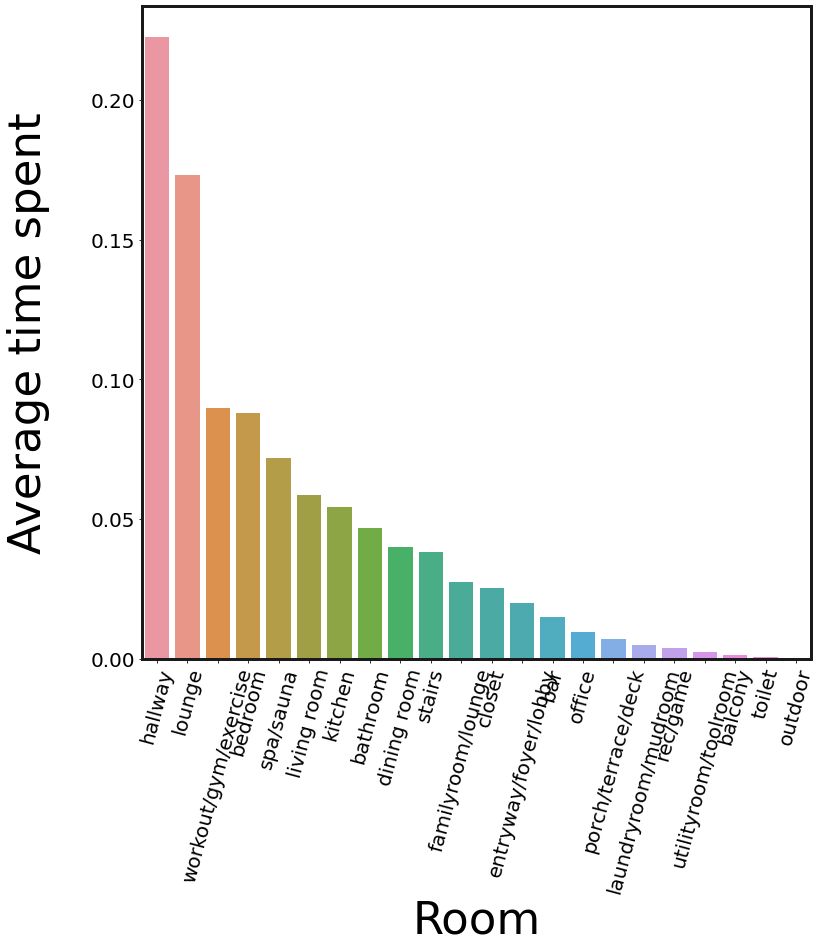

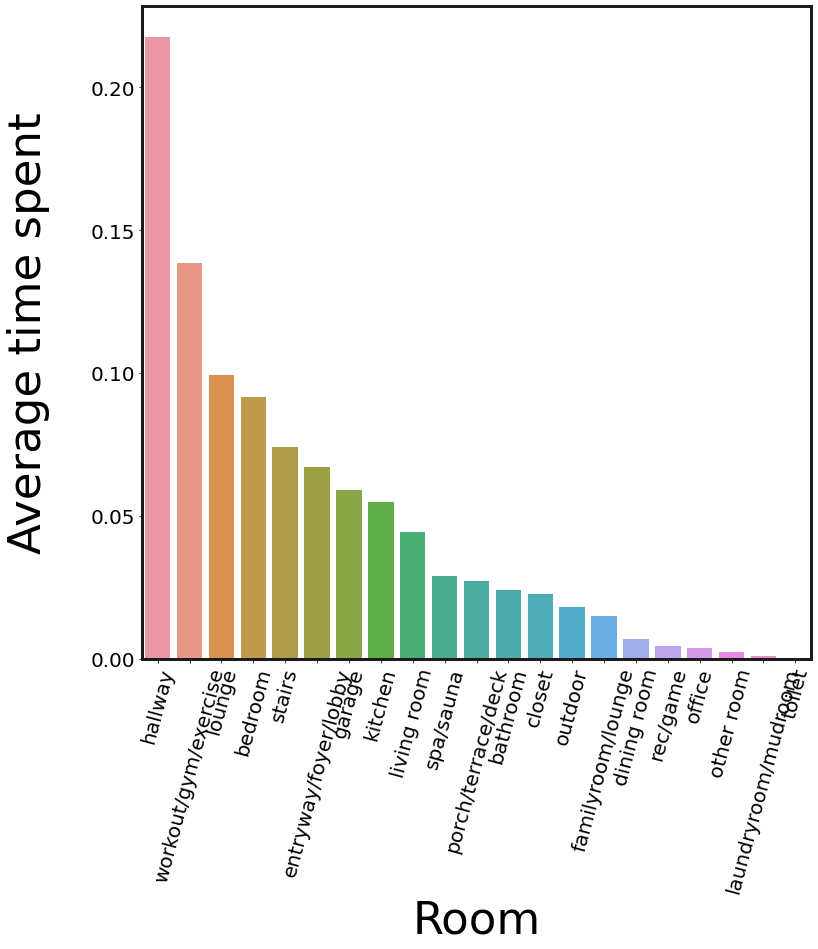

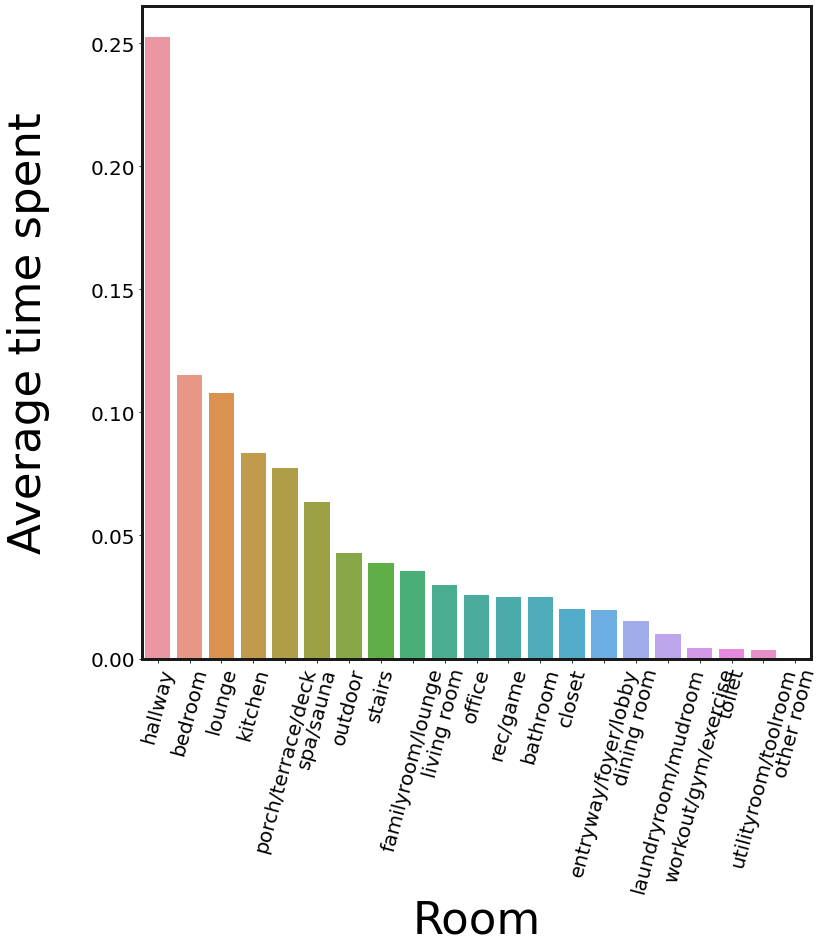

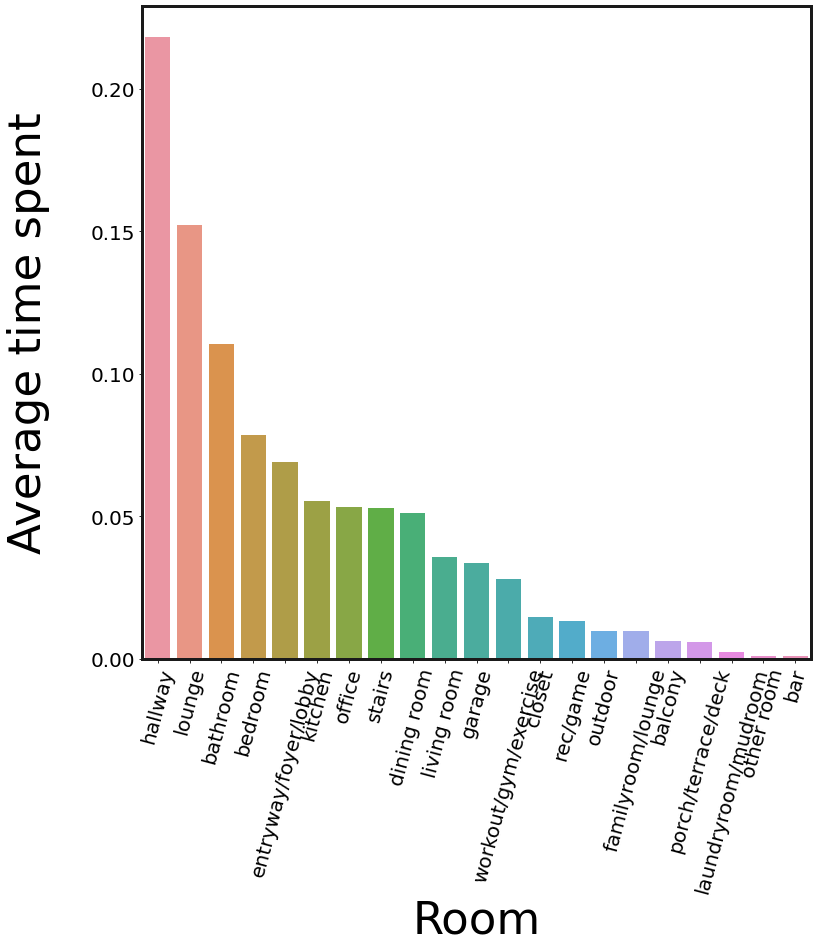

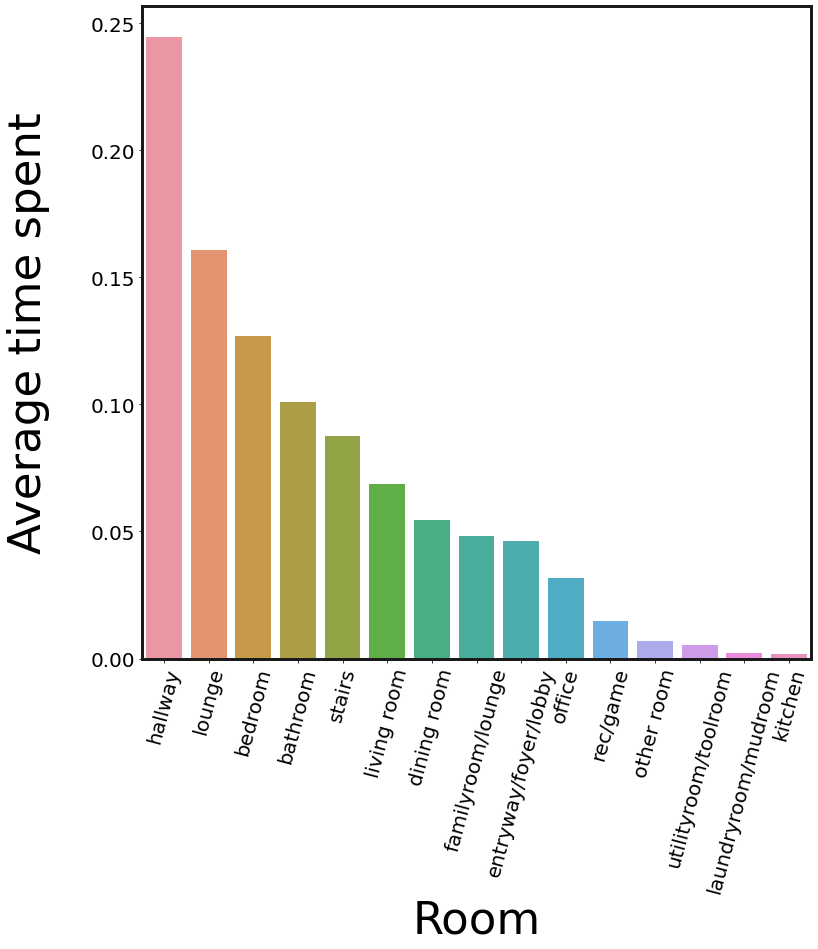

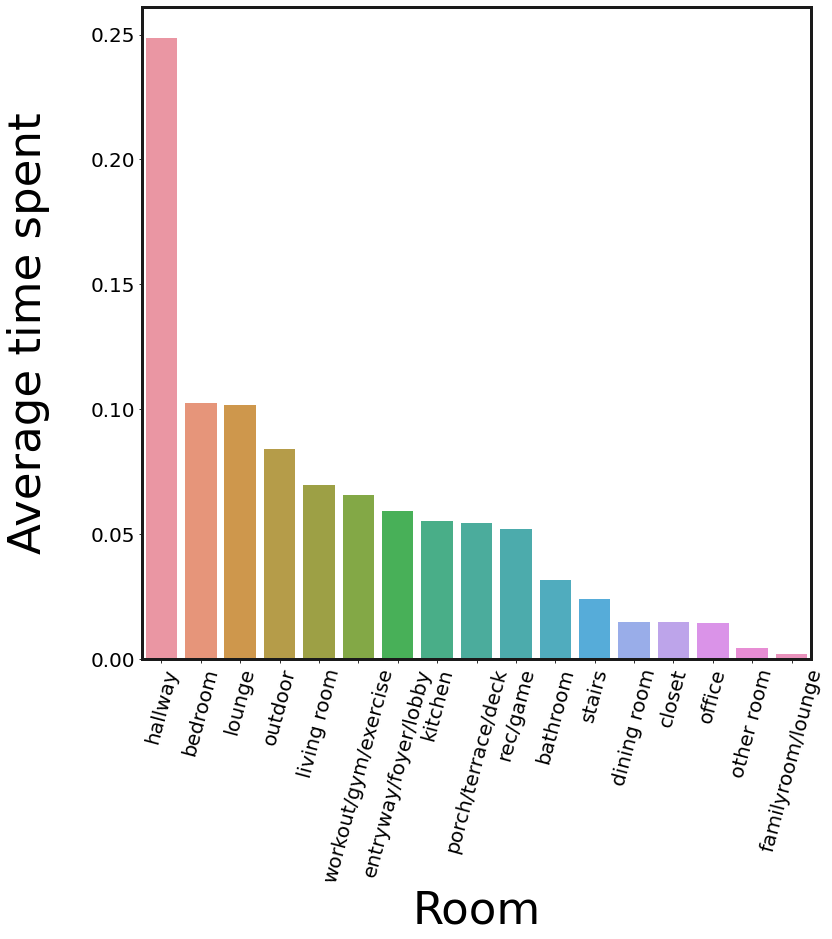

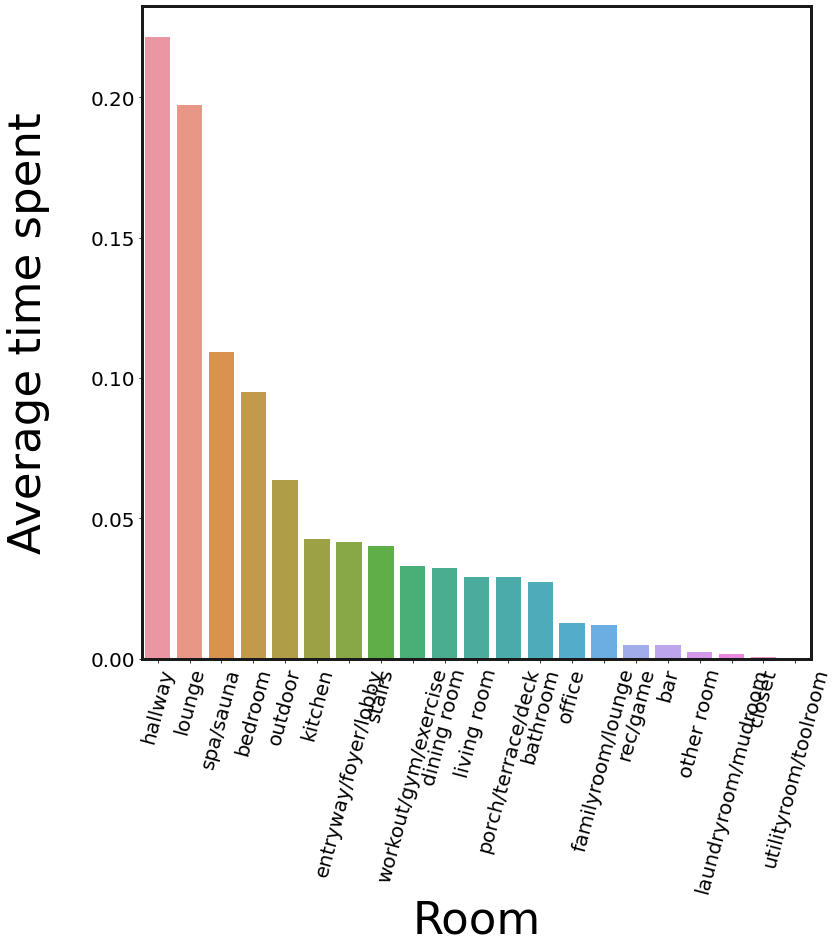

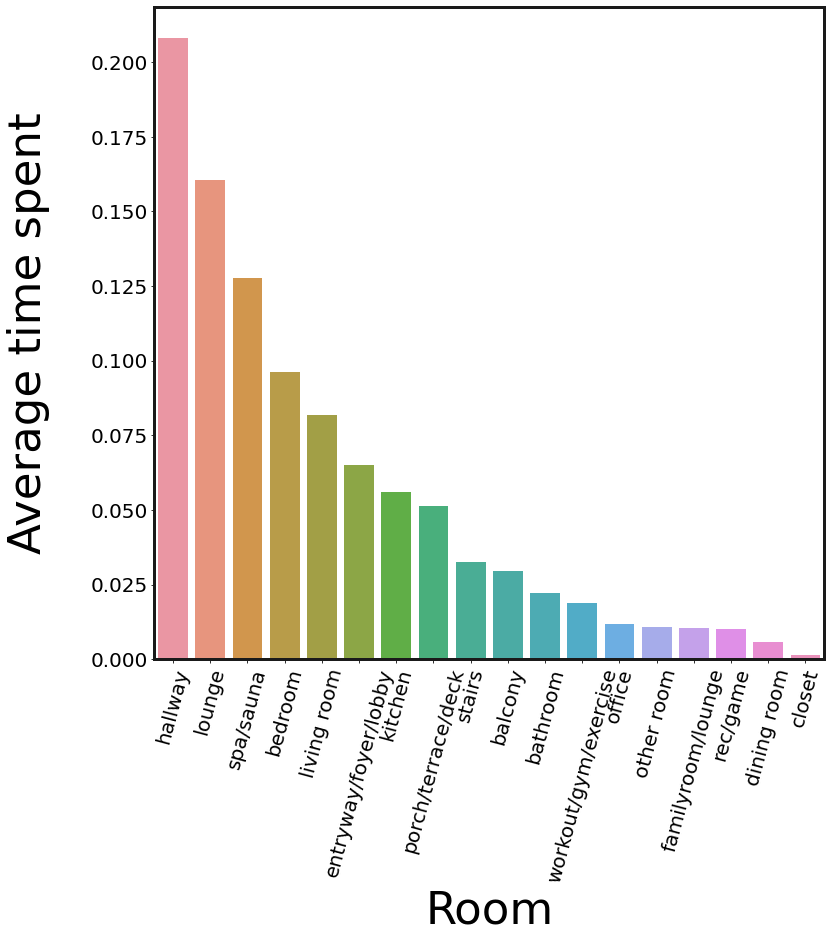

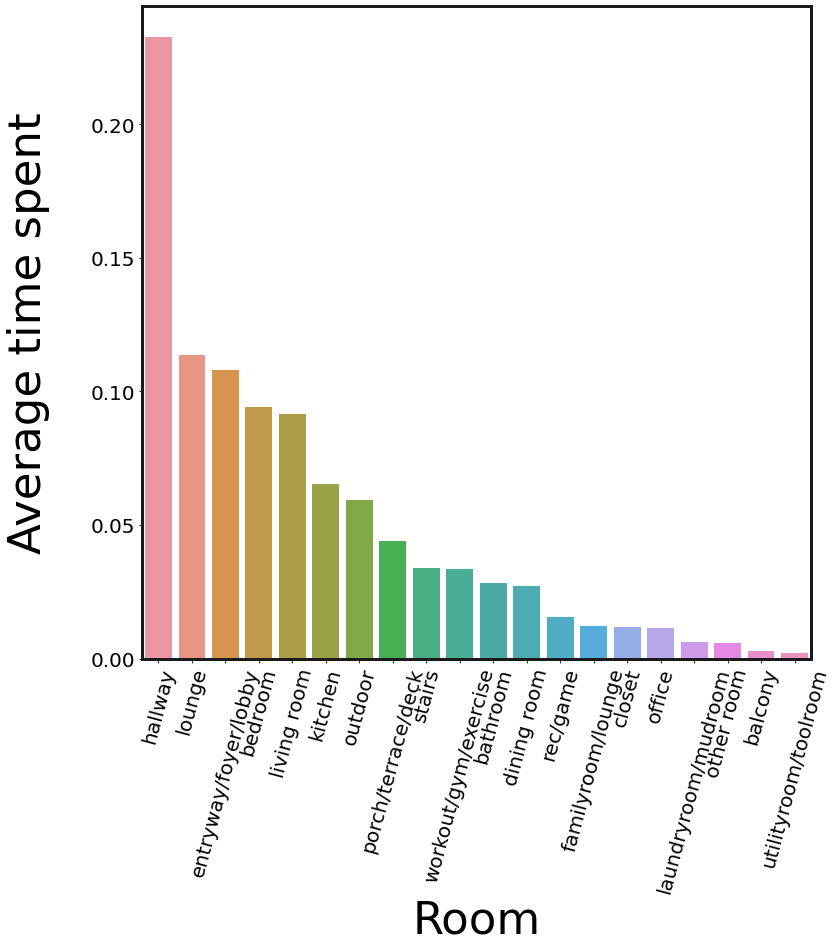

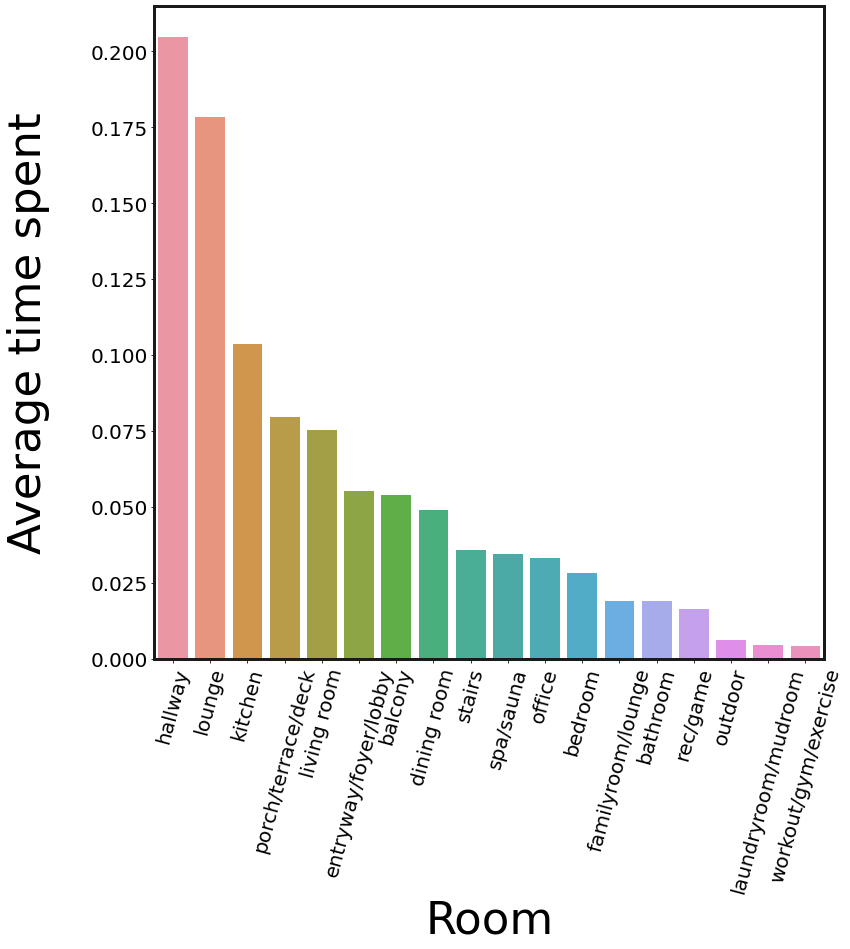

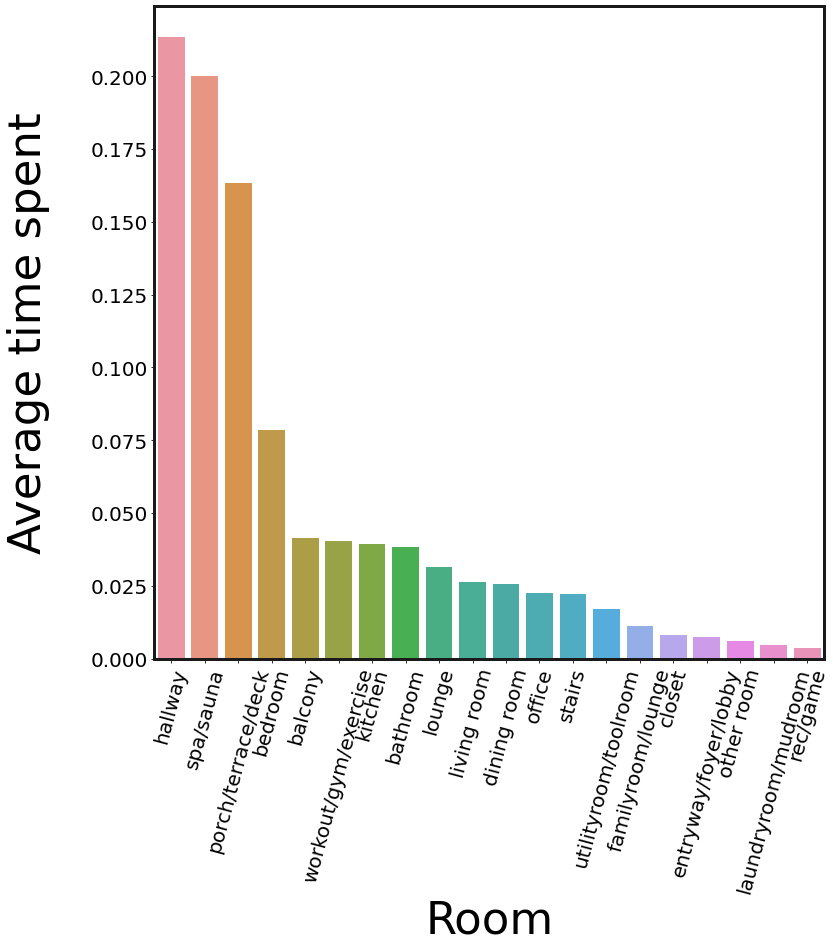

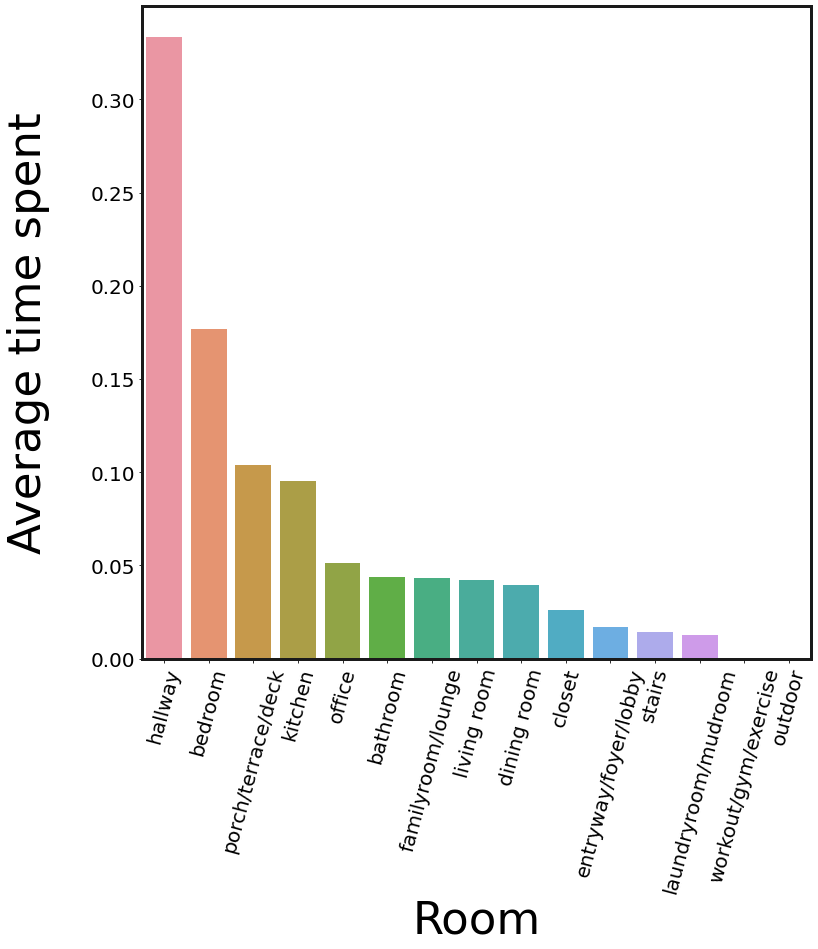

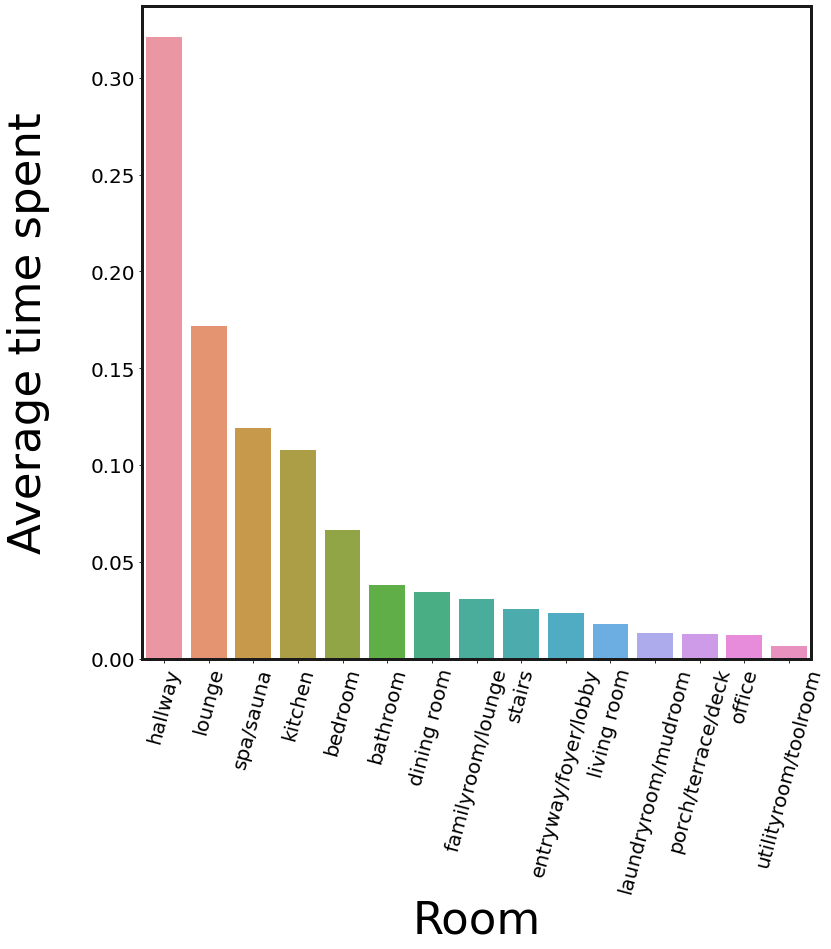

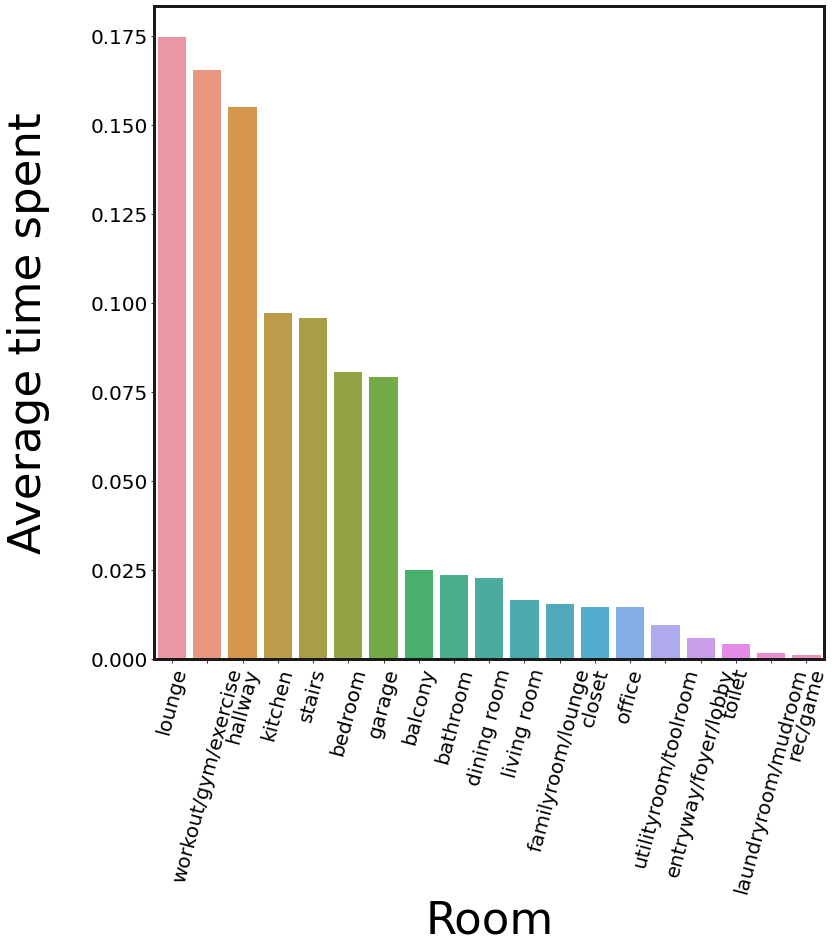

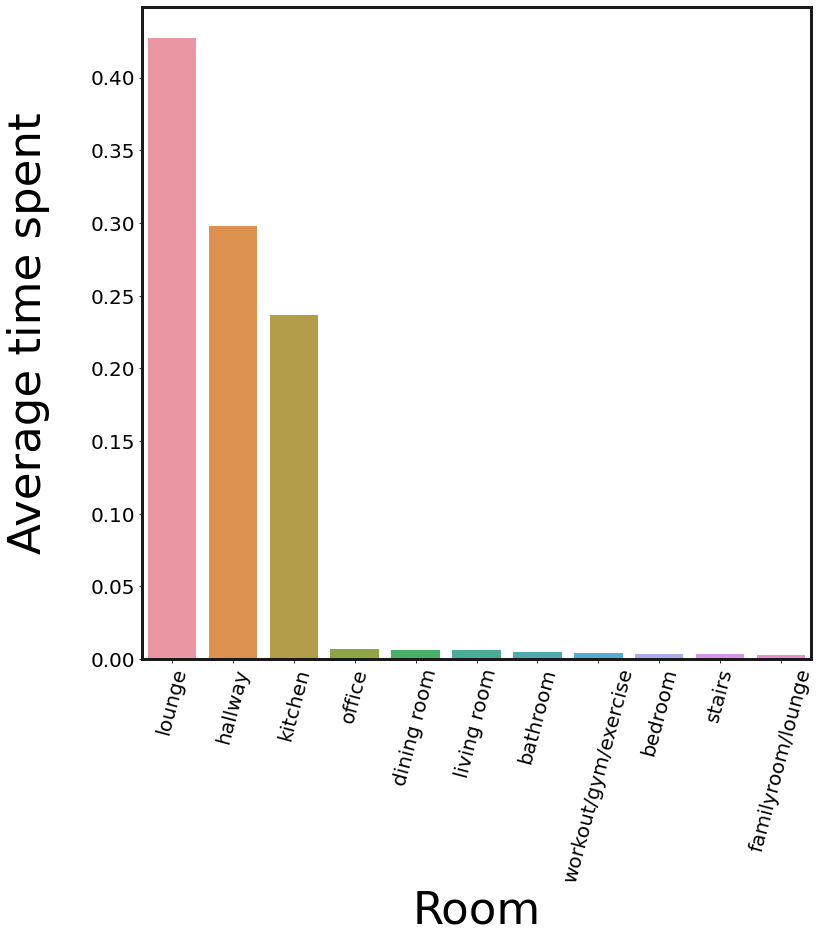

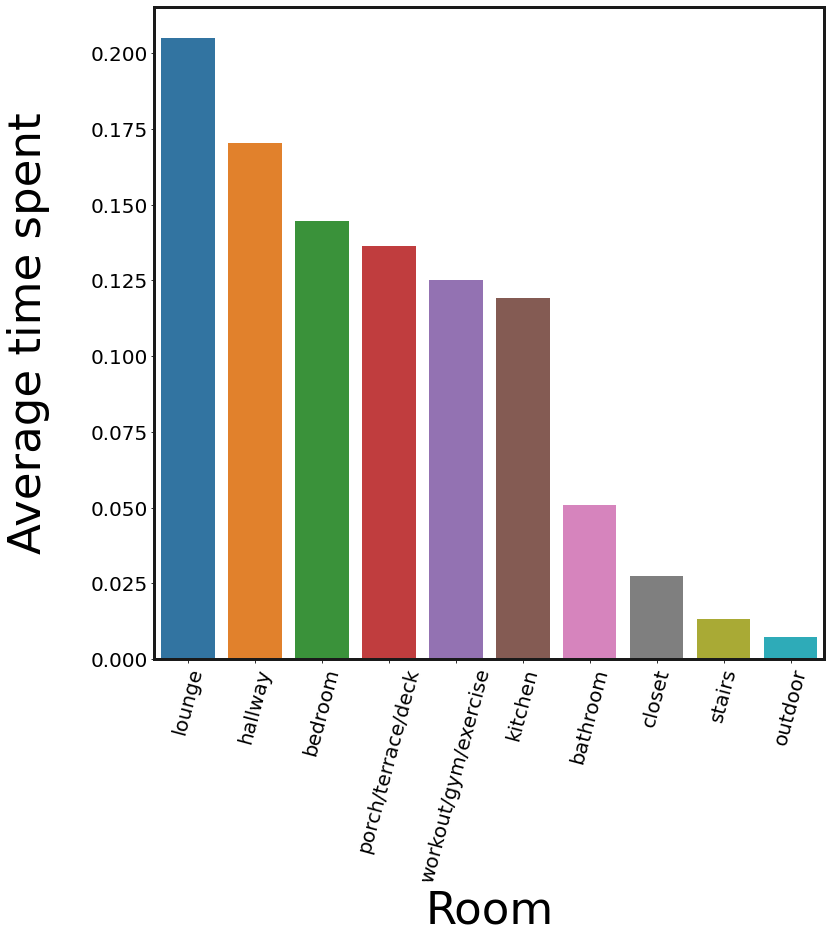

In [127]:
for object_category, time_spent_room_map in avg_time_per_room.items():
    fig, axs = plt.subplots(1, 1, figsize=(12, 12))

    fig_dims = (12, 12)
    
    plot_barplot(
        list(time_spent_room_map.keys()), list(time_spent_room_map.values()),
        x_label="Room", y_label="Average time spent", ax=axs, x_rotation=75
    )
    plt.show()
    fig.savefig("figures/objectnav/objectnav_il/{}_per_room_time_spent.jpg".format(object_category), dpi=100, bbox_inches="tight", pad_inches=0.1, transparent=False)

### Exploration heatmap

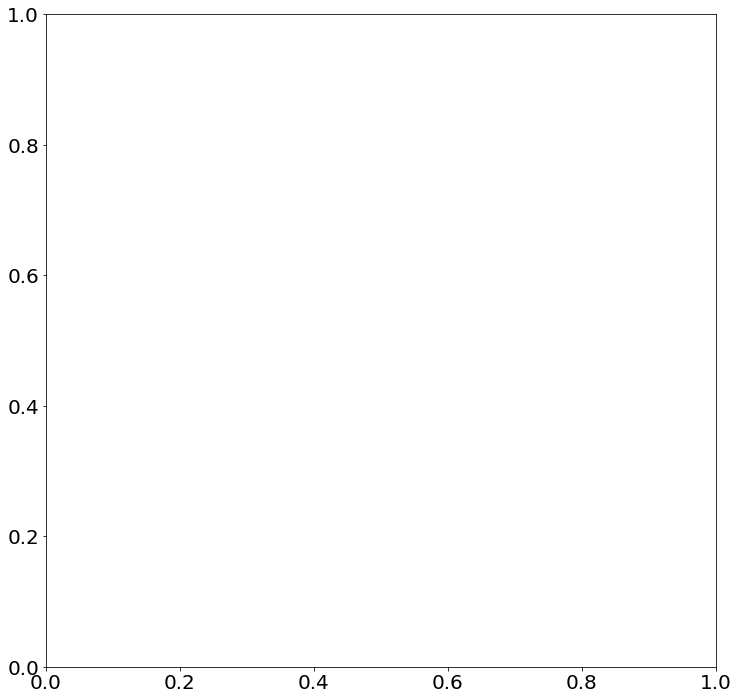

In [244]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))

fig_dims = (12, 12)

In [235]:
data = np.load("../data/stats/top_down_map/top_down_map.npy")
data = np.where(data < 2, 0, data)
print(data.shape)

(512, 679)


In [236]:
data.shape
hmax = sns.heatmap(data[:400, 350:], cmap="Oranges", alpha = 0.5, # whole heatmap is translucent
            zorder = 2, ax=axs)

In [237]:
np.unique(data)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 72, 73], dtype=uint8)

In [238]:
data_img = np.load("../data/stats/top_down_map/init_top_down_map_colored.npy")
print(data_img.shape)
print(data.shape)
print(hmax.get_aspect())
print(hmax.get_xlim(), hmax.get_ylim())


hmax.imshow(data_img[:400, 351:, :],
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1)
plt.show()

(512, 679, 3)
(512, 679)
auto
(0.0, 329.0) (400.0, 0.0)


In [239]:
fig.savefig('heatmap.jpg')

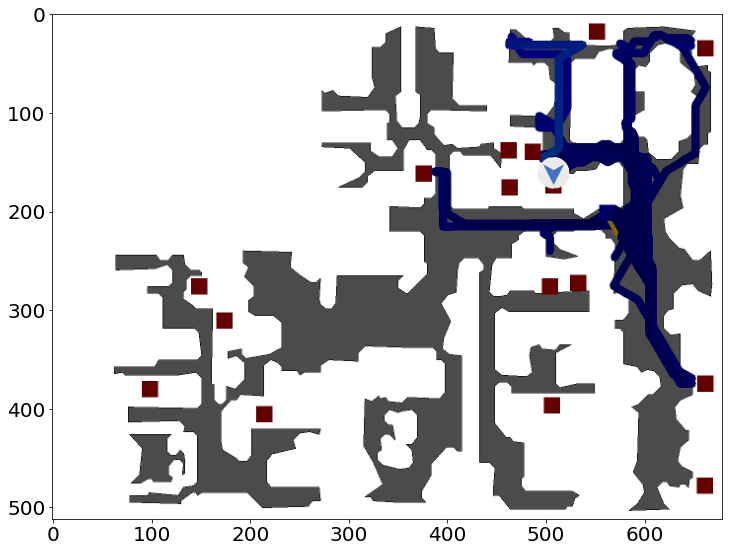

In [242]:
data_img = np.load("../data/stats/top_down_map/top_down_map_colored.npy")
plt.imshow(data_img)

In [246]:
from PIL import Image
im = Image.fromarray(data_img)
im.save("original.jpg")

In [73]:
data = np.load("../data/stats/top_down_map/top_down_map_colored.npy")
print(data.shape)

(512, 679, 3)


<AxesSubplot:>

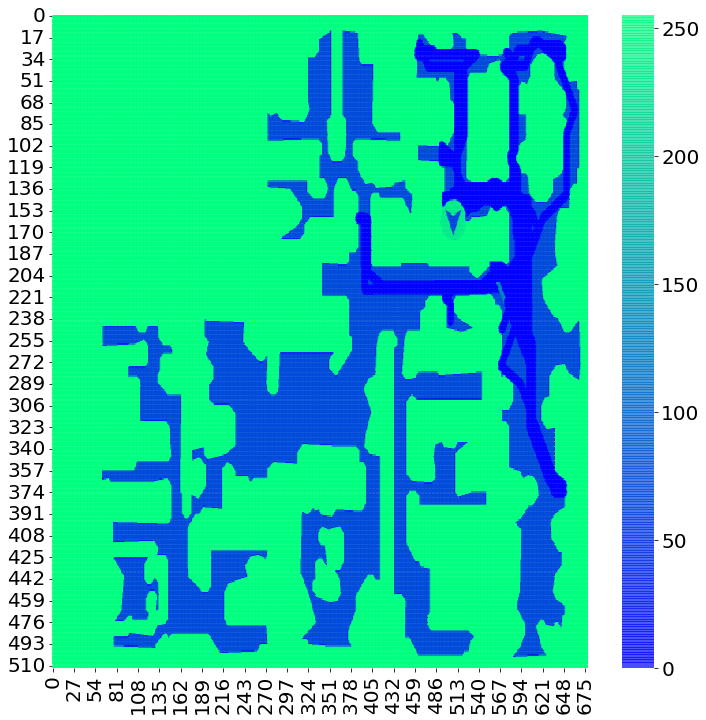

In [39]:
sns.heatmap(data[:,:,0], cmap=matplotlib.cm.winter, alpha = 0.7, # whole heatmap is translucent
            zorder = 2,)

In [26]:
import cv2

heatmap_img = cv2.applyColorMap(data, cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.7, data, 0.3, 0)
#cv2.imshow('fin', fin)

(512, 679, 3)


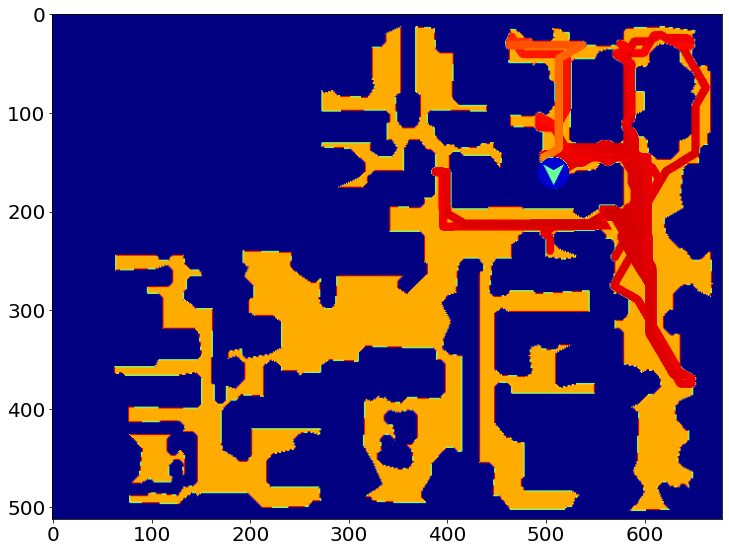

In [29]:
print(heatmap_img.shape)
plt.imshow(heatmap_img)

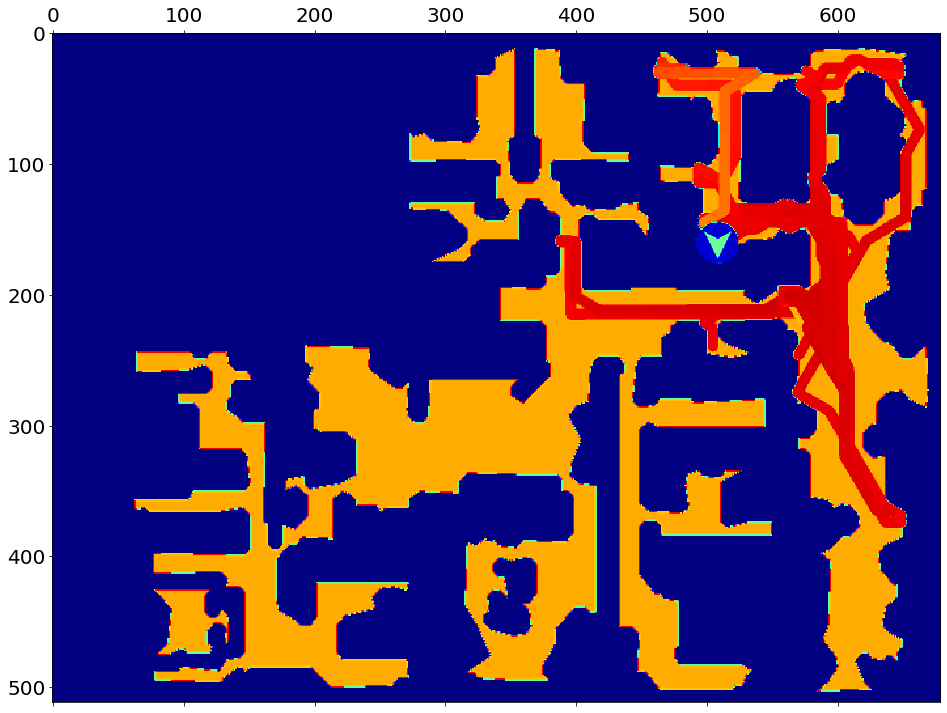

In [21]:
gray_img.shape, heatmap_img.shape
heatmapshow = None
heatmapshow = cv2.normalize(heatmap_img, heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)

plt.matshow(heatmap_img)

In [35]:
np.unique(data[:,:,0])

array([  0,   1,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,
        15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  89,  90,  92,  93,  94,  96,  97,
        99, 101, 102, 106, 107, 108, 109, 113, 114, 115, 116, 117, 118,
       122, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137,
       138, 139, 140, 142, 143, 144, 145, 147, 148, 149, 150, 152, 153,
       155, 156, 157, 158, 159, 160, 165, 166, 167, 168, 169, 171, 172,
       175, 176, 177, 179, 184, 185, 187, 189, 191, 192, 193, 195, 198,
       200, 201, 203, 205, 206, 207, 208, 209, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 223, 225, 226, 227, 229, 231, 23

In [44]:
data = np.load("../data/stats/top_down_map/visit_map.npy")
print(data.shape)

(1024, 1358)


<AxesSubplot:>

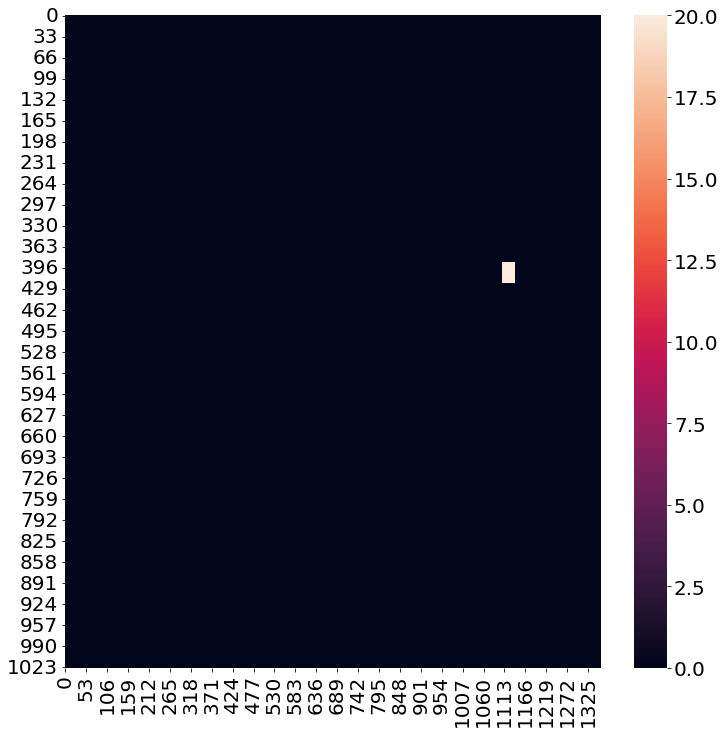

In [45]:
sns.heatmap(data)

In [46]:
np.unique(data)

array([ 0., 20.])